# Porto Seguro

In [1]:
# Libs to deal with tabular data
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 2000)

# Statistics
from scipy.stats import chi2_contingency
from scipy.stats.contingency import expected_freq

# Plotting packages
import seaborn as sns
sns.axes_style("darkgrid")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Machine Learning
from xverse.transformer import WOE
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import recall_score, f1_score
from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier

# Optimization
import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_param_importances, plot_slice

# To display stuff in notebook
from IPython.display import display, Markdown

# Misc 
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import time
import os
import glob


In [2]:
def cramers_v(var1, var2):
    cont_freq = pd.crosstab(var1, var2).values
    n_obs = cont_freq.sum().sum()
    chi2_test = chi2_contingency(cont_freq)
    cramers_v = np.sqrt(chi2_test[0] / (n_obs * (min(cont_freq.shape) - 1)))
    return cramers_v

In [3]:
train = pd.read_csv('../data/interim/local_cv.csv')
feats = pd.read_csv('../data/raw/metadata.csv')

In [4]:
feats = feats[~feats['Variavel cod'].isin(['id', 'y'])]
feats['Variavel tipo'] = feats['Variavel tipo'].replace({
    'Qualitativo nominal': 'quali_nom',
    'Quantitativo discreto': 'quanti_dis',
    'Quantitativo continua': 'quanti_cont',
    'Qualitativo ordinal': 'quali_ord'
})
feat_type_dict = feats.groupby('Variavel tipo')['Variavel cod'].unique().to_dict()
feat_type_dict

{'quali_nom': array(['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8',
        'var9', 'var10', 'var11', 'var12', 'var13', 'var14', 'var15',
        'var16', 'var17', 'var18', 'var19', 'var20', 'var21', 'var22',
        'var23', 'var28', 'var29', 'var30', 'var31', 'var33', 'var34',
        'var35', 'var36', 'var37', 'var38', 'var39', 'var41'], dtype=object),
 'quali_ord': array(['var26', 'var32', 'var42', 'var43'], dtype=object),
 'quanti_cont': array(['var55', 'var56', 'var57', 'var58', 'var59', 'var60', 'var61',
        'var62', 'var63', 'var64', 'var65', 'var66'], dtype=object),
 'quanti_dis': array(['var24', 'var25', 'var27', 'var40', 'var44', 'var45', 'var46',
        'var47', 'var48', 'var49', 'var50', 'var51', 'var52', 'var53',
        'var54', 'var67', 'var68'], dtype=object)}

In [5]:
display(train.shape)

(14123, 71)

In [7]:
train['cv'].value_counts()

0.0    2825
1.0    2825
2.0    2825
4.0    2824
3.0    2824
Name: cv, dtype: int64

In [8]:
train.groupby('cv')['y'].mean()

cv
0.0    0.201770
1.0    0.201770
2.0    0.201770
3.0    0.201841
4.0    0.201841
Name: y, dtype: float64

In [9]:
train.groupby('cv').mean()

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
cv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,17419.461239,9.403540,26.095221,1602.207788,15273.815221,5446.553982,1316.927434,-107.725310,-136.304071,-100.058053,-111.917876,13439.844248,3339.539823,1359.137699,19.709027,-66.694867,-66.021239,-85.146549,-94.238938,1051.969558,19.963186,1390.668319,3.493451,2.550442,0.957522,2.093805,-107.882832,0.362124,19.201062,3.663717,1.389027,0.036460,13.675398,3.095575,26.554336,398.230442,14.234690,7.527080,1.820531,3.593982,5.997876,3.108319,24.661947,6.858761,0.866549,0.266549,0.222655,0.041062,0.103009,0.331681,0.138053,0.054513,-78.658761,1.643186,1.531327,0.215240,-106.012764,-106.121818,-112.707543,-149.399015,-455.012757,-26.614138,0.070796,0.777582,0.027806,-861.752181,-861.791196,-39.054466,-2.295109,0.201770
1.0,17443.222655,9.786549,24.759292,1603.072212,15253.872566,5566.721770,1333.123540,-101.505841,-131.213451,-103.592566,-116.128496,13297.418761,3471.838584,1342.560708,19.403540,-61.167788,-60.537345,-79.811681,-88.901239,1057.896991,19.650265,1386.926372,3.450265,2.539115,0.948673,2.077876,-97.928142,0.391150,19.377345,3.633274,1.383009,0.038938,13.738407,3.198938,26.550796,391.945841,14.543717,7.927788,1.943363,3.575575,6.000708,3.090265,24.716460,6.998584,0.865841,0.289204,0.234690,0.050265,0.119292,0.361062,0.147257,0.056991,-82.280000,1.646372,1.529204,0.216567,-109.190850,-109.314903,-102.800480,-150.453674,-452.883436,-18.827363,0.073165,0.773107,0.029382,-863.869734,-863.912687,-41.532988,-3.003550,0.201770
2.0,17680.813805,9.801062,29.438584,1599.324602,15165.180885,5503.500177,1329.518938,-100.909027,-131.869735,-105.349027,-114.940177,13512.085310,3484.546903,1352.020531,19.414867,-66.915044,-66.278938,-85.495929,-94.569204,1071.540885,19.864071,1391.272920,3.454159,2.529558,0.969204,2.120354,-106.464071,0.364602,19.349381,3.663363,1.391150,0.033982,13.576637,3.142301,26.779115,392.521416,14.377699,7.500531,1.865841,3.585133,5.989027,3.090619,24.740177,6.841062,0.863363,0.282478,0.220885,0.055929,0.098053,0.337345,0.152212,0.050973,-83.979823,1.646726,1.533451,0.216312,-110.244721,-110.386093,-111.286326,-147.980371,-452.175914,-26.964268,0.073713,0.781624,0.029067,-858.212654,-858.255014,-35.868954,-0.882440,0.201770
3.0,16971.239731,9.700071,22.158286,1565.585340,15204.385977,5555.944051,1315.794618,-110.223088,-144.916431,-105.728399,-123.512394,13136.048867,3447.492564,1355.479816,19.338527,-64.256020,-63.583569,-82.486190,-91.422450,1053.646955,19.686261,1395.479462,3.494688,2.519830,0.969901,2.067989,-108.567989,0.363314,19.161119,3.611544,1.384915,0.037535,13.804887,3.101275,26.805241,393.836048,14.191926,7.415368,1.851983,3.599504,5.991856,3.095255,24.804887,6.718839,0.863314,0.276912,0.224150,0.048867,0.103754,0.333924,0.154037,0.060907,-84.555595,1.637394,1.514873,0.216165,-112.058761,-112.185603,-113.449100,-153.695363,-469.324344,-28.038508,0.074736,0.778247,0.029074,-863.473894,-863.511570,-43.312469,-2.298084,0.201841
4.0,17858.467068,9.872167,17.378541,1553.148371,14998.570467,5645.809844,1281.194405,-128.212110,-147.835340,-117.087465,-128.439448,13326.023371,3406.985836,1367.782932,19.538952,-70.122521,-69.481941,-89.174929,-98.483357,1060.137040,19.804533,1409.760623,3.500354,2.525496,0.947946,2.105878,-110.088527,0.368980,19.098442,3.648725,1.386331,0.035057,13.777266,3.171742,26.327550,394.741501,14.307720,7.557365,1.853399,3.608357,6.072238,3.098796,24.761686,6.858003,0.869688,0.260977,0.205737,0.053116,0.106232,0.354462,0.150142,0.053116,-96.725212,1.602691,1.487252,0.215872,-121.609040,-122.455899,-114.869393

In [12]:
train[train['y'].eq(0)].groupby('cv').mean()

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
cv,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,17533.707317,9.908204,26.050554,1588.644346,14003.166741,5503.913082,1224.557871,-139.086475,-74.690022,-118.428381,-134.795565,13049.468736,3215.523725,1344.415078,19.096674,-86.711752,-86.051441,-105.149889,-114.196896,1043.016851,19.327716,1379.748559,3.461641,2.458093,0.966741,2.094013,-128.991131,0.340576,18.707317,3.597783,1.381375,0.036807,13.721951,3.097118,25.981818,396.627938,14.349002,7.462084,1.868293,3.580044,5.926829,3.098448,24.630599,6.794235,0.864302,0.261197,0.220399,0.039468,0.105543,0.337916,0.156984,0.049667,-97.056319,1.625721,1.532594,0.215821,-124.961312,-125.048178,-133.692465,-169.490239,-470.379775,-28.088425,0.070824,0.768331,0.027877,-862.068799,-862.107078,-38.785229,-2.920852,0.0
1.0,17454.649224,10.326829,31.310421,1620.231042,14021.362306,5634.598226,1244.020399,-132.079379,-65.520177,-117.075388,-132.939690,13066.285144,3410.523725,1333.253215,18.889135,-77.907317,-77.261641,-96.335698,-105.293126,1052.149446,19.030599,1373.395122,3.417738,2.458537,0.960089,2.078936,-116.021729,0.372062,19.115299,3.578271,1.379157,0.043016,13.807095,3.195122,26.154767,386.821286,14.543237,7.729490,2.011973,3.564967,5.853215,3.083814,24.633703,6.925499,0.865632,0.281153,0.229712,0.046563,0.112195,0.361419,0.159202,0.052772,-95.550776,1.646120,1.542350,0.217173,-122.298221,-122.396527,-120.841754,-165.496662,-471.258227,-18.778786,0.072384,0.762683,0.029467,-868.710817,-868.751995,-35.242742,-3.366007,0.0
2.0,17676.134812,10.342794,32.058980,1593.803104,13736.253659,5607.881596,1247.183149,-131.925499,-65.489135,-120.615965,-129.626164,13274.951220,3413.070067,1353.227938,18.848780,-84.842129,-84.218625,-103.060754,-111.958315,1061.518847,19.192905,1389.451441,3.428825,2.439911,0.974723,2.114856,-124.514412,0.348559,19.085588,3.606652,1.392905,0.031486,13.558758,3.160089,26.500665,388.104213,14.349889,7.510865,1.929047,3.584922,5.859424,3.101996,24.704656,6.735698,0.865632,0.278049,0.220399,0.052328,0.104213,0.337472,0.164523,0.048780,-99.206208,1.643016,1.548115,0.217037,-124.506310,-124.622141,-129.256977,-162.395828,-472.144056,-28.529129,0.073074,0.774551,0.028960,-859.406274,-859.449252,-33.909000,-0.707586,0.0
3.0,16918.056788,10.212067,26.085626,1571.532387,13762.158829,5598.140195,1221.255102,-143.444099,-76.304791,-122.436114,-141.511091,12733.091837,3322.921917,1350.216948,18.807897,-80.417480,-79.742236,-98.327418,-107.122893,1045.708518,19.105590,1388.198758,3.481366,2.449423,0.995563,2.057675,-126.287933,0.346051,18.752440,3.561668,1.383319,0.037267,13.860692,3.135315,26.373558,392.770186,13.956522,7.333185,1.865572,3.583407,5.864241,3.090062,24.742236,6.632653,0.865129,0.261313,0.208962,0.049689,0.095830,0.327862,0.171695,0.055013,-101.393966,1.616681,1.513310,0.216678,-128.111633,-128.218573,-131.087148,-173.111016,-484.769414,-29.432726,0.073917,0.772750,0.028893,-865.999215,-866.035613,-38.801125,-2.481921,0.0
4.0,17844.683230,10.418367,22.200089,1554.715617,13646.894410,5737.678793,1180.246673,-164.548358,-72.791925,-137.094055,-150.390861,12888.094942,3306.074091,1353.742680,19.070098,-90.452972,-89.791038,-109.111358,-118.208962,1047.957409,19.317214,1403.354037,3.509317,2.444987,0.978261,2.088731,-131.276841,0.349157,18.875333,3.599823,1.385093,0.035492,13.871340,3.210293,26.083851,392.664596,14.090506,7.613132,1.868234,3.612245,5.944543,3.111801,24.713398,6.794587,0.867347,0.263531,0.206300,0.055013,0.105146,0.339397,0.172138,0.049246,-116.988909,1.580302,1.480479,0.216333,-140.527049,-141.521894,-135.968382,-192.1749

In [27]:
def rus_objective(trial):
    cv_scores = []
    for X_train, y_train, X_val, y_val in fold_sets:
        clf = LGBMClassifier(
            random_state=42, 
            n_jobs=-1, 
            importance_type='gain', 
            is_unbalance=False,
            num_leaves = trial.suggest_int('num_leaves', 2, 64),
            learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
            n_estimators = trial.suggest_int('n_estimators', 100, 500)
        ).fit(X_train_res, y_train_res)
        score = f1_score(y_val, clf.predict(X_val))
        cv_scores.append(score)
    score_series = pd.Series(cv_scores)
    print(cv_scores)
    print(score_series.mean(), score_series.std())
    try:
        opt_score = score_series.mean() / score_series.std()
    except:
        opt_score = 0
    return opt_score

train = pd.read_csv('../data/raw/train.csv')
X_train = train.drop(columns=['id', 'y'])
y_train = train['y']

fold_sets = []
cv = StratifiedKFold(5, random_state = 42, shuffle=True)
for array_idxs in cv.split(X_train, y_train):
    train_index, val_index = array_idxs[0], array_idxs[1]
    X_train_kf, X_val = X_train.loc[train_index], X_train.loc[val_index]
    y_train_kf, y_val = y_train.loc[train_index], y_train.loc[val_index]
    rus = RandomUnderSampler(sampling_strategy=0.5199689404423158, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train_kf, y_train_kf)
    fold_sets.append((X_train_res, y_train_res, X_val, y_val))

study = optuna.create_study(sampler=TPESampler(seed = 42), direction='maximize')
study.optimize(rus_objective, n_trials=250)

print('Best model')
print('Mean validation F1: ', study.best_value, '\n')
print(study.best_params)

models_list = []
cv_scores = []
for X_train, y_train, X_val, y_val in fold_sets:
    clf = LGBMClassifier(
        random_state=42, 
        n_jobs=-1, 
        importance_type='gain', 
        is_unbalance=False,
        num_leaves = study.best_params['num_leaves'],
        learning_rate = study.best_params['learning_rate'],
        n_estimators = study.best_params['n_estimators']
    ).fit(X_train_res, y_train_res)
    cv_scores.append(f1_score(y_val, clf.predict(X_val)))
    models_list.append(clf)

print('Cross validation after tuning')    
print(pd.Series(cv_scores).mean())

[I 2021-09-02 01:49:08,139] A new study created in memory with name: no-name-98f1e38f-f9e2-4d46-818f-511bd7daccf0
[I 2021-09-02 01:49:10,559] Trial 0 finished with value: 7.764637517536957 and parameters: {'num_leaves': 25, 'learning_rate': 0.566984951147885, 'n_estimators': 393}. Best is trial 0 with value: 7.764637517536957.


[0.9083665338645418, 0.9054805401111994, 0.9062003179650239, 0.9098164405426975, 0.660393498716852]
0.8580514662400629 0.11050760119865169


[I 2021-09-02 01:49:12,029] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 39, 'learning_rate': 6.0268891286825045e-05, 'n_estimators': 162}. Best is trial 0 with value: 7.764637517536957.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:12,783] Trial 2 finished with value: 14.49784483984355 and parameters: {'num_leaves': 5, 'learning_rate': 0.21423021757741043, 'n_estimators': 341}. Best is trial 2 with value: 14.49784483984355.


[0.7905803195962994, 0.8198121263877027, 0.8134453781512604, 0.8133891213389121, 0.690721649484536]
0.7855897189917421 0.054186655166342614


[I 2021-09-02 01:49:17,549] Trial 3 finished with value: 0.0 and parameters: {'num_leaves': 46, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488}. Best is trial 2 with value: 14.49784483984355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:19,413] Trial 4 finished with value: 0.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.00011526449540315612, 'n_estimators': 172}. Best is trial 2 with value: 14.49784483984355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:20,793] Trial 5 finished with value: 0.0 and parameters: {'num_leaves': 13, 'learning_rate': 0.00033205591037519585, 'n_estimators': 310}. Best is trial 2 with value: 14.49784483984355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:23,409] Trial 6 finished with value: 0.0 and parameters: {'num_leaves': 29, 'learning_rate': 0.0002858549394196192, 'n_estimators': 345}. Best is trial 2 with value: 14.49784483984355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:24,375] Trial 7 finished with value: 0.0 and parameters: {'num_leaves': 10, 'learning_rate': 0.00028888383623653144, 'n_estimators': 246}. Best is trial 2 with value: 14.49784483984355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:49:25,669] Trial 8 finished with value: 8.838603012415753 and parameters: {'num_leaves': 30, 'learning_rate': 0.08431013932082466, 'n_estimators': 180}. Best is trial 2 with value: 14.49784483984355.


[0.8585445625511039, 0.8941755537325676, 0.8946938775510205, 0.8887083671811534, 0.6736474694589878]
0.8419539660949666 0.09525871508339699


[I 2021-09-02 01:49:26,759] Trial 9 finished with value: 33.838107689626504 and parameters: {'num_leaves': 34, 'learning_rate': 0.009163741808778781, 'n_estimators': 118}. Best is trial 9 with value: 33.838107689626504.


[0.6503178928247048, 0.6641998149861239, 0.6985294117647058, 0.6768676867686769, 0.6529850746268657]
0.6685799761942155 0.019758196360347216


[I 2021-09-02 01:49:28,113] Trial 10 finished with value: 21.51152045486451 and parameters: {'num_leaves': 61, 'learning_rate': 0.017772299067083552, 'n_estimators': 103}. Best is trial 9 with value: 33.838107689626504.


[0.7098445595854922, 0.7400881057268723, 0.744718309859155, 0.7335047129391603, 0.6636609558160504]
0.718363328785346 0.033394353983142035


[I 2021-09-02 01:49:29,629] Trial 11 finished with value: 22.018712650727835 and parameters: {'num_leaves': 60, 'learning_rate': 0.01324813114701145, 'n_estimators': 115}. Best is trial 9 with value: 33.838107689626504.


[0.6977973568281939, 0.7186379928315412, 0.7417923691215618, 0.7179039301310043, 0.656307129798903]
0.7064877557422409 0.032085788435905115


[I 2021-09-02 01:49:31,165] Trial 12 finished with value: 22.118649165113574 and parameters: {'num_leaves': 63, 'learning_rate': 0.004878439904794283, 'n_estimators': 113}. Best is trial 9 with value: 33.838107689626504.


[0.6523955147808359, 0.6477392218717141, 0.6707441386340469, 0.654434250764526, 0.5941872981700753]
0.6439000848442396 0.029111184866561595


[I 2021-09-02 01:49:33,822] Trial 13 finished with value: 41.681489772629355 and parameters: {'num_leaves': 46, 'learning_rate': 0.0033323093621866005, 'n_estimators': 240}. Best is trial 13 with value: 41.681489772629355.


[0.6584905660377358, 0.6685934489402698, 0.6905660377358491, 0.6766917293233082, 0.6491228070175438]
0.6686929178109413 0.01604292268483279


[I 2021-09-02 01:49:36,281] Trial 14 finished with value: 13.172004926448981 and parameters: {'num_leaves': 41, 'learning_rate': 0.001485187751108622, 'n_estimators': 237}. Best is trial 13 with value: 41.681489772629355.


[0.3763736263736263, 0.3728813559322034, 0.44740346205059917, 0.4108108108108108, 0.393939393939394]
0.4002817298213267 0.030388823269992354


[I 2021-09-02 01:49:37,999] Trial 15 finished with value: 13.033905193580859 and parameters: {'num_leaves': 22, 'learning_rate': 0.0013663486378361518, 'n_estimators': 241}. Best is trial 13 with value: 41.681489772629355.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:49:42,251] Trial 16 finished with value: 8.156373125230678 and parameters: {'num_leaves': 49, 'learning_rate': 0.04226912842647001, 'n_estimators': 417}. Best is trial 13 with value: 41.681489772629355.


[0.9141940657578188, 0.9141940657578188, 0.9223300970873786, 0.9112709832134293, 0.6777292576419214]
0.8679436938916734 0.10641294611777906


[I 2021-09-02 01:49:44,457] Trial 17 finished with value: 26.79375288858855 and parameters: {'num_leaves': 38, 'learning_rate': 0.007005077506010396, 'n_estimators': 210}. Best is trial 13 with value: 41.681489772629355.


[0.6589285714285714, 0.6727272727272728, 0.7168458781362006, 0.6884955752212388, 0.6544789762340036]
0.6782952547494574 0.025315425486302185


[I 2021-09-02 01:49:46,291] Trial 18 finished with value: 21.12962567283491 and parameters: {'num_leaves': 19, 'learning_rate': 0.0015239569727580299, 'n_estimators': 275}. Best is trial 13 with value: 41.681489772629355.


[0.4842615012106537, 0.49131513647642683, 0.537914691943128, 0.5280764635603344, 0.49502487562189046]
0.5073185337624867 0.024009821168517704


[I 2021-09-02 01:49:47,723] Trial 19 finished with value: 9.788836045197083 and parameters: {'num_leaves': 34, 'learning_rate': 0.06821085578517597, 'n_estimators': 150}. Best is trial 13 with value: 41.681489772629355.


[0.826267664172901, 0.8688387635756056, 0.865996649916248, 0.8724279835390947, 0.6753698868581376]
0.8217801896123975 0.08395075633283347


[I 2021-09-02 01:49:50,349] Trial 20 finished with value: 12.663914921708152 and parameters: {'num_leaves': 52, 'learning_rate': 0.021623880070703125, 'n_estimators': 199}. Best is trial 13 with value: 41.681489772629355.


[0.7849372384937239, 0.8246205733558178, 0.8177257525083612, 0.8157894736842105, 0.6766256590509667]
0.783939739418616 0.06190342751551553


[I 2021-09-02 01:49:52,531] Trial 21 finished with value: 27.48317990555877 and parameters: {'num_leaves': 39, 'learning_rate': 0.005934166119225624, 'n_estimators': 203}. Best is trial 13 with value: 41.681489772629355.


[0.6570397111913356, 0.6691176470588235, 0.7119565217391305, 0.6846361185983827, 0.6506024096385542]
0.6746704816452453 0.02454848689138719


[I 2021-09-02 01:49:56,061] Trial 22 finished with value: 32.182605836917986 and parameters: {'num_leaves': 44, 'learning_rate': 0.0036220476262041677, 'n_estimators': 275}. Best is trial 13 with value: 41.681489772629355.


[0.6593607305936072, 0.6754221388367729, 0.7066420664206642, 0.68, 0.6529080675422139]
0.6748666006786517 0.02096991785247186


[I 2021-09-02 01:50:00,058] Trial 23 finished with value: 38.15399897664754 and parameters: {'num_leaves': 45, 'learning_rate': 0.002291573007499681, 'n_estimators': 287}. Best is trial 13 with value: 41.681489772629355.


[0.6433430515063168, 0.642570281124498, 0.6757281553398058, 0.6660212971926428, 0.636178861788618]
0.6527683293903762 0.017108778814768754


[I 2021-09-02 01:50:04,862] Trial 24 finished with value: 0.0 and parameters: {'num_leaves': 55, 'learning_rate': 0.0007545775991180694, 'n_estimators': 298}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:50:09,075] Trial 25 finished with value: 38.468328716943844 and parameters: {'num_leaves': 33, 'learning_rate': 0.0026270085431760386, 'n_estimators': 355}. Best is trial 13 with value: 41.681489772629355.


[0.6508226691042047, 0.6566604127579738, 0.6901669758812616, 0.6745886654478976, 0.6508987701040682]
0.6646274986590812 0.017277264722091706


[I 2021-09-02 01:50:15,340] Trial 26 finished with value: 38.60992380317922 and parameters: {'num_leaves': 48, 'learning_rate': 0.002238973276262361, 'n_estimators': 364}. Best is trial 13 with value: 41.681489772629355.


[0.6635338345864662, 0.6685934489402698, 0.6942615239887112, 0.6791744840525329, 0.6478048780487804]
0.6706736339233521 0.017370498769752232


[I 2021-09-02 01:50:21,673] Trial 27 finished with value: 0.0 and parameters: {'num_leaves': 49, 'learning_rate': 5.104123901692668e-05, 'n_estimators': 395}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:50:29,497] Trial 28 finished with value: 13.033905193580859 and parameters: {'num_leaves': 56, 'learning_rate': 0.0007422346058141022, 'n_estimators': 450}. Best is trial 13 with value: 41.681489772629355.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:50:33,074] Trial 29 finished with value: 0.0 and parameters: {'num_leaves': 29, 'learning_rate': 0.0005858414971207336, 'n_estimators': 339}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:50:35,922] Trial 30 finished with value: 7.899570348993026 and parameters: {'num_leaves': 24, 'learning_rate': 0.5202062646286563, 'n_estimators': 367}. Best is trial 13 with value: 41.681489772629355.


[0.9033280507131537, 0.9047619047619047, 0.917135961383749, 0.9062003179650239, 0.6649350649350649]
0.8592722599517792 0.10877455633537239


[I 2021-09-02 01:50:41,214] Trial 31 finished with value: 26.460095188084434 and parameters: {'num_leaves': 43, 'learning_rate': 0.0034648259506486357, 'n_estimators': 380}. Best is trial 13 with value: 41.681489772629355.


[0.6600896860986547, 0.6758241758241759, 0.7187780772686433, 0.6827524575513853, 0.6531738730450782]
0.6781236539575874 0.02562816381185815


[I 2021-09-02 01:50:46,780] Trial 32 finished with value: 41.1156234538888 and parameters: {'num_leaves': 49, 'learning_rate': 0.002175560233380638, 'n_estimators': 303}. Best is trial 13 with value: 41.681489772629355.


[0.6517943743937924, 0.6513026052104209, 0.6783625730994152, 0.6673114119922631, 0.6370070778564207]
0.6571556085104625 0.015983111851568126


[I 2021-09-02 01:50:51,056] Trial 33 finished with value: 9.796057982658546 and parameters: {'num_leaves': 36, 'learning_rate': 0.02981217985511223, 'n_estimators': 327}. Best is trial 13 with value: 41.681489772629355.


[0.831814415907208, 0.8683989941324394, 0.8754152823920266, 0.8669950738916257, 0.6764705882352942]
0.8238188709117187 0.08409697782210789


[I 2021-09-02 01:50:57,592] Trial 34 finished with value: 25.999823440727432 and parameters: {'num_leaves': 50, 'learning_rate': 0.0030922441146169722, 'n_estimators': 425}. Best is trial 13 with value: 41.681489772629355.


[0.6702508960573477, 0.685032139577594, 0.7228699551569506, 0.6956521739130435, 0.6531365313653138]
0.68538833921405 0.0263612689823279


[I 2021-09-02 01:51:03,854] Trial 35 finished with value: 0.0 and parameters: {'num_leaves': 58, 'learning_rate': 0.0001288074189223085, 'n_estimators': 367}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:51:10,339] Trial 36 finished with value: 13.033905193580859 and parameters: {'num_leaves': 47, 'learning_rate': 0.0010807150980515336, 'n_estimators': 313}. Best is trial 13 with value: 41.681489772629355.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:51:15,733] Trial 37 finished with value: 18.127756130912047 and parameters: {'num_leaves': 52, 'learning_rate': 0.011694341956141212, 'n_estimators': 265}. Best is trial 13 with value: 41.681489772629355.


[0.7420435510887773, 0.7782571182053495, 0.7756849315068495, 0.7662771285475793, 0.6789797713280562]
0.7482485001353223 0.04127639928139723


[I 2021-09-02 01:51:24,349] Trial 38 finished with value: 33.07463470644633 and parameters: {'num_leaves': 41, 'learning_rate': 0.002188001123761746, 'n_estimators': 487}. Best is trial 13 with value: 41.681489772629355.


[0.6551410373066423, 0.6703806870937791, 0.7032967032967034, 0.6805429864253394, 0.654170571696345]
0.6727063971637618 0.020339042385028958


[I 2021-09-02 01:51:28,864] Trial 39 finished with value: 0.0 and parameters: {'num_leaves': 30, 'learning_rate': 0.0001200551165557026, 'n_estimators': 356}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:51:33,875] Trial 40 finished with value: 0.0 and parameters: {'num_leaves': 42, 'learning_rate': 0.00036363952100164647, 'n_estimators': 325}. Best is trial 13 with value: 41.681489772629355.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:51:39,061] Trial 41 finished with value: 48.588177464865055 and parameters: {'num_leaves': 46, 'learning_rate': 0.0024570013910596034, 'n_estimators': 298}. Best is trial 41 with value: 48.588177464865055.


[0.6583732057416268, 0.663395485770363, 0.6781609195402298, 0.6723646723646725, 0.6428571428571429]
0.663030285254807 0.013645917995879874


[I 2021-09-02 01:51:44,573] Trial 42 finished with value: 26.371489708251744 and parameters: {'num_leaves': 48, 'learning_rate': 0.007558991153643592, 'n_estimators': 304}. Best is trial 41 with value: 48.588177464865055.


[0.702054794520548, 0.732568402471315, 0.7410008779631255, 0.7308684436801375, 0.675531914893617]
0.7164048867057486 0.027165886138073674


[I 2021-09-02 01:51:48,422] Trial 43 finished with value: 0.0 and parameters: {'num_leaves': 37, 'learning_rate': 0.0005392357023499203, 'n_estimators': 257}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:51:55,967] Trial 44 finished with value: 40.96047171787865 and parameters: {'num_leaves': 52, 'learning_rate': 0.0019650781737103893, 'n_estimators': 395}. Best is trial 41 with value: 48.588177464865055.


[0.6622390891840607, 0.6692607003891049, 0.6919431279620853, 0.6755218216318786, 0.6476938174681061]
0.669331711327047 0.016340918042574534


[I 2021-09-02 01:52:02,729] Trial 45 finished with value: 0.0 and parameters: {'num_leaves': 52, 'learning_rate': 1.2212146836434607e-05, 'n_estimators': 398}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:52:11,068] Trial 46 finished with value: 17.73970664382167 and parameters: {'num_leaves': 55, 'learning_rate': 0.0010625981618963064, 'n_estimators': 458}. Best is trial 41 with value: 48.588177464865055.


[0.604143947655398, 0.5844748858447489, 0.6314655172413792, 0.6095444685466378, 0.5424912689173457]
0.594424017641102 0.03350810865004502


[I 2021-09-02 01:52:15,645] Trial 47 finished with value: 0.0 and parameters: {'num_leaves': 64, 'learning_rate': 0.00022091118473642563, 'n_estimators': 225}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:52:23,481] Trial 48 finished with value: 19.810719205367 and parameters: {'num_leaves': 58, 'learning_rate': 0.005264078851914087, 'n_estimators': 426}. Best is trial 41 with value: 48.588177464865055.


[0.7244897959183674, 0.7491228070175437, 0.7614125753660638, 0.7485182049110923, 0.669051878354204]
0.7305190523134543 0.03687493849872681


[I 2021-09-02 01:52:28,300] Trial 49 finished with value: 23.18818815261895 and parameters: {'num_leaves': 47, 'learning_rate': 0.00180444699207992, 'n_estimators': 289}. Best is trial 41 with value: 48.588177464865055.


[0.6303901437371663, 0.6195069667738479, 0.6521739130434782, 0.638689866939611, 0.5812154696132598]
0.6243952720214726 0.026927298843353202


[I 2021-09-02 01:52:33,531] Trial 50 finished with value: 0.0 and parameters: {'num_leaves': 46, 'learning_rate': 3.1411416266999414e-05, 'n_estimators': 321}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:52:39,361] Trial 51 finished with value: 30.22631493504608 and parameters: {'num_leaves': 51, 'learning_rate': 0.002853223249261712, 'n_estimators': 345}. Best is trial 41 with value: 48.588177464865055.


[0.6697332106715731, 0.6797752808988763, 0.7128347183748847, 0.6886446886446885, 0.652214891611687]
0.680640558040342 0.022518145513370842


[I 2021-09-02 01:52:40,772] Trial 52 finished with value: 34.85126933671664 and parameters: {'num_leaves': 4, 'learning_rate': 0.004356899541000583, 'n_estimators': 406}. Best is trial 41 with value: 48.588177464865055.


[0.611361587015329, 0.6367041198501873, 0.6575091575091575, 0.6485998193315267, 0.6522961574507966]
0.6412941682313994 0.01840088411229776


[I 2021-09-02 01:52:45,478] Trial 53 finished with value: 17.03642949919411 and parameters: {'num_leaves': 33, 'learning_rate': 0.013084109435322573, 'n_estimators': 379}. Best is trial 41 with value: 48.588177464865055.


[0.7366638441998307, 0.7814113597246127, 0.7780634104541561, 0.7718120805369127, 0.6771378708551484]
0.7490177131541322 0.04396565097103027


[I 2021-09-02 01:52:50,491] Trial 54 finished with value: 13.726009576261136 and parameters: {'num_leaves': 41, 'learning_rate': 0.001138787852792137, 'n_estimators': 341}. Best is trial 41 with value: 48.588177464865055.


[0.4257555847568989, 0.4167794316644114, 0.49683143219264897, 0.44213263979193757, 0.4266666666666667]
0.4416331510145127 0.03217491205734758


[I 2021-09-02 01:52:55,351] Trial 55 finished with value: 26.258892701327962 and parameters: {'num_leaves': 32, 'learning_rate': 0.00899522530543715, 'n_estimators': 378}. Best is trial 41 with value: 48.588177464865055.


[0.7015437392795882, 0.7360988526037069, 0.7433016421780466, 0.7428087986463621, 0.6830553116769096]
0.7213616688769227 0.02747113814286777


[I 2021-09-02 01:52:58,775] Trial 56 finished with value: 18.168852070009965 and parameters: {'num_leaves': 39, 'learning_rate': 0.00195538269908049, 'n_estimators': 224}. Best is trial 41 with value: 48.588177464865055.


[0.5042219541616406, 0.5068322981366459, 0.552538370720189, 0.5108958837772396, 0.4740177439797213]
0.5097012501550873 0.028053574776824505


[I 2021-09-02 01:53:01,613] Trial 57 finished with value: 38.150113509551865 and parameters: {'num_leaves': 16, 'learning_rate': 0.018881428288413712, 'n_estimators': 359}. Best is trial 41 with value: 48.588177464865055.


[0.6989795918367347, 0.7215411558669002, 0.7345517841601392, 0.7217021276595744, 0.6887532693984306]
0.7131055857843558 0.01869209604332662


[I 2021-09-02 01:53:04,515] Trial 58 finished with value: 35.000082313159695 and parameters: {'num_leaves': 27, 'learning_rate': 0.004582094475989529, 'n_estimators': 250}. Best is trial 41 with value: 48.588177464865055.


[0.6462646264626463, 0.6556473829201102, 0.6933575978161964, 0.6708520179372198, 0.6519337016574586]
0.6636110653587262 0.01896027156225329


[I 2021-09-02 01:53:09,863] Trial 59 finished with value: 0.0 and parameters: {'num_leaves': 61, 'learning_rate': 0.0004290963422918817, 'n_estimators': 280}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:53:10,847] Trial 60 finished with value: 0.0 and parameters: {'num_leaves': 9, 'learning_rate': 0.0008143288441460354, 'n_estimators': 157}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:53:15,578] Trial 61 finished with value: 29.63746119752013 and parameters: {'num_leaves': 45, 'learning_rate': 0.0020345839646421257, 'n_estimators': 290}. Best is trial 41 with value: 48.588177464865055.


[0.6399999999999999, 0.6350515463917527, 0.6686746987951808, 0.658753709198813, 0.6129374337221634]
0.6430834776215819 0.021698332166028816


[I 2021-09-02 01:53:19,687] Trial 62 finished with value: 47.38780702480809 and parameters: {'num_leaves': 44, 'learning_rate': 0.003009407496722168, 'n_estimators': 262}. Best is trial 41 with value: 48.588177464865055.


[0.6571969696969697, 0.6692456479690522, 0.6850094876660341, 0.6754221388367729, 0.6497560975609756]
0.667326068345961 0.014082231490404435


[I 2021-09-02 01:53:23,910] Trial 63 finished with value: 48.52251578809662 and parameters: {'num_leaves': 44, 'learning_rate': 0.0029247879141559713, 'n_estimators': 265}. Best is trial 41 with value: 48.588177464865055.


[0.6546830652790918, 0.6660194174757281, 0.682509505703422, 0.6741996233521657, 0.6490713587487781]
0.6652965941118371 0.013711090270283253


[I 2021-09-02 01:53:28,634] Trial 64 finished with value: 16.466297478609942 and parameters: {'num_leaves': 53, 'learning_rate': 0.001479366207575119, 'n_estimators': 264}. Best is trial 41 with value: 48.588177464865055.


[0.4578005115089514, 0.46073298429319376, 0.5143570536828964, 0.47133757961783435, 0.43766578249336874]
0.4683787823192489 0.028444693345767772


[I 2021-09-02 01:53:33,074] Trial 65 finished with value: 26.264712574123667 and parameters: {'num_leaves': 50, 'learning_rate': 0.005816115638056847, 'n_estimators': 236}. Best is trial 41 with value: 48.588177464865055.


[0.669051878354204, 0.6910420475319926, 0.7240143369175627, 0.6984969053934571, 0.656880733944954]
0.6878971804284341 0.026190927408288458


[I 2021-09-02 01:53:36,307] Trial 66 finished with value: 44.30796500349917 and parameters: {'num_leaves': 43, 'learning_rate': 0.003601024895863582, 'n_estimators': 189}. Best is trial 41 with value: 48.588177464865055.


[0.6466602129719264, 0.6487025948103793, 0.6750483558994198, 0.6653846153846154, 0.6390293225480282]
0.6549650203228738 0.014782105661389522


[I 2021-09-02 01:53:40,218] Trial 67 finished with value: 30.826707771603512 and parameters: {'num_leaves': 44, 'learning_rate': 0.009839329080022052, 'n_estimators': 210}. Best is trial 41 with value: 48.588177464865055.


[0.6858137510879025, 0.7175843694493784, 0.7238938053097344, 0.7191011235955056, 0.6732318710832587]
0.703924984105156 0.022834906319564464


[I 2021-09-02 01:53:43,032] Trial 68 finished with value: 45.55261672327389 and parameters: {'num_leaves': 39, 'learning_rate': 0.003449657802129625, 'n_estimators': 193}. Best is trial 41 with value: 48.588177464865055.


[0.6414728682170543, 0.6447105788423153, 0.6711798839458414, 0.6628131021194604, 0.6389452332657201]
0.6518243332780783 0.014309262127307081


[I 2021-09-02 01:53:45,270] Trial 69 finished with value: 18.67711681042304 and parameters: {'num_leaves': 40, 'learning_rate': 0.003138310866319789, 'n_estimators': 141}. Best is trial 41 with value: 48.588177464865055.


[0.5143540669856459, 0.5233415233415233, 0.5569917743830787, 0.5245508982035927, 0.4791929382093317]
0.5196862402246344 0.027824757188144575


[I 2021-09-02 01:53:48,077] Trial 70 finished with value: 10.676586636809217 and parameters: {'num_leaves': 43, 'learning_rate': 0.03600174509104415, 'n_estimators': 187}. Best is trial 41 with value: 48.588177464865055.


[0.8084033613445378, 0.8554522400676247, 0.8538205980066446, 0.856907894736842, 0.6800348735832606]
0.810923793547782 0.07595346913141643


[I 2021-09-02 01:53:50,818] Trial 71 finished with value: 36.9591074372957 and parameters: {'num_leaves': 35, 'learning_rate': 0.00417170188788804, 'n_estimators': 192}. Best is trial 41 with value: 48.588177464865055.


[0.6441947565543071, 0.657088122605364, 0.6848030018761726, 0.6716141001855288, 0.643611911623439]
0.6602623785689623 0.017864673265964394


[I 2021-09-02 01:53:54,583] Trial 72 finished with value: 26.513115526629583 and parameters: {'num_leaves': 46, 'learning_rate': 0.005818887310265136, 'n_estimators': 220}. Best is trial 41 with value: 48.588177464865055.


[0.6606660666066607, 0.6808118081180811, 0.7200720072007201, 0.6851520572450804, 0.6549491211840888]
0.6803302120709261 0.025660138333709115


[I 2021-09-02 01:53:56,750] Trial 73 finished with value: 0.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.0015086049586229041, 'n_estimators': 136}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:53:59,163] Trial 74 finished with value: 18.483106982477217 and parameters: {'num_leaves': 38, 'learning_rate': 0.002829916536617469, 'n_estimators': 167}. Best is trial 41 with value: 48.588177464865055.


[0.5462857142857144, 0.5529411764705883, 0.5964125560538117, 0.5798414496036239, 0.5186972255729795]
0.5588356243973436 0.030234939662857757


[I 2021-09-02 01:54:03,170] Trial 75 finished with value: 0.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.00098027525286218, 'n_estimators': 241}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:54:06,215] Trial 76 finished with value: 25.918316135752995 and parameters: {'num_leaves': 50, 'learning_rate': 0.006994998410003896, 'n_estimators': 178}. Best is trial 41 with value: 48.588177464865055.


[0.6654643823264202, 0.6869806094182825, 0.7218721872187219, 0.6904549509366638, 0.6530989824236818]
0.6835742224647541 0.02637417565571701


[I 2021-09-02 01:54:10,775] Trial 77 finished with value: 0.0 and parameters: {'num_leaves': 45, 'learning_rate': 0.0005807676557981172, 'n_estimators': 270}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:54:15,379] Trial 78 finished with value: 28.722410903209823 and parameters: {'num_leaves': 54, 'learning_rate': 0.0039048349880587713, 'n_estimators': 254}. Best is trial 41 with value: 48.588177464865055.


[0.6703499079189686, 0.6810506566604126, 0.7169117647058825, 0.6916742909423604, 0.6534839924670433]
0.6826941225389335 0.02376869145280002


[I 2021-09-02 01:54:18,497] Trial 79 finished with value: 13.033905193580859 and parameters: {'num_leaves': 41, 'learning_rate': 0.001530482722123798, 'n_estimators': 203}. Best is trial 41 with value: 48.588177464865055.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:54:24,062] Trial 80 finished with value: 11.702512340256641 and parameters: {'num_leaves': 58, 'learning_rate': 0.014707175127433973, 'n_estimators': 300}. Best is trial 41 with value: 48.588177464865055.


[0.7993311036789298, 0.8398994132439229, 0.8334714167357082, 0.8329258353708232, 0.6783523225241017]
0.7967960183106971 0.06808760334049971


[I 2021-09-02 01:54:29,219] Trial 81 finished with value: 41.890079535700536 and parameters: {'num_leaves': 48, 'learning_rate': 0.00231838827656975, 'n_estimators': 310}. Best is trial 41 with value: 48.588177464865055.


[0.6577181208053692, 0.6647000983284169, 0.6839080459770115, 0.6736641221374046, 0.6421471172962226]
0.664427500908885 0.015861213639917566


[I 2021-09-02 01:54:35,120] Trial 82 finished with value: 40.2351903992144 and parameters: {'num_leaves': 49, 'learning_rate': 0.0024898221925318486, 'n_estimators': 311}. Best is trial 41 with value: 48.588177464865055.


[0.6641366223908919, 0.6653696498054474, 0.6925996204933587, 0.6767200754005654, 0.6476938174681061]
0.6693039571116739 0.016634790353191473


[I 2021-09-02 01:54:40,032] Trial 83 finished with value: 29.452090414299516 and parameters: {'num_leaves': 47, 'learning_rate': 0.00812199032967822, 'n_estimators': 281}. Best is trial 41 with value: 48.588177464865055.


[0.7049742710120069, 0.7288732394366199, 0.7403508771929824, 0.7271171941830624, 0.6791111111111111]
0.7160853385871565 0.024313565811935858


[I 2021-09-02 01:54:45,377] Trial 84 finished with value: 31.34416064488767 and parameters: {'num_leaves': 44, 'learning_rate': 0.0033288011800729086, 'n_estimators': 333}. Best is trial 41 with value: 48.588177464865055.


[0.6600181323662738, 0.6747211895910781, 0.708142726440988, 0.6822682268226823, 0.6529850746268657]
0.6756270699695776 0.021555117638148477


[I 2021-09-02 01:54:48,568] Trial 85 finished with value: 0.0 and parameters: {'num_leaves': 37, 'learning_rate': 0.0012328573630739181, 'n_estimators': 232}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:54:52,519] Trial 86 finished with value: 21.324866428940076 and parameters: {'num_leaves': 42, 'learning_rate': 0.0019137019146798187, 'n_estimators': 259}. Best is trial 41 with value: 48.588177464865055.


[0.5952890792291221, 0.5914221218961625, 0.6345123258306538, 0.6027987082884823, 0.5563218390804597]
0.5960688148649761 0.02795181938659406


[I 2021-09-02 01:54:57,629] Trial 87 finished with value: 0.0 and parameters: {'num_leaves': 51, 'learning_rate': 0.0008620438699706518, 'n_estimators': 293}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:55:02,797] Trial 88 finished with value: 29.86808347127894 and parameters: {'num_leaves': 56, 'learning_rate': 0.0025145150879753455, 'n_estimators': 273}. Best is trial 41 with value: 48.588177464865055.


[0.6614785992217899, 0.6599799398194585, 0.6848780487804877, 0.6718446601941748, 0.6253807106598985]
0.660712391735162 0.022121017318386067


[I 2021-09-02 01:55:06,405] Trial 89 finished with value: 28.72673969669553 and parameters: {'num_leaves': 39, 'learning_rate': 0.004983441868044508, 'n_estimators': 246}. Best is trial 41 with value: 48.588177464865055.


[0.6582506762849414, 0.6703397612488521, 0.7101449275362319, 0.6816546762589927, 0.65]
0.6740780082658036 0.023465176187165558


[I 2021-09-02 01:55:13,450] Trial 90 finished with value: 8.278005643350383 and parameters: {'num_leaves': 46, 'learning_rate': 0.13930465713070167, 'n_estimators': 497}. Best is trial 41 with value: 48.588177464865055.


[0.9112709832134293, 0.9127301841473178, 0.9105431309904153, 0.9112709832134293, 0.6778761061946903]
0.8647382775518564 0.10446215124853045


[I 2021-09-02 01:55:19,766] Trial 91 finished with value: 40.884458630830636 and parameters: {'num_leaves': 49, 'learning_rate': 0.0025040954545192486, 'n_estimators': 309}. Best is trial 41 with value: 48.588177464865055.


[0.6641366223908919, 0.6640701071080818, 0.6919431279620853, 0.6754966887417219, 0.6476938174681061]
0.6686680727341774 0.016355067307408107


[I 2021-09-02 01:55:24,291] Trial 92 finished with value: 42.603255806805024 and parameters: {'num_leaves': 49, 'learning_rate': 0.0035942029331469953, 'n_estimators': 214}. Best is trial 41 with value: 48.588177464865055.


[0.6615969581749049, 0.6647173489278753, 0.6901140684410646, 0.6754716981132075, 0.6483300589390963]
0.6680460265192297 0.01568063317856854


[I 2021-09-02 01:55:28,196] Trial 93 finished with value: 13.033905193580859 and parameters: {'num_leaves': 47, 'learning_rate': 0.0016437274515145631, 'n_estimators': 177}. Best is trial 41 with value: 48.588177464865055.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:55:32,568] Trial 94 finished with value: 29.730893338688052 and parameters: {'num_leaves': 53, 'learning_rate': 0.0034715548893088652, 'n_estimators': 192}. Best is trial 41 with value: 48.588177464865055.


[0.654296875, 0.6492462311557788, 0.683643486777669, 0.6692607003891049, 0.6249999999999999]
0.6562894586645105 0.02207432690259925


[I 2021-09-02 01:55:36,874] Trial 95 finished with value: 26.841544866263295 and parameters: {'num_leaves': 45, 'learning_rate': 0.006794794144533274, 'n_estimators': 229}. Best is trial 41 with value: 48.588177464865055.


[0.6684444444444444, 0.6973803071364048, 0.7243532560214094, 0.6964129483814523, 0.6599999999999999]
0.6893181911967421 0.025681017789074244


[I 2021-09-02 01:55:40,490] Trial 96 finished with value: 34.803552182028135 and parameters: {'num_leaves': 43, 'learning_rate': 0.004306667890818511, 'n_estimators': 206}. Best is trial 41 with value: 48.588177464865055.


[0.659870250231696, 0.6691943127962086, 0.6984126984126985, 0.6789667896678967, 0.6476733143399811]
0.6708234730896961 0.019274569146884267


[I 2021-09-02 01:55:44,251] Trial 97 finished with value: 0.0 and parameters: {'num_leaves': 48, 'learning_rate': 0.0012615855307027616, 'n_estimators': 216}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:55:48,579] Trial 98 finished with value: 21.812498176288855 and parameters: {'num_leaves': 51, 'learning_rate': 0.010522162310867354, 'n_estimators': 245}. Best is trial 41 with value: 48.588177464865055.


[0.7220338983050848, 0.7493449781659389, 0.7633851468048359, 0.7483108108108107, 0.6785396260017809]
0.7323228920176902 0.03357354513449346


[I 2021-09-02 01:55:53,608] Trial 99 finished with value: 0.0 and parameters: {'num_leaves': 40, 'learning_rate': 0.0006636698005441254, 'n_estimators': 322}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:55:56,805] Trial 100 finished with value: 18.500809343118178 and parameters: {'num_leaves': 42, 'learning_rate': 0.001962168322449068, 'n_estimators': 213}. Best is trial 41 with value: 48.588177464865055.


[0.4720496894409937, 0.4803049555273189, 0.525030525030525, 0.4950495049504951, 0.4555984555984556]
0.4856066261095576 0.026247858518156704


[I 2021-09-02 01:56:01,998] Trial 101 finished with value: 41.24621931778645 and parameters: {'num_leaves': 49, 'learning_rate': 0.002512131411659869, 'n_estimators': 301}. Best is trial 41 with value: 48.588177464865055.


[0.6615969581749049, 0.6647116324535679, 0.6888677450047573, 0.6773888363292336, 0.6462450592885376]
0.6677620462502002 0.016189654647019824


[I 2021-09-02 01:56:07,628] Trial 102 finished with value: 27.688758490014326 and parameters: {'num_leaves': 53, 'learning_rate': 0.0035275865593081186, 'n_estimators': 298}. Best is trial 41 with value: 48.588177464865055.


[0.6684981684981686, 0.6816059757236228, 0.716636197440585, 0.6950998185117968, 0.6522961574507966]
0.682827263524994 0.02466081185154072


[I 2021-09-02 01:56:14,153] Trial 103 finished with value: 26.590501004933 and parameters: {'num_leaves': 49, 'learning_rate': 0.005476229172643067, 'n_estimators': 282}. Best is trial 41 with value: 48.588177464865055.


[0.6778761061946903, 0.7028003613369467, 0.7285714285714286, 0.6999125109361329, 0.6599999999999999]
0.6938320814078397 0.026093230860115113


[I 2021-09-02 01:56:18,758] Trial 104 finished with value: 29.614706016508514 and parameters: {'num_leaves': 46, 'learning_rate': 0.0022354481183136554, 'n_estimators': 262}. Best is trial 41 with value: 48.588177464865055.


[0.6413586413586414, 0.6307053941908713, 0.6666666666666667, 0.6560951437066403, 0.6112886048988286]
0.6412228901643298 0.0216521781376754


[I 2021-09-02 01:56:24,344] Trial 105 finished with value: 32.873403481816965 and parameters: {'num_leaves': 56, 'learning_rate': 0.003259949948054738, 'n_estimators': 270}. Best is trial 41 with value: 48.588177464865055.


[0.6710158434296365, 0.6774809160305344, 0.7076350093109869, 0.6883116883116883, 0.6518804243008679]
0.6792647762767428 0.020663049892368453


[I 2021-09-02 01:56:29,112] Trial 106 finished with value: 18.965124582630416 and parameters: {'num_leaves': 44, 'learning_rate': 0.0012759888973678107, 'n_estimators': 317}. Best is trial 41 with value: 48.588177464865055.


[0.4705882352941177, 0.4737516005121639, 0.5202453987730061, 0.4900497512437811, 0.4527813712807244]
0.48148327142075864 0.025387825390914363


[I 2021-09-02 01:56:32,592] Trial 107 finished with value: 24.863513535714322 and parameters: {'num_leaves': 51, 'learning_rate': 0.0026533499208449447, 'n_estimators': 198}. Best is trial 41 with value: 48.588177464865055.


[0.6359918200408997, 0.6254002134471719, 0.6556701030927835, 0.6407369498464688, 0.588364434687157]
0.6292327042228962 0.0253074732707852


[I 2021-09-02 01:56:37,933] Trial 108 finished with value: 13.033905193580859 and parameters: {'num_leaves': 47, 'learning_rate': 0.0009386438694164582, 'n_estimators': 332}. Best is trial 41 with value: 48.588177464865055.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:56:45,109] Trial 109 finished with value: 39.34823288452434 and parameters: {'num_leaves': 45, 'learning_rate': 0.0018235231194111265, 'n_estimators': 453}. Best is trial 41 with value: 48.588177464865055.


[0.6597938144329898, 0.6711409395973155, 0.693609022556391, 0.6760037348272642, 0.6485436893203884]
0.6698182401468697 0.0170228290076607


[I 2021-09-02 01:56:48,378] Trial 110 finished with value: 7.553964541176396 and parameters: {'num_leaves': 48, 'learning_rate': 0.7182029798326471, 'n_estimators': 303}. Best is trial 41 with value: 48.588177464865055.


[0.8976377952755905, 0.8955223880597014, 0.9033280507131537, 0.9069212410501194, 0.6492851135407905]
0.8505389177278712 0.11259503709497355


[I 2021-09-02 01:56:54,028] Trial 111 finished with value: 25.002660118059698 and parameters: {'num_leaves': 49, 'learning_rate': 0.0043652517652154514, 'n_estimators': 312}. Best is trial 41 with value: 48.588177464865055.


[0.6696508504923904, 0.6892758936755271, 0.7256478999106344, 0.695575221238938, 0.6531738730450782]
0.6866647476725136 0.02746366764296924


[I 2021-09-02 01:57:00,000] Trial 112 finished with value: 37.05836046824321 and parameters: {'num_leaves': 50, 'learning_rate': 0.002530452159414851, 'n_estimators': 350}. Best is trial 41 with value: 48.588177464865055.


[0.6679035250463822, 0.6761363636363635, 0.7045666356011184, 0.6808510638297872, 0.6551724137931034]
0.6769260003813509 0.018266485398387655


[I 2021-09-02 01:57:06,464] Trial 113 finished with value: 26.67463289381328 and parameters: {'num_leaves': 52, 'learning_rate': 0.006091456384948407, 'n_estimators': 307}. Best is trial 41 with value: 48.588177464865055.


[0.6927083333333333, 0.7200000000000001, 0.7330396475770926, 0.7183462532299741, 0.6666666666666667]
0.7061521801614135 0.026472798443842625


[I 2021-09-02 01:57:11,577] Trial 114 finished with value: 25.5809338819789 and parameters: {'num_leaves': 49, 'learning_rate': 0.008262559874832284, 'n_estimators': 280}. Best is trial 41 with value: 48.588177464865055.


[0.7087959009393682, 0.7288732394366199, 0.7489063867016622, 0.7322497861420018, 0.6755555555555556]
0.7188761737550415 0.02810203009286815


[I 2021-09-02 01:57:15,584] Trial 115 finished with value: 36.610606260632316 and parameters: {'num_leaves': 44, 'learning_rate': 0.0027363729611405278, 'n_estimators': 238}. Best is trial 41 with value: 48.588177464865055.


[0.6427184466019418, 0.642570281124498, 0.67444120505345, 0.6666666666666666, 0.6326530612244897]
0.6518099321342092 0.017803855185952105


[I 2021-09-02 01:57:20,662] Trial 116 finished with value: 17.55792427639683 and parameters: {'num_leaves': 54, 'learning_rate': 0.0015740864735045504, 'n_estimators': 294}. Best is trial 41 with value: 48.588177464865055.


[0.5775764439411099, 0.5607476635514018, 0.5997770345596434, 0.5867861142217244, 0.5162064825930373]
0.5682187477733833 0.03236252411324279


[I 2021-09-02 01:57:24,530] Trial 117 finished with value: 31.3497034432232 and parameters: {'num_leaves': 40, 'learning_rate': 0.003990366510568943, 'n_estimators': 254}. Best is trial 41 with value: 48.588177464865055.


[0.6538812785388127, 0.6697761194029851, 0.7028518859245629, 0.6811594202898551, 0.650375939849624]
0.6716089288011678 0.02142313499129282


[I 2021-09-02 01:57:27,168] Trial 118 finished with value: 12.595172823252634 and parameters: {'num_leaves': 46, 'learning_rate': 0.002162431576658343, 'n_estimators': 167}. Best is trial 41 with value: 48.588177464865055.


[0.3786008230452675, 0.3751763046544429, 0.45358090185676386, 0.4118438761776581, 0.393939393939394]
0.4026282599347053 0.031966870608666154


[I 2021-09-02 01:57:32,035] Trial 119 finished with value: 29.003827297924246 and parameters: {'num_leaves': 42, 'learning_rate': 0.00490866191051559, 'n_estimators': 333}. Best is trial 41 with value: 48.588177464865055.


[0.6684350132625995, 0.6931407942238267, 0.7229129662522203, 0.6964129483814523, 0.6642533936651583]
0.6890310231570514 0.02375655516354437


[I 2021-09-02 01:57:35,062] Trial 120 finished with value: 24.791716655416135 and parameters: {'num_leaves': 50, 'learning_rate': 0.0029750834732137953, 'n_estimators': 185}. Best is trial 41 with value: 48.588177464865055.


[0.6383838383838384, 0.6310272536687631, 0.663265306122449, 0.6511627906976745, 0.5956521739130435]
0.6358982725571536 0.025649626502093462


[I 2021-09-02 01:57:40,047] Trial 121 finished with value: 40.48585940952163 and parameters: {'num_leaves': 48, 'learning_rate': 0.0022332476254858812, 'n_estimators': 312}. Best is trial 41 with value: 48.588177464865055.


[0.6512524084778419, 0.6640394088669951, 0.6820809248554913, 0.673058485139022, 0.6413586413586414]
0.6623579737395984 0.01636023005068832


[I 2021-09-02 01:57:44,772] Trial 122 finished with value: 23.30672516294172 and parameters: {'num_leaves': 48, 'learning_rate': 0.0018173676216477906, 'n_estimators': 284}. Best is trial 41 with value: 48.588177464865055.


[0.6274509803921569, 0.6170442286947141, 0.649377593360996, 0.6379487179487179, 0.579646017699115]
0.6222935076191399 0.026700169297426746


[I 2021-09-02 01:57:50,284] Trial 123 finished with value: 13.033905193580859 and parameters: {'num_leaves': 52, 'learning_rate': 0.0010756393447056806, 'n_estimators': 319}. Best is trial 41 with value: 48.588177464865055.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:57:55,139] Trial 124 finished with value: 28.24024631305416 and parameters: {'num_leaves': 47, 'learning_rate': 0.0036389871598049425, 'n_estimators': 306}. Best is trial 41 with value: 48.588177464865055.


[0.6612170753860127, 0.6802973977695167, 0.7141552511415526, 0.6828828828828828, 0.6517690875232776]
0.6780643389406485 0.024010567451290633


[I 2021-09-02 01:57:58,590] Trial 125 finished with value: 20.96517300492442 and parameters: {'num_leaves': 45, 'learning_rate': 0.0023110487292984315, 'n_estimators': 219}. Best is trial 41 with value: 48.588177464865055.


[0.6023329798515377, 0.5959821428571429, 0.6368477103301384, 0.6040554962646745, 0.5567010309278351]
0.5991838720462657 0.02857996315630336


[I 2021-09-02 01:58:04,038] Trial 126 finished with value: 24.525745192621653 and parameters: {'num_leaves': 50, 'learning_rate': 0.0015997670153228946, 'n_estimators': 327}. Best is trial 41 with value: 48.588177464865055.


[0.6331967213114755, 0.6216505894962486, 0.6549586776859504, 0.639344262295082, 0.5868131868131868]
0.6271926875203888 0.025572828984175944


[I 2021-09-02 01:58:08,477] Trial 127 finished with value: 17.220135393397122 and parameters: {'num_leaves': 43, 'learning_rate': 0.0013756299598931207, 'n_estimators': 290}. Best is trial 41 with value: 48.588177464865055.


[0.46075949367088603, 0.4625322997416021, 0.5173267326732672, 0.48120300751879697, 0.4458930899608865]
0.47354292471308773 0.02749937290822131


[I 2021-09-02 01:58:12,717] Trial 128 finished with value: 30.05746577167388 and parameters: {'num_leaves': 46, 'learning_rate': 0.006814453322416589, 'n_estimators': 275}. Best is trial 41 with value: 48.588177464865055.


[0.6823734729493892, 0.7089285714285714, 0.7251773049645391, 0.7150259067357513, 0.6696508504923904]
0.7002312213141282 0.023296415826713684


[I 2021-09-02 01:58:20,032] Trial 129 finished with value: 23.77132545818237 and parameters: {'num_leaves': 54, 'learning_rate': 0.003029504432370398, 'n_estimators': 435}. Best is trial 41 with value: 48.588177464865055.


[0.6702412868632708, 0.6953339432753888, 0.7264573991031391, 0.7027506654835848, 0.6518518518518519]
0.6893270293154471 0.02899825802848417


[I 2021-09-02 01:58:23,737] Trial 130 finished with value: 29.11392225159785 and parameters: {'num_leaves': 48, 'learning_rate': 0.004850792867651285, 'n_estimators': 229}. Best is trial 41 with value: 48.588177464865055.


[0.6642468239564429, 0.6809302325581394, 0.7141552511415526, 0.6859205776173285, 0.6529850746268657]
0.6796475919800659 0.023344418732270434


[I 2021-09-02 01:58:29,207] Trial 131 finished with value: 42.78623332530858 and parameters: {'num_leaves': 49, 'learning_rate': 0.002423415225762172, 'n_estimators': 313}. Best is trial 41 with value: 48.588177464865055.


[0.6634980988593155, 0.6640625, 0.6876190476190477, 0.6754966887417219, 0.6456692913385828]
0.6672691253117335 0.01559541640972251


[I 2021-09-02 01:58:34,554] Trial 132 finished with value: 40.67805315299946 and parameters: {'num_leaves': 51, 'learning_rate': 0.0022368076747948315, 'n_estimators': 301}. Best is trial 41 with value: 48.588177464865055.


[0.6531007751937984, 0.6546906187624751, 0.6803118908382068, 0.6698841698841699, 0.6383838383838384]
0.6592742586124978 0.016207124174129388


[I 2021-09-02 01:58:40,199] Trial 133 finished with value: 26.814430996279288 and parameters: {'num_leaves': 51, 'learning_rate': 0.0037168206867874243, 'n_estimators': 296}. Best is trial 41 with value: 48.588177464865055.


[0.6660600545950864, 0.6815642458100559, 0.7171532846715328, 0.6920289855072463, 0.6504672897196262]
0.6814547720607095 0.025413732335221532


[I 2021-09-02 01:58:44,752] Trial 134 finished with value: 38.744296561335005 and parameters: {'num_leaves': 52, 'learning_rate': 0.0028508438098279725, 'n_estimators': 269}. Best is trial 41 with value: 48.588177464865055.


[0.6603235014272122, 0.667964946445959, 0.6920152091254753, 0.6754966887417219, 0.6456692913385828]
0.6682939274157902 0.017248833679502553


[I 2021-09-02 01:58:49,972] Trial 135 finished with value: 26.693413056712814 and parameters: {'num_leaves': 55, 'learning_rate': 0.0018343762072128753, 'n_estimators': 303}. Best is trial 41 with value: 48.588177464865055.


[0.6382113821138211, 0.6430801248699273, 0.668693009118541, 0.6526104417670683, 0.6036519871106337]
0.6412493889959983 0.02402275751076118


[I 2021-09-02 01:58:54,352] Trial 136 finished with value: 13.033905193580859 and parameters: {'num_leaves': 50, 'learning_rate': 0.0012409399733644723, 'n_estimators': 251}. Best is trial 41 with value: 48.588177464865055.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 01:58:59,525] Trial 137 finished with value: 0.0 and parameters: {'num_leaves': 44, 'learning_rate': 0.0007948526294861934, 'n_estimators': 342}. Best is trial 41 with value: 48.588177464865055.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 01:59:02,742] Trial 138 finished with value: 29.55504311817089 and parameters: {'num_leaves': 47, 'learning_rate': 0.005216899935554839, 'n_estimators': 193}. Best is trial 41 with value: 48.588177464865055.


[0.6642201834862386, 0.6779026217228464, 0.7115207373271889, 0.6860782529572338, 0.6510318949343339]
0.6781507380855684 0.022945347613742135


[I 2021-09-02 01:59:08,087] Trial 139 finished with value: 26.69119210371799 and parameters: {'num_leaves': 49, 'learning_rate': 0.003967076859405721, 'n_estimators': 326}. Best is trial 41 with value: 48.588177464865055.


[0.6648697214734951, 0.6869244935543278, 0.7212230215827338, 0.6886708296164139, 0.654981549815498]
0.6833339232084938 0.025601476342950895


[I 2021-09-02 01:59:09,287] Trial 140 finished with value: 27.33714458685972 and parameters: {'num_leaves': 2, 'learning_rate': 0.002286997445716588, 'n_estimators': 479}. Best is trial 41 with value: 48.588177464865055.


[0.5207100591715976, 0.526211671612265, 0.5660377358490566, 0.5548011639185257, 0.555327868852459]
0.5446176998807808 0.019922259918198074


[I 2021-09-02 01:59:14,807] Trial 141 finished with value: 46.12635149566809 and parameters: {'num_leaves': 47, 'learning_rate': 0.002324318661593468, 'n_estimators': 311}. Best is trial 41 with value: 48.588177464865055.


[0.6590038314176244, 0.6640471512770137, 0.681992337164751, 0.6717411988582304, 0.6434955312810328]
0.6640560099997305 0.01439645643905078


[I 2021-09-02 01:59:20,058] Trial 142 finished with value: 32.10811694372687 and parameters: {'num_leaves': 46, 'learning_rate': 0.003108653763752679, 'n_estimators': 317}. Best is trial 41 with value: 48.588177464865055.


[0.6636113657195233, 0.676663542642924, 0.7074074074074075, 0.6824817518248175, 0.6516431924882629]
0.676361452016587 0.0210651236010504


[I 2021-09-02 01:59:24,673] Trial 143 finished with value: 24.843196522643154 and parameters: {'num_leaves': 47, 'learning_rate': 0.0019119911940463261, 'n_estimators': 287}. Best is trial 41 with value: 48.588177464865055.


[0.6315789473684211, 0.6309148264984228, 0.6584867075664622, 0.646403242147923, 0.5910577971646673]
0.6316883041491793 0.025427013934113975


[I 2021-09-02 01:59:29,742] Trial 144 finished with value: 35.688637642117016 and parameters: {'num_leaves': 53, 'learning_rate': 0.0025671928025958316, 'n_estimators': 299}. Best is trial 41 with value: 48.588177464865055.


[0.6615969581749049, 0.6705539358600583, 0.6944971537001897, 0.6768060836501901, 0.6437007874015749]
0.6694309837573836 0.018757538196621217


[I 2021-09-02 01:59:34,558] Trial 145 finished with value: 16.754015768299837 and parameters: {'num_leaves': 45, 'learning_rate': 0.0013598265750794573, 'n_estimators': 308}. Best is trial 41 with value: 48.588177464865055.


[0.5, 0.5049751243781094, 0.5471923536439666, 0.51338199513382, 0.4629156010230178]
0.5056930148357828 0.030183391362959153


[I 2021-09-02 01:59:38,485] Trial 146 finished with value: 36.03552070682188 and parameters: {'num_leaves': 41, 'learning_rate': 0.003554803991847891, 'n_estimators': 262}. Best is trial 41 with value: 48.588177464865055.


[0.6574585635359117, 0.6710650329877474, 0.6970260223048328, 0.6776255707762557, 0.6490566037735849]
0.6704463586756665 0.018605152514106573


[I 2021-09-02 01:59:45,151] Trial 147 finished with value: 40.86114149669758 and parameters: {'num_leaves': 51, 'learning_rate': 0.0016453500920772315, 'n_estimators': 407}. Best is trial 41 with value: 48.588177464865055.


[0.6517943743937924, 0.6533466533466533, 0.6796494644595912, 0.6692381870781099, 0.6383838383838384]
0.6584825035323971 0.016115127463720416


[I 2021-09-02 01:59:51,865] Trial 148 finished with value: 17.62728126864514 and parameters: {'num_leaves': 49, 'learning_rate': 0.0009943490500622118, 'n_estimators': 406}. Best is trial 41 with value: 48.588177464865055.


[0.47512437810945274, 0.48152866242038217, 0.528117359413203, 0.5, 0.454780361757106]
0.48791015234002877 0.027679262893927276


[I 2021-09-02 01:59:57,112] Trial 149 finished with value: 25.653265240896374 and parameters: {'num_leaves': 42, 'learning_rate': 0.0016535653595693483, 'n_estimators': 337}. Best is trial 41 with value: 48.588177464865055.


[0.6296670030272452, 0.6253934942287512, 0.6516853932584269, 0.641051567239636, 0.5873362445414847]
0.6270267404591088 0.02444237544698615


[I 2021-09-02 02:00:03,130] Trial 150 finished with value: 33.55596821542862 and parameters: {'num_leaves': 43, 'learning_rate': 0.005996452094489846, 'n_estimators': 392}. Best is trial 41 with value: 48.588177464865055.


[0.6975945017182131, 0.7232537577365162, 0.7327433628318585, 0.7266495287060839, 0.6832298136645962]
0.7126941929314536 0.021238969722344823


[I 2021-09-02 02:00:10,922] Trial 151 finished with value: 30.956431487690285 and parameters: {'num_leaves': 52, 'learning_rate': 0.0022615559006664196, 'n_estimators': 426}. Best is trial 41 with value: 48.588177464865055.


[0.6697416974169741, 0.6785714285714285, 0.7104532839962997, 0.6892758936755271, 0.651558073654391]
0.6799200754629241 0.0219637743366283


[I 2021-09-02 02:00:18,317] Trial 152 finished with value: 30.21194656778056 and parameters: {'num_leaves': 51, 'learning_rate': 0.002528545778728405, 'n_estimators': 412}. Best is trial 41 with value: 48.588177464865055.


[0.6672760511882998, 0.6803355079217148, 0.713235294117647, 0.6878980891719745, 0.6535211267605634]
0.6804532138320398 0.022522653821905905


[I 2021-09-02 02:00:25,590] Trial 153 finished with value: 27.867501960492127 and parameters: {'num_leaves': 50, 'learning_rate': 0.002905830357008301, 'n_estimators': 391}. Best is trial 41 with value: 48.588177464865055.


[0.6654545454545454, 0.6821561338289963, 0.7163636363636364, 0.6918918918918919, 0.6529850746268657]
0.6817702564331871 0.02446470650292716


[I 2021-09-02 02:00:29,642] Trial 154 finished with value: 38.35031456531358 and parameters: {'num_leaves': 49, 'learning_rate': 0.004356277878348083, 'n_estimators': 202}. Best is trial 41 with value: 48.588177464865055.


[0.6672862453531597, 0.6748815165876778, 0.7021475256769374, 0.680259499536608, 0.654475457170356]
0.6758100488649478 0.017622021006216012


[I 2021-09-02 02:00:35,766] Trial 155 finished with value: 42.960583575210435 and parameters: {'num_leaves': 46, 'learning_rate': 0.0018510532157367619, 'n_estimators': 369}. Best is trial 41 with value: 48.588177464865055.


[0.6479690522243713, 0.6554121151936445, 0.675701839303001, 0.6685934489402698, 0.6378269617706238]
0.6571006834863822 0.0152954319704714


[I 2021-09-02 02:00:41,417] Trial 156 finished with value: 25.43827950363898 and parameters: {'num_leaves': 45, 'learning_rate': 0.001555736470978586, 'n_estimators': 362}. Best is trial 41 with value: 48.588177464865055.


[0.6310483870967742, 0.6290491118077325, 0.6605691056910569, 0.6465256797583081, 0.5941240478781283]
0.6322632664464 0.024854796738747752


[I 2021-09-02 02:00:47,547] Trial 157 finished with value: 17.367874231211623 and parameters: {'num_leaves': 47, 'learning_rate': 0.0012010489558990185, 'n_estimators': 381}. Best is trial 41 with value: 48.588177464865055.


[0.5593607305936074, 0.5559481743227327, 0.5916760404949382, 0.5675368898978433, 0.5042424242424243]
0.5557528519103092 0.031998898915998115


[I 2021-09-02 02:00:54,247] Trial 158 finished with value: 39.847690529273294 and parameters: {'num_leaves': 48, 'learning_rate': 0.001938156032277658, 'n_estimators': 411}. Best is trial 41 with value: 48.588177464865055.


[0.6628787878787878, 0.6660212971926428, 0.6918714555765595, 0.6779342723004695, 0.6471163245356794]
0.6691644274968278 0.016793054217414175


[I 2021-09-02 02:01:00,348] Trial 159 finished with value: 26.196141074003922 and parameters: {'num_leaves': 44, 'learning_rate': 0.0033949631668497068, 'n_estimators': 387}. Best is trial 41 with value: 48.588177464865055.


[0.6594788858939803, 0.6788990825688075, 0.7210762331838566, 0.6845397676496872, 0.6562211981566821]
0.6800430334906028 0.02595966450056464


[I 2021-09-02 02:01:07,417] Trial 160 finished with value: 27.267001465803897 and parameters: {'num_leaves': 46, 'learning_rate': 0.003933587936626212, 'n_estimators': 397}. Best is trial 41 with value: 48.588177464865055.


[0.672, 0.6967509025270758, 0.7254901960784315, 0.6987740805604202, 0.660617059891107]
0.6907264478114069 0.025331954768758165


[I 2021-09-02 02:01:12,697] Trial 161 finished with value: 39.85046752720991 and parameters: {'num_leaves': 51, 'learning_rate': 0.0021163139395221813, 'n_estimators': 317}. Best is trial 41 with value: 48.588177464865055.


[0.6511627906976745, 0.6546906187624751, 0.682261208576998, 0.6692381870781099, 0.6397578203834511]
0.6594221250997417 0.016547412515285752


[I 2021-09-02 02:01:18,296] Trial 162 finished with value: 31.106553019164807 and parameters: {'num_leaves': 49, 'learning_rate': 0.0027798842407347995, 'n_estimators': 350}. Best is trial 41 with value: 48.588177464865055.


[0.6678932842686293, 0.6791744840525329, 0.7104532839962997, 0.6879562043795621, 0.652214891611687]
0.6795384296617422 0.02184550725511365


[I 2021-09-02 02:01:24,567] Trial 163 finished with value: 29.09440042261777 and parameters: {'num_leaves': 53, 'learning_rate': 0.0015783058159466073, 'n_estimators': 371}. Best is trial 41 with value: 48.588177464865055.


[0.642570281124498, 0.6405767250257466, 0.6693386773547094, 0.6613704071499503, 0.6121147715196599]
0.6451941724349128 0.02217588824870038


[I 2021-09-02 02:01:29,202] Trial 164 finished with value: 31.512009601251425 and parameters: {'num_leaves': 47, 'learning_rate': 0.0021023804389789075, 'n_estimators': 293}. Best is trial 41 with value: 48.588177464865055.


[0.6449060336300693, 0.638036809815951, 0.6706231454005933, 0.6607669616519174, 0.6178010471204188]
0.64642679952379 0.020513664717153383


[I 2021-09-02 02:01:33,667] Trial 165 finished with value: 26.028408443058062 and parameters: {'num_leaves': 48, 'learning_rate': 0.004879984032155991, 'n_estimators': 281}. Best is trial 41 with value: 48.588177464865055.


[0.669051878354204, 0.684981684981685, 0.7240143369175627, 0.6926483613817539, 0.6544117647058824]
0.6850216052682175 0.026318228667988997


[I 2021-09-02 02:01:36,630] Trial 166 finished with value: 25.68919572032085 and parameters: {'num_leaves': 50, 'learning_rate': 0.0031828496429261686, 'n_estimators': 177}. Best is trial 41 with value: 48.588177464865055.


[0.6397578203834511, 0.6354166666666666, 0.6680161943319838, 0.6532663316582914, 0.6012931034482759]
0.6395500232977337 0.02489568105831481


[I 2021-09-02 02:01:40,777] Trial 167 finished with value: 17.920959247243687 and parameters: {'num_leaves': 38, 'learning_rate': 0.0014157474636817336, 'n_estimators': 302}. Best is trial 41 with value: 48.588177464865055.


[0.47970479704797053, 0.48546144121365364, 0.5355850422195416, 0.49877149877149884, 0.46232439335887615]
0.49236943452230814 0.027474502214385455


[I 2021-09-02 02:01:45,719] Trial 168 finished with value: 39.464495306667565 and parameters: {'num_leaves': 45, 'learning_rate': 0.0024984786166684504, 'n_estimators': 325}. Best is trial 41 with value: 48.588177464865055.


[0.6597549481621111, 0.673076923076923, 0.6924528301886793, 0.6766355140186915, 0.6478599221789884]
0.6699560275250787 0.01697617117155655


[I 2021-09-02 02:01:52,410] Trial 169 finished with value: 42.47693785108506 and parameters: {'num_leaves': 43, 'learning_rate': 0.0019085272317889387, 'n_estimators': 420}. Best is trial 41 with value: 48.588177464865055.


[0.6547169811320754, 0.6718146718146718, 0.6875, 0.6741363211951447, 0.6484907497565726]
0.6673317447796929 0.01571044850547404


[I 2021-09-02 02:01:58,830] Trial 170 finished with value: 16.53932810333513 and parameters: {'num_leaves': 40, 'learning_rate': 0.0010381774010970349, 'n_estimators': 435}. Best is trial 41 with value: 48.588177464865055.


[0.5372093023255814, 0.5517241379310345, 0.5782857142857143, 0.5555555555555556, 0.4901477832512315]
0.5425844986698234 0.03280571588397307


[I 2021-09-02 02:02:06,077] Trial 171 finished with value: 51.15886916397046 and parameters: {'num_leaves': 43, 'learning_rate': 0.0017441726000797352, 'n_estimators': 419}. Best is trial 171 with value: 51.15886916397046.


[0.6532180595581172, 0.6601178781925342, 0.6762452107279694, 0.6704545454545455, 0.6441351888667992]
0.6608341765599931 0.012917294446871732


[I 2021-09-02 02:02:12,429] Trial 172 finished with value: 52.55340818404422 and parameters: {'num_leaves': 43, 'learning_rate': 0.0018354603714996547, 'n_estimators': 418}. Best is trial 172 with value: 52.55340818404422.


[0.6565464895635674, 0.6686103012633625, 0.68, 0.672316384180791, 0.6483300589390963]
0.6651606467893635 0.012656850807086445


[I 2021-09-02 02:02:18,617] Trial 173 finished with value: 26.393509548385033 and parameters: {'num_leaves': 43, 'learning_rate': 0.003111424895391545, 'n_estimators': 426}. Best is trial 172 with value: 52.55340818404422.


[0.6612758310871518, 0.6764436296975253, 0.7199281867145423, 0.6827524575513853, 0.6537753222836096]
0.6788350854668429 0.025719773424689535


[I 2021-09-02 02:02:23,761] Trial 174 finished with value: 7.604576403566404 and parameters: {'num_leaves': 42, 'learning_rate': 0.406910896503505, 'n_estimators': 443}. Best is trial 172 with value: 52.55340818404422.


[0.9033280507131537, 0.9119999999999999, 0.9127301841473178, 0.9090909090909091, 0.6568965517241379]
0.8588091391351037 0.11293319884751743


[I 2021-09-02 02:02:30,297] Trial 175 finished with value: 40.79696534249003 and parameters: {'num_leaves': 44, 'learning_rate': 0.001881139456879177, 'n_estimators': 425}. Best is trial 172 with value: 52.55340818404422.


[0.6559546313799621, 0.6711798839458414, 0.6887417218543046, 0.6754221388367729, 0.6472303206997085]
0.6677057393433179 0.016366554074253716


[I 2021-09-02 02:02:36,169] Trial 176 finished with value: 33.30713280458363 and parameters: {'num_leaves': 41, 'learning_rate': 0.0044857944271140095, 'n_estimators': 418}. Best is trial 172 with value: 52.55340818404422.


[0.6748898678414096, 0.6995515695067265, 0.7198581560283687, 0.7043478260869566, 0.6702508960573477]
0.6937796631041617 0.020829762416796373


[I 2021-09-02 02:02:42,201] Trial 177 finished with value: 32.22248214624892 and parameters: {'num_leaves': 45, 'learning_rate': 0.0025693010226777906, 'n_estimators': 401}. Best is trial 172 with value: 52.55340818404422.


[0.6605839416058394, 0.6766355140186915, 0.7065317387304508, 0.6811989100817439, 0.6522961574507966]
0.6754492523775044 0.020962049084605815


[I 2021-09-02 02:02:48,263] Trial 178 finished with value: 24.085045784735108 and parameters: {'num_leaves': 43, 'learning_rate': 0.0012742955876980167, 'n_estimators': 415}. Best is trial 172 with value: 52.55340818404422.


[0.6292134831460675, 0.6198083067092652, 0.648033126293996, 0.6338461538461538, 0.579646017699115]
0.6221094175389195 0.025829696281217243


[I 2021-09-02 02:02:51,719] Trial 179 finished with value: 49.82042909857644 and parameters: {'num_leaves': 46, 'learning_rate': 0.003628501170363122, 'n_estimators': 212}. Best is trial 172 with value: 52.55340818404422.


[0.6584205518553758, 0.6634241245136187, 0.6831588962892482, 0.6754468485418627, 0.6496565260058882]
0.6660213894411987 0.013368439443252998


[I 2021-09-02 02:02:54,830] Trial 180 finished with value: 43.71092547284965 and parameters: {'num_leaves': 36, 'learning_rate': 0.00396581196077194, 'n_estimators': 213}. Best is trial 172 with value: 52.55340818404422.


[0.6524163568773234, 0.6628679962013295, 0.6847521047708138, 0.6746543778801843, 0.6482889733840305]
0.6645959618227362 0.015204344328868979


[I 2021-09-02 02:02:57,866] Trial 181 finished with value: 45.06214551614844 and parameters: {'num_leaves': 37, 'learning_rate': 0.00396623510781859, 'n_estimators': 215}. Best is trial 172 with value: 52.55340818404422.


[0.6530232558139534, 0.6647673314339981, 0.685981308411215, 0.6746543778801843, 0.650853889943074]
0.6658560326964851 0.014776394356497503


[I 2021-09-02 02:03:00,460] Trial 182 finished with value: 31.983231168564313 and parameters: {'num_leaves': 31, 'learning_rate': 0.007599665041999331, 'n_estimators': 210}. Best is trial 172 with value: 52.55340818404422.


[0.6517857142857144, 0.6720867208672087, 0.7059874888293118, 0.6830985915492959, 0.6606005459508644]
0.674711812296479 0.021095798880997364


[I 2021-09-02 02:03:03,342] Trial 183 finished with value: 28.122101939865683 and parameters: {'num_leaves': 33, 'learning_rate': 0.006114280091679913, 'n_estimators': 221}. Best is trial 172 with value: 52.55340818404422.


[0.651705565529623, 0.6599817684594348, 0.7074707470747075, 0.6827094474153297, 0.653211009174312]
0.6710157075306814 0.023860794935084653


[I 2021-09-02 02:03:05,907] Trial 184 finished with value: 34.99751423531942 and parameters: {'num_leaves': 35, 'learning_rate': 0.003738189662119722, 'n_estimators': 194}. Best is trial 172 with value: 52.55340818404422.


[0.6367112810707457, 0.6562193927522036, 0.6768350810295519, 0.6597156398104265, 0.6305418719211823]
0.652004653316822 0.01863002751946366


[I 2021-09-02 02:03:08,836] Trial 185 finished with value: 33.895211815072734 and parameters: {'num_leaves': 36, 'learning_rate': 0.004800951685063249, 'n_estimators': 211}. Best is trial 172 with value: 52.55340818404422.


[0.6496350364963505, 0.6672862453531597, 0.6974169741697417, 0.6787003610108304, 0.6522961574507966]
0.6690669548961758 0.01973927640713698


[I 2021-09-02 02:03:12,076] Trial 186 finished with value: 42.50576338525384 and parameters: {'num_leaves': 38, 'learning_rate': 0.003479837061426971, 'n_estimators': 233}. Best is trial 172 with value: 52.55340818404422.


[0.6484962406015037, 0.6634799235181644, 0.6829727187206021, 0.6759517177344476, 0.6487523992322456]
0.6639305999613926 0.015619778286154115


[I 2021-09-02 02:03:15,069] Trial 187 finished with value: 41.6250149580486 and parameters: {'num_leaves': 36, 'learning_rate': 0.003839272261224775, 'n_estimators': 223}. Best is trial 172 with value: 52.55340818404422.


[0.65, 0.6622390891840607, 0.6847521047708138, 0.6740331491712707, 0.6470588235294118]
0.6636166333311114 0.015942736212826145


[I 2021-09-02 02:03:18,230] Trial 188 finished with value: 35.86393896969109 and parameters: {'num_leaves': 36, 'learning_rate': 0.004001206745087221, 'n_estimators': 237}. Best is trial 172 with value: 52.55340818404422.


[0.6514181152790486, 0.6597744360902256, 0.6925925925925926, 0.6793823796548593, 0.6502835538752363]
0.6666902154983925 0.01858943090612043


[I 2021-09-02 02:03:21,407] Trial 189 finished with value: 28.372564735996576 and parameters: {'num_leaves': 38, 'learning_rate': 0.005138003511525795, 'n_estimators': 225}. Best is trial 172 with value: 52.55340818404422.


[0.6552036199095024, 0.6691176470588235, 0.7102633969118982, 0.6804308797127468, 0.6511627906976745]
0.6732356668581291 0.023728403587145147


[I 2021-09-02 02:03:24,519] Trial 190 finished with value: 42.65782187211984 and parameters: {'num_leaves': 39, 'learning_rate': 0.003297250922163428, 'n_estimators': 217}. Best is trial 172 with value: 52.55340818404422.


[0.6448508180943215, 0.6541871921182266, 0.6775431861804222, 0.6615678776290631, 0.6380000000000001]
0.6552298148044067 0.015360132938073185


[I 2021-09-02 02:03:27,536] Trial 191 finished with value: 35.483456375429896 and parameters: {'num_leaves': 37, 'learning_rate': 0.003301826922448268, 'n_estimators': 217}. Best is trial 172 with value: 52.55340818404422.


[0.6411483253588517, 0.6535819430814526, 0.6800382043935053, 0.6609686609686609, 0.6324110671936758]
0.6536296401992292 0.01842068690500589


[I 2021-09-02 02:03:31,057] Trial 192 finished with value: 39.79962610727601 and parameters: {'num_leaves': 34, 'learning_rate': 0.0036570569727507577, 'n_estimators': 244}. Best is trial 172 with value: 52.55340818404422.


[0.6494464944649447, 0.6578699340245051, 0.6877323420074349, 0.6746104491292393, 0.6502835538752363]
0.663988554700272 0.016683286242703776


[I 2021-09-02 02:03:34,661] Trial 193 finished with value: 25.976330945566367 and parameters: {'num_leaves': 40, 'learning_rate': 0.006031672681319245, 'n_estimators': 227}. Best is trial 172 with value: 52.55340818404422.


[0.655884995507637, 0.6715328467153284, 0.7140287769784173, 0.6874443455031167, 0.6494464944649447]
0.6756674918338887 0.026010890192681792


[I 2021-09-02 02:03:38,111] Trial 194 finished with value: 43.05186834199121 and parameters: {'num_leaves': 39, 'learning_rate': 0.003060516685550742, 'n_estimators': 235}. Best is trial 172 with value: 52.55340818404422.


[0.648023143683703, 0.6528599605522682, 0.6781940441882804, 0.6641221374045803, 0.6387225548902196]
0.6563843681438103 0.015246361968072756


[I 2021-09-02 02:03:41,331] Trial 195 finished with value: 53.6626407185866 and parameters: {'num_leaves': 38, 'learning_rate': 0.0030824668232151014, 'n_estimators': 205}. Best is trial 195 with value: 53.6626407185866.


[0.6385896180215476, 0.6404040404040403, 0.6588003933136677, 0.6588693957115009, 0.6331967213114755]
0.6459720337524464 0.012037649006876164


[I 2021-09-02 02:03:44,138] Trial 196 finished with value: 24.623177520172185 and parameters: {'num_leaves': 39, 'learning_rate': 0.0029020973628142727, 'n_estimators': 183}. Best is trial 195 with value: 53.6626407185866.


[0.624229979466119, 0.6145610278372591, 0.6450939457202505, 0.6288659793814433, 0.5777777777777777]
0.6181057420365699 0.025102598619946414


[I 2021-09-02 02:03:47,066] Trial 197 finished with value: 17.057078582602042 and parameters: {'num_leaves': 39, 'learning_rate': 0.0020047300322501875, 'n_estimators': 203}. Best is trial 195 with value: 53.6626407185866.


[0.46347607052896733, 0.45773732119635896, 0.5197044334975369, 0.48120300751879697, 0.4499349804941482]
0.4744111626471617 0.027813154541660716


[I 2021-09-02 02:03:49,901] Trial 198 finished with value: 53.82625896201041 and parameters: {'num_leaves': 37, 'learning_rate': 0.0030300824040510256, 'n_estimators': 207}. Best is trial 198 with value: 53.82625896201041.


[0.6405484818805093, 0.6404040404040403, 0.6574803149606299, 0.6568914956011731, 0.6296296296296295]
0.6449907924951963 0.011982827804369964


[I 2021-09-02 02:03:52,713] Trial 199 finished with value: 35.88368887882716 and parameters: {'num_leaves': 35, 'learning_rate': 0.002877370774807124, 'n_estimators': 208}. Best is trial 198 with value: 53.82625896201041.


[0.6357354392892399, 0.6339468302658487, 0.6554121151936445, 0.6515748031496064, 0.6105263157894737]
0.6374391007375626 0.0177640348764053


[I 2021-09-02 02:03:55,493] Trial 200 finished with value: 37.2407283135317 and parameters: {'num_leaves': 37, 'learning_rate': 0.0044350292343988545, 'n_estimators': 202}. Best is trial 198 with value: 53.82625896201041.


[0.6525345622119816, 0.667296786389414, 0.6920930232558139, 0.6782768102658112, 0.6490066225165563]
0.6678415609279155 0.017933096133494527


[I 2021-09-02 02:03:58,598] Trial 201 finished with value: 46.383386119134784 and parameters: {'num_leaves': 38, 'learning_rate': 0.0030605490084777654, 'n_estimators': 216}. Best is trial 198 with value: 53.82625896201041.


[0.641399416909621, 0.642, 0.6705539358600583, 0.6602129719264279, 0.6388606307222788]
0.6506053910836773 0.01402669027682909


[I 2021-09-02 02:04:01,906] Trial 202 finished with value: 0.0 and parameters: {'num_leaves': 38, 'learning_rate': 2.3171221309139802e-05, 'n_estimators': 233}. Best is trial 198 with value: 53.82625896201041.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:04:04,967] Trial 203 finished with value: 45.46771751662892 and parameters: {'num_leaves': 39, 'learning_rate': 0.0032508869152280215, 'n_estimators': 215}. Best is trial 198 with value: 53.82625896201041.


[0.6460945033751206, 0.6521739130434783, 0.6763005780346822, 0.6628352490421456, 0.6398390342052314]
0.6554486555401315 0.014415692965023241


[I 2021-09-02 02:04:07,907] Trial 204 finished with value: 35.17641578314947 and parameters: {'num_leaves': 37, 'learning_rate': 0.0032605581201511974, 'n_estimators': 218}. Best is trial 198 with value: 53.82625896201041.


[0.6404602109300096, 0.6555446516192346, 0.6794258373205742, 0.6647619047619048, 0.6330365974282889]
0.6546458404120024 0.01861036225088051


[I 2021-09-02 02:04:10,848] Trial 205 finished with value: 30.56050060386428 and parameters: {'num_leaves': 39, 'learning_rate': 0.005084547950952986, 'n_estimators': 197}. Best is trial 198 with value: 53.82625896201041.


[0.6514598540145985, 0.6691519105312209, 0.7028518859245629, 0.6811594202898551, 0.650375939849624]
0.6709998021219723 0.021956440138847937


[I 2021-09-02 02:04:13,972] Trial 206 finished with value: 39.67800567742151 and parameters: {'num_leaves': 41, 'learning_rate': 0.0038504598766835804, 'n_estimators': 214}. Best is trial 198 with value: 53.82625896201041.


[0.6522961574507966, 0.66793893129771, 0.6886171213546567, 0.6734883720930233, 0.6468330134357005]
0.6658347191263775 0.0167809522620555


[I 2021-09-02 02:04:16,456] Trial 207 finished with value: 35.64907545816297 and parameters: {'num_leaves': 34, 'learning_rate': 0.0030211894739344846, 'n_estimators': 189}. Best is trial 198 with value: 53.82625896201041.


[0.625250501002004, 0.6286307053941909, 0.6511627906976745, 0.6432160804020101, 0.6053475935828877]
0.6307215342157535 0.01769250748048026


[I 2021-09-02 02:04:19,483] Trial 208 finished with value: 30.463936895341583 and parameters: {'num_leaves': 40, 'learning_rate': 0.008722602052650687, 'n_estimators': 208}. Best is trial 198 with value: 53.82625896201041.


[0.673702726473175, 0.695964125560538, 0.7227635075287866, 0.699825479930192, 0.6654643823264202]
0.6915440443638223 0.022700416126110422


[I 2021-09-02 02:04:23,031] Trial 209 finished with value: 37.934254525492804 and parameters: {'num_leaves': 38, 'learning_rate': 0.0025472504459006034, 'n_estimators': 230}. Best is trial 198 with value: 53.82625896201041.


[0.6328358208955223, 0.6337448559670782, 0.6559356136820926, 0.644776119402985, 0.6108165429480382]
0.6356217905791433 0.016755879310926987


[I 2021-09-02 02:04:25,947] Trial 210 finished with value: 40.84175981246554 and parameters: {'num_leaves': 38, 'learning_rate': 0.004218123241830187, 'n_estimators': 203}. Best is trial 198 with value: 53.82625896201041.


[0.653061224489796, 0.6679316888045541, 0.689655172413793, 0.6759002770083102, 0.6502369668246445]
0.6673570659082195 0.01634006636767233


[I 2021-09-02 02:04:29,339] Trial 211 finished with value: 20.158657492327983 and parameters: {'num_leaves': 40, 'learning_rate': 0.002233008930064139, 'n_estimators': 215}. Best is trial 198 with value: 53.82625896201041.


[0.5682326621923938, 0.5707656612529002, 0.6075388026607539, 0.5866666666666668, 0.5303210463733651]
0.572704967829216 0.02840987640407984


[I 2021-09-02 02:04:32,011] Trial 212 finished with value: 45.93651618434744 and parameters: {'num_leaves': 36, 'learning_rate': 0.003114223830830845, 'n_estimators': 195}. Best is trial 198 with value: 53.82625896201041.


[0.6352015732546706, 0.6347914547304171, 0.6554455445544555, 0.6542605288932419, 0.6230529595015576]
0.6405504121868686 0.013944253186643088


[I 2021-09-02 02:04:34,666] Trial 213 finished with value: 56.49695413563655 and parameters: {'num_leaves': 35, 'learning_rate': 0.003327718420891005, 'n_estimators': 196}. Best is trial 213 with value: 56.49695413563655.


[0.6388349514563106, 0.6412825651302604, 0.6601371204701273, 0.6563407550822845, 0.6340468909276249]
0.6461284566133216 0.011436518419419775


[I 2021-09-02 02:04:37,214] Trial 214 finished with value: 35.10830002389283 and parameters: {'num_leaves': 34, 'learning_rate': 0.002811256833531716, 'n_estimators': 187}. Best is trial 213 with value: 56.49695413563655.


[0.6180698151950718, 0.611587982832618, 0.6409185803757829, 0.6303901437371663, 0.5949506037321625]
0.6191834251745603 0.01763638298502568


[I 2021-09-02 02:04:39,850] Trial 215 finished with value: 31.411060192516917 and parameters: {'num_leaves': 36, 'learning_rate': 0.005847691907479058, 'n_estimators': 195}. Best is trial 213 with value: 56.49695413563655.


[0.6546112115732369, 0.6654377880184331, 0.7060964513193813, 0.6792452830188679, 0.6555246053853295]
0.6721830678630497 0.021399566386593485


[I 2021-09-02 02:04:42,709] Trial 216 finished with value: 52.625264528306715 and parameters: {'num_leaves': 35, 'learning_rate': 0.003225638897475189, 'n_estimators': 199}. Best is trial 213 with value: 56.49695413563655.


[0.640701071080818, 0.6399197592778336, 0.6607843137254902, 0.6569767441860465, 0.6319018404907976]
0.6460567457521971 0.012276551035761316


[I 2021-09-02 02:04:45,278] Trial 217 finished with value: 19.741688066975385 and parameters: {'num_leaves': 37, 'learning_rate': 0.0025974824606376946, 'n_estimators': 173}. Best is trial 213 with value: 56.49695413563655.


[0.5029940119760479, 0.5074257425742574, 0.5552941176470588, 0.5198555956678701, 0.48553459119496856]
0.5142208118120405 0.026047459065683842


[I 2021-09-02 02:04:48,515] Trial 218 finished with value: 38.02371181514799 and parameters: {'num_leaves': 35, 'learning_rate': 0.00436988403041273, 'n_estimators': 200}. Best is trial 213 with value: 56.49695413563655.


[0.6500920810313076, 0.6603595080416272, 0.6890130353817505, 0.6752058554437328, 0.6477272727272727]
0.6644795505251382 0.01747539939697368


[I 2021-09-02 02:04:51,609] Trial 219 finished with value: 35.82354127418919 and parameters: {'num_leaves': 36, 'learning_rate': 0.0031076673377910865, 'n_estimators': 191}. Best is trial 213 with value: 56.49695413563655.


[0.6383399209486167, 0.6339468302658487, 0.6553784860557769, 0.650197628458498, 0.609704641350211]
0.6375135014157902 0.017795937496417134


[I 2021-09-02 02:04:54,754] Trial 220 finished with value: 20.953906326087896 and parameters: {'num_leaves': 33, 'learning_rate': 0.002236960652266903, 'n_estimators': 207}. Best is trial 213 with value: 56.49695413563655.


[0.4993997599039616, 0.5031133250311333, 0.5514792899408283, 0.5234093637454982, 0.4899497487437186]
0.5134702974730281 0.02450475293161689


[I 2021-09-02 02:04:58,040] Trial 221 finished with value: 44.58987160325404 and parameters: {'num_leaves': 32, 'learning_rate': 0.0032485639611715897, 'n_estimators': 211}. Best is trial 213 with value: 56.49695413563655.


[0.6360153256704981, 0.6555772994129159, 0.6666666666666666, 0.6571155682903533, 0.6328358208955223]
0.6496421361871911 0.014569275775617667


[I 2021-09-02 02:05:00,955] Trial 222 finished with value: 54.528069928940674 and parameters: {'num_leaves': 31, 'learning_rate': 0.003208450924510487, 'n_estimators': 199}. Best is trial 213 with value: 56.49695413563655.


[0.634858812074002, 0.641925777331996, 0.6575073601570168, 0.6544046466602129, 0.6306122448979593]
0.6438617682242375 0.011807895806018782


[I 2021-09-02 02:05:03,472] Trial 223 finished with value: 13.033905193580859 and parameters: {'num_leaves': 30, 'learning_rate': 0.0017674463933220388, 'n_estimators': 180}. Best is trial 213 with value: 56.49695413563655.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 02:05:06,032] Trial 224 finished with value: 21.373308779244216 and parameters: {'num_leaves': 31, 'learning_rate': 0.0025707496312809843, 'n_estimators': 193}. Best is trial 213 with value: 56.49695413563655.


[0.5751633986928104, 0.5704545454545454, 0.6235167206040994, 0.5884907709011944, 0.5501165501165501]
0.58154839715384 0.027209095379681508


[I 2021-09-02 02:05:08,796] Trial 225 finished with value: 36.29351673119692 and parameters: {'num_leaves': 32, 'learning_rate': 0.004523324630851451, 'n_estimators': 199}. Best is trial 213 with value: 56.49695413563655.


[0.6482504604051565, 0.652214891611687, 0.6895910780669144, 0.6758494031221304, 0.6515151515151515]
0.6634841969442079 0.01828106661193003


[I 2021-09-02 02:05:11,441] Trial 226 finished with value: 42.39753649703399 and parameters: {'num_leaves': 28, 'learning_rate': 0.0033755295927626024, 'n_estimators': 207}. Best is trial 213 with value: 56.49695413563655.


[0.632887189292543, 0.6543330087633884, 0.6653846153846154, 0.6577946768060836, 0.631578947368421]
0.6483956875230102 0.015293239680762353


[I 2021-09-02 02:05:14,009] Trial 227 finished with value: 16.498538915940742 and parameters: {'num_leaves': 33, 'learning_rate': 0.0023423602806764902, 'n_estimators': 183}. Best is trial 213 with value: 56.49695413563655.


[0.4646464646464646, 0.4625322997416021, 0.5184275184275184, 0.4850000000000001, 0.4424083769633507]
0.4746029319557872 0.02876636133501677


[I 2021-09-02 02:05:16,952] Trial 228 finished with value: 32.72942958095104 and parameters: {'num_leaves': 35, 'learning_rate': 0.00527954241668782, 'n_estimators': 199}. Best is trial 213 with value: 56.49695413563655.


[0.6509090909090909, 0.6660482374768089, 0.7010119595216191, 0.6780575539568345, 0.6535947712418302]
0.6699243226212367 0.02046856090065014


[I 2021-09-02 02:05:20,020] Trial 229 finished with value: 37.21796476185128 and parameters: {'num_leaves': 32, 'learning_rate': 0.0038671637426105332, 'n_estimators': 210}. Best is trial 213 with value: 56.49695413563655.


[0.6409774436090225, 0.6512968299711814, 0.6836158192090396, 0.6710280373831775, 0.648076923076923]
0.6589990106498689 0.01770647629086232


[I 2021-09-02 02:05:23,161] Trial 230 finished with value: 53.06379800283253 and parameters: {'num_leaves': 34, 'learning_rate': 0.0028743529992287555, 'n_estimators': 222}. Best is trial 213 with value: 56.49695413563655.


[0.6387536514118793, 0.6371859296482412, 0.6568338249754179, 0.6569767441860465, 0.6305015353121801]
0.644050337106753 0.012137283069567953


[I 2021-09-02 02:05:26,349] Trial 231 finished with value: 57.18095740660992 and parameters: {'num_leaves': 34, 'learning_rate': 0.0029249059236742202, 'n_estimators': 223}. Best is trial 231 with value: 57.18095740660992.


[0.6388349514563106, 0.6412825651302604, 0.6601371204701273, 0.6557059961315281, 0.6340468909276249]
0.6460015048231703 0.011297493678349898


[I 2021-09-02 02:05:29,902] Trial 232 finished with value: 42.992332771640996 and parameters: {'num_leaves': 35, 'learning_rate': 0.003110121396772674, 'n_estimators': 223}. Best is trial 231 with value: 57.18095740660992.


[0.638542665388303, 0.6529006882989183, 0.6698841698841699, 0.6590038314176244, 0.6326326326326327]
0.6505927975243296 0.01513276334596758


[I 2021-09-02 02:05:33,418] Trial 233 finished with value: 43.924542689519576 and parameters: {'num_leaves': 34, 'learning_rate': 0.0031505579266860166, 'n_estimators': 221}. Best is trial 231 with value: 57.18095740660992.


[0.6366251198465963, 0.6535819430814526, 0.6679499518768046, 0.6564885496183206, 0.6321036889332003]
0.6493498506712749 0.014783303613681338


[I 2021-09-02 02:05:36,881] Trial 234 finished with value: 39.37547855157974 and parameters: {'num_leaves': 32, 'learning_rate': 0.0039979725387596695, 'n_estimators': 221}. Best is trial 231 with value: 57.18095740660992.


[0.6481994459833795, 0.6528301886792452, 0.6871508379888267, 0.6703499079189686, 0.649621212121212]
0.6616303185383264 0.01680310545741372


[I 2021-09-02 02:05:39,656] Trial 235 finished with value: 43.1325638306601 and parameters: {'num_leaves': 30, 'learning_rate': 0.0029677901516927947, 'n_estimators': 216}. Best is trial 231 with value: 57.18095740660992.


[0.6325940212150434, 0.6541871921182266, 0.662779397473275, 0.6557692307692308, 0.6292585170340682]
0.6469176717219688 0.014998358879425518


[I 2021-09-02 02:05:42,296] Trial 236 finished with value: 56.601128838705584 and parameters: {'num_leaves': 28, 'learning_rate': 0.002803599389018836, 'n_estimators': 213}. Best is trial 231 with value: 57.18095740660992.


[0.6326129666011787, 0.6339468302658487, 0.6514399205561072, 0.6457311089303238, 0.6230529595015576]
0.6373567571710033 0.011260495510385637


[I 2021-09-02 02:05:44,966] Trial 237 finished with value: 42.25428986963399 and parameters: {'num_leaves': 26, 'learning_rate': 0.004601621336881406, 'n_estimators': 208}. Best is trial 231 with value: 57.18095740660992.


[0.6448087431693988, 0.6567164179104479, 0.6851851851851852, 0.6660600545950864, 0.6516431924882629]
0.6608827186696763 0.015640606449870052


[I 2021-09-02 02:05:47,896] Trial 238 finished with value: 42.49767841433623 and parameters: {'num_leaves': 34, 'learning_rate': 0.003711690917513708, 'n_estimators': 200}. Best is trial 231 with value: 57.18095740660992.


[0.64, 0.6536585365853659, 0.675547098001903, 0.6610009442870632, 0.6385896180215476]
0.653759239379176 0.015383410665525577


[I 2021-09-02 02:05:51,228] Trial 239 finished with value: 28.52161921142815 and parameters: {'num_leaves': 34, 'learning_rate': 0.00642764799298916, 'n_estimators': 225}. Best is trial 231 with value: 57.18095740660992.


[0.6523297491039426, 0.6648501362397821, 0.7097933513027853, 0.6820194862710363, 0.6557377049180327]
0.6729460855671158 0.02359424549422065


[I 2021-09-02 02:05:57,804] Trial 240 finished with value: 29.362690232673522 and parameters: {'num_leaves': 36, 'learning_rate': 0.002486482098879436, 'n_estimators': 467}. Best is trial 231 with value: 57.18095740660992.


[0.6540198735320687, 0.6666666666666667, 0.7084468664850135, 0.6798206278026905, 0.6530989824236818]
0.6724106033820243 0.02290017018378633


[I 2021-09-02 02:06:00,366] Trial 241 finished with value: 42.33307910769724 and parameters: {'num_leaves': 29, 'learning_rate': 0.002767163937027751, 'n_estimators': 215}. Best is trial 231 with value: 57.18095740660992.


[0.6324110671936758, 0.6310380267214799, 0.6546906187624751, 0.6489151873767259, 0.6171548117154813]
0.6368419423539675 0.015043600791093254


[I 2021-09-02 02:06:02,817] Trial 242 finished with value: 42.11334389985491 and parameters: {'num_leaves': 28, 'learning_rate': 0.003229049949785417, 'n_estimators': 211}. Best is trial 231 with value: 57.18095740660992.


[0.632183908045977, 0.6549707602339181, 0.6641000962463909, 0.6565176022835395, 0.6302186878727635]
0.6475982109365177 0.015377506295308666


[I 2021-09-02 02:06:05,608] Trial 243 finished with value: 20.40476630428002 and parameters: {'num_leaves': 31, 'learning_rate': 0.0021113359920030992, 'n_estimators': 218}. Best is trial 231 with value: 57.18095740660992.


[0.4993997599039616, 0.5018633540372671, 0.552538370720189, 0.5245508982035927, 0.4899497487437186]
0.5136604263217459 0.02517355105478481


[I 2021-09-02 02:06:08,103] Trial 244 finished with value: 39.44753420416981 and parameters: {'num_leaves': 30, 'learning_rate': 0.003813311118856619, 'n_estimators': 188}. Best is trial 231 with value: 57.18095740660992.


[0.633587786259542, 0.6549707602339181, 0.6685878962536023, 0.6577946768060836, 0.6303270564915758]
0.6490536352089443 0.016453592050890115


[I 2021-09-02 02:06:10,802] Trial 245 finished with value: 42.58579722670848 and parameters: {'num_leaves': 33, 'learning_rate': 0.0029819519731984615, 'n_estimators': 203}. Best is trial 231 with value: 57.18095740660992.


[0.6351084812623274, 0.6382113821138211, 0.6541129831516354, 0.6515748031496064, 0.6166666666666667]
0.6391348632688114 0.015008169504643346


[I 2021-09-02 02:06:13,358] Trial 246 finished with value: 39.51731343250049 and parameters: {'num_leaves': 30, 'learning_rate': 0.0026154199468630215, 'n_estimators': 213}. Best is trial 231 with value: 57.18095740660992.


[0.6218144750254841, 0.6173361522198733, 0.6439628482972137, 0.6313645621181263, 0.6017316017316018]
0.6232419278784598 0.015771363833804623


[I 2021-09-02 02:06:17,041] Trial 247 finished with value: 30.903960228927783 and parameters: {'num_leaves': 37, 'learning_rate': 0.004747098738761003, 'n_estimators': 225}. Best is trial 231 with value: 57.18095740660992.


[0.6527272727272727, 0.6679035250463822, 0.7045871559633028, 0.6792792792792792, 0.6523364485981309]
0.6713667363228735 0.021724294600095874


[I 2021-09-02 02:06:19,486] Trial 248 finished with value: 36.186206866987156 and parameters: {'num_leaves': 32, 'learning_rate': 0.00355586704772047, 'n_estimators': 161}. Best is trial 231 with value: 57.18095740660992.


[0.6280000000000001, 0.6278586278586278, 0.6545820745216515, 0.6386386386386387, 0.6068376068376068]
0.6311833895713049 0.017442651336499613


[I 2021-09-02 02:06:21,732] Trial 249 finished with value: 13.791704515227217 and parameters: {'num_leaves': 28, 'learning_rate': 0.0020353470280405537, 'n_estimators': 192}. Best is trial 231 with value: 57.18095740660992.


[0.41011984021304926, 0.4130434782608695, 0.48662420382165605, 0.4392156862745098, 0.4214765100671141]
0.43409594372743976 0.031475148213055235
Best model
Mean validation F1:  57.18095740660992 

{'num_leaves': 34, 'learning_rate': 0.0029249059236742202, 'n_estimators': 223}
Cross validation after tuning
0.6460015048231703


In [41]:


def rus_objective(trial):
    cv_scores = []
    for X_train, y_train, X_val, y_val in fold_sets:
        clf = LGBMClassifier(
            random_state=42, 
            n_jobs=-1, 
            importance_type='gain', 
            is_unbalance=False,
            num_leaves = trial.suggest_int('num_leaves', 2, 64),
            learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1.0),
            n_estimators = trial.suggest_int('n_estimators', 100, 500)
        ).fit(X_train_res, y_train_res)
        score = f1_score(y_val, clf.predict(X_val))
        cv_scores.append(score)
    score_series = pd.Series(cv_scores)
    print(cv_scores)
    print(score_series.mean(), score_series.std())
    if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
        opt_score= 0
    else:
        opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
    return opt_score

train = pd.read_csv('../data/raw/train.csv')
X_train = train.drop(columns=['id', 'y'])
y_train = train['y']

fold_sets = []
cv = StratifiedKFold(5, random_state = 42, shuffle=True)
for array_idxs in cv.split(X_train, y_train):
    train_index, val_index = array_idxs[0], array_idxs[1]
    X_train_kf, X_val = X_train.loc[train_index], X_train.loc[val_index]
    y_train_kf, y_val = y_train.loc[train_index], y_train.loc[val_index]
    rus = RandomUnderSampler(sampling_strategy=0.5199689404423158, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train_kf, y_train_kf)
    fold_sets.append((X_train_res, y_train_res, X_val, y_val))

study = optuna.create_study(sampler=TPESampler(seed = 42), direction='maximize')
study.optimize(rus_objective, n_trials=250)

print('Best model')
print('Mean validation F1: ', study.best_value, '\n')
print(study.best_params)

models_list = []
cv_scores = []
for X_train, y_train, X_val, y_val in fold_sets:
    clf = LGBMClassifier(
        random_state=42, 
        n_jobs=-1, 
        importance_type='gain', 
        is_unbalance=False,
        num_leaves = study.best_params['num_leaves'],
        learning_rate = study.best_params['learning_rate'],
        n_estimators = study.best_params['n_estimators']
    ).fit(X_train_res, y_train_res)
    cv_scores.append(f1_score(y_val, clf.predict(X_val)))
    models_list.append(clf)

print('Cross validation after tuning')    
print(pd.Series(cv_scores).mean())

[I 2021-09-02 02:28:55,659] A new study created in memory with name: no-name-19dbf1d3-7b5c-4c0c-8197-d819065ae57f
[I 2021-09-02 02:28:57,881] Trial 0 finished with value: 4.596857211289407 and parameters: {'num_leaves': 25, 'learning_rate': 0.566984951147885, 'n_estimators': 393}. Best is trial 0 with value: 4.596857211289407.


[0.9083665338645418, 0.9054805401111994, 0.9062003179650239, 0.9098164405426975, 0.660393498716852]
0.8580514662400629 0.11050760119865169


[I 2021-09-02 02:28:59,329] Trial 1 finished with value: 0.0 and parameters: {'num_leaves': 39, 'learning_rate': 6.0268891286825045e-05, 'n_estimators': 162}. Best is trial 0 with value: 4.596857211289407.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:00,051] Trial 2 finished with value: 7.950320073962515 and parameters: {'num_leaves': 5, 'learning_rate': 0.21423021757741043, 'n_estimators': 341}. Best is trial 2 with value: 7.950320073962515.


[0.7905803195962994, 0.8198121263877027, 0.8134453781512604, 0.8133891213389121, 0.690721649484536]
0.7855897189917421 0.054186655166342614


[I 2021-09-02 02:29:04,743] Trial 3 finished with value: 0.0 and parameters: {'num_leaves': 46, 'learning_rate': 1.2674255898937214e-05, 'n_estimators': 488}. Best is trial 2 with value: 7.950320073962515.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:06,617] Trial 4 finished with value: 0.0 and parameters: {'num_leaves': 54, 'learning_rate': 0.00011526449540315612, 'n_estimators': 172}. Best is trial 2 with value: 7.950320073962515.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:07,969] Trial 5 finished with value: 0.0 and parameters: {'num_leaves': 13, 'learning_rate': 0.00033205591037519585, 'n_estimators': 310}. Best is trial 2 with value: 7.950320073962515.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:10,426] Trial 6 finished with value: 0.0 and parameters: {'num_leaves': 29, 'learning_rate': 0.0002858549394196192, 'n_estimators': 345}. Best is trial 2 with value: 7.950320073962515.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:11,311] Trial 7 finished with value: 0.0 and parameters: {'num_leaves': 10, 'learning_rate': 0.00028888383623653144, 'n_estimators': 246}. Best is trial 2 with value: 7.950320073962515.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:29:12,609] Trial 8 finished with value: 5.1637077382844065 and parameters: {'num_leaves': 30, 'learning_rate': 0.08431013932082466, 'n_estimators': 180}. Best is trial 2 with value: 7.950320073962515.


[0.8585445625511039, 0.8941755537325676, 0.8946938775510205, 0.8887083671811534, 0.6736474694589878]
0.8419539660949666 0.09525871508339699


[I 2021-09-02 02:29:13,590] Trial 9 finished with value: 13.254134329134507 and parameters: {'num_leaves': 34, 'learning_rate': 0.009163741808778781, 'n_estimators': 118}. Best is trial 9 with value: 13.254134329134507.


[0.6503178928247048, 0.6641998149861239, 0.6985294117647058, 0.6768676867686769, 0.6529850746268657]
0.6685799761942155 0.019758196360347216


[I 2021-09-02 02:29:15,010] Trial 10 finished with value: 10.302331943665944 and parameters: {'num_leaves': 61, 'learning_rate': 0.017772299067083552, 'n_estimators': 103}. Best is trial 9 with value: 13.254134329134507.


[0.7098445595854922, 0.7400881057268723, 0.744718309859155, 0.7335047129391603, 0.6636609558160504]
0.718363328785346 0.033394353983142035


[I 2021-09-02 02:29:16,377] Trial 11 finished with value: 10.170378632819908 and parameters: {'num_leaves': 60, 'learning_rate': 0.01324813114701145, 'n_estimators': 115}. Best is trial 9 with value: 13.254134329134507.


[0.6977973568281939, 0.7186379928315412, 0.7417923691215618, 0.7179039301310043, 0.656307129798903]
0.7064877557422409 0.032085788435905115


[I 2021-09-02 02:29:17,742] Trial 12 finished with value: 10.642156825012604 and parameters: {'num_leaves': 63, 'learning_rate': 0.006227342795644576, 'n_estimators': 113}. Best is trial 9 with value: 13.254134329134507.


[0.6712195121951219, 0.6659939455095862, 0.691333982473223, 0.6776379477250727, 0.6266531027466937]
0.6665676981299395 0.024243879418553927


[I 2021-09-02 02:29:20,071] Trial 13 finished with value: 16.33700686115682 and parameters: {'num_leaves': 46, 'learning_rate': 0.0033323093621866005, 'n_estimators': 240}. Best is trial 13 with value: 16.33700686115682.


[0.6584905660377358, 0.6685934489402698, 0.6905660377358491, 0.6766917293233082, 0.6491228070175438]
0.6686929178109413 0.01604292268483279


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:22,168] Trial 14 failed, because the objective function returned nan.


[0.3763736263736263, 0.3728813559322034, 0.44740346205059917, 0.4108108108108108, 0.393939393939394]
0.4002817298213267 0.030388823269992354


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:24,265] Trial 15 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:26,454] Trial 16 failed, because the objective function returned nan.


[0.40963855421686746, 0.391123439667129, 0.4759427828348504, 0.4270557029177719, 0.41088435374149657]
0.422928966675623 0.03225210833465558


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:28,630] Trial 17 failed, because the objective function returned nan.


[0.54292343387471, 0.5545023696682464, 0.5834279228149829, 0.5559400230680507, 0.49754901960784315]
0.5468685538067667 0.03132544726864015


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:30,679] Trial 18 failed, because the objective function returned nan.


[0.3763736263736263, 0.3728813559322034, 0.44740346205059917, 0.4108108108108108, 0.393939393939394]
0.4002817298213267 0.030388823269992354


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:32,888] Trial 19 failed, because the objective function returned nan.


[0.4236842105263158, 0.4146341463414634, 0.49683143219264897, 0.44213263979193757, 0.42838018741633194]
0.44113252325373953 0.03268255786885399


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:35,156] Trial 20 failed, because the objective function returned nan.


[0.4694132334581772, 0.47765006385696046, 0.5226993865030675, 0.4937965260545905, 0.454780361757106]
0.4836679143259802 0.02598050105458678


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:37,291] Trial 21 failed, because the objective function returned nan.


[0.46675031367628605, 0.46983311938382544, 0.5208845208845209, 0.4881693648816936, 0.4507772020725389]
0.479282904179773 0.02677967049040988


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:39,441] Trial 22 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:41,659] Trial 23 failed, because the objective function returned nan.


[0.5688487584650113, 0.5576470588235294, 0.5925925925925927, 0.5772266065388952, 0.5192307692307693]
0.5631091571301595 0.027643560780583935


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:43,786] Trial 24 failed, because the objective function returned nan.


[0.6016949152542372, 0.596218020022247, 0.6360725720384204, 0.6057385759829969, 0.5589919816723941]
0.5997432129940592 0.027534821986786074


[I 2021-09-02 02:29:46,042] Trial 25 finished with value: 0.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.0011341355089181898, 'n_estimators': 252}. Best is trial 13 with value: 16.33700686115682.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:47,328] Trial 26 failed, because the objective function returned nan.


[0.5145518044237485, 0.5250596658711217, 0.557979334098737, 0.5490196078431372, 0.5317365269461077]
0.5356693878365704 0.017677301834625698


[I 2021-09-02 02:29:48,561] Trial 27 finished with value: 7.945527279236045 and parameters: {'num_leaves': 21, 'learning_rate': 0.04283666095779292, 'n_estimators': 239}. Best is trial 13 with value: 16.33700686115682.


[0.763268744734625, 0.8061485909479077, 0.8057190916736754, 0.7986633249791145, 0.6838046272493574]
0.7715208759169361 0.052123764013322624


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:50,558] Trial 28 failed, because the objective function returned nan.


[0.4075067024128686, 0.391123439667129, 0.4759427828348504, 0.42819148936170215, 0.41088435374149657]
0.42272975360360937 0.032528721553254876


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:52,686] Trial 29 failed, because the objective function returned nan.


[0.5266903914590747, 0.5355850422195416, 0.5623529411764706, 0.535077288941736, 0.4806007509386734]
0.5280612829470993 0.029732686389818564


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:54,362] Trial 30 failed, because the objective function returned nan.


[0.5957446808510638, 0.5912653975363942, 0.6311300639658849, 0.6027689030883919, 0.5629290617848971]
0.5967676214453264 0.024459976658993004


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:56,571] Trial 31 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:29:58,519] Trial 32 failed, because the objective function returned nan.


[0.4673366834170855, 0.4611398963730571, 0.5177914110429448, 0.4850000000000001, 0.44935064935064933]
0.47612372803674735 0.026615357962444887


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:00,486] Trial 33 failed, because the objective function returned nan.


[0.589247311827957, 0.5855855855855856, 0.6287553648068669, 0.6008583690987125, 0.5549132947976879]
0.591871985223362 0.026709040199318565


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:02,253] Trial 34 failed, because the objective function returned nan.


[0.4694132334581772, 0.4725415070242657, 0.5196078431372549, 0.49131513647642683, 0.4536082474226804]
0.481297193503761 0.02526179597691518


[I 2021-09-02 02:30:04,501] Trial 35 finished with value: 7.14666819618174 and parameters: {'num_leaves': 50, 'learning_rate': 0.002648433549552948, 'n_estimators': 205}. Best is trial 13 with value: 16.33700686115682.


[0.6389452332657201, 0.6310272536687631, 0.6598360655737705, 0.6449643947100712, 0.5917030567685589]
0.6332952007973767 0.02553213899008624


[I 2021-09-02 02:30:08,076] Trial 36 finished with value: 16.590425536037323 and parameters: {'num_leaves': 37, 'learning_rate': 0.0020126836624618834, 'n_estimators': 418}. Best is trial 36 with value: 16.590425536037323.


[0.6499068901303537, 0.6653992395437263, 0.6853932584269663, 0.6752529898804047, 0.6508087535680305]
0.6653522263098963 0.015408936586711408


[I 2021-09-02 02:30:12,025] Trial 37 finished with value: 15.146201047250226 and parameters: {'num_leaves': 39, 'learning_rate': 0.0015691459862089143, 'n_estimators': 452}. Best is trial 36 with value: 16.590425536037323.


[0.6460945033751206, 0.6521739130434783, 0.6775431861804222, 0.6641148325358851, 0.6379137412236711]
0.6555680352717155 0.015563554956741738


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:16,272] Trial 38 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:20,579] Trial 39 failed, because the objective function returned nan.


[0.4223107569721115, 0.4, 0.4838292367399742, 0.43443708609271525, 0.41519674355495256]
0.43115476467195074 0.03197212814892135


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:25,358] Trial 40 failed, because the objective function returned nan.


[0.38964577656675753, 0.38493723849372385, 0.4639580602883356, 0.42359249329758714, 0.4]
0.4124267137292808 0.032439250424431985


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:30,076] Trial 41 failed, because the objective function returned nan.


[0.5162064825930373, 0.5123762376237624, 0.5510688836104513, 0.5139393939393939, 0.4720812182741116]
0.5131344432081513 0.027995755452794643


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:34,879] Trial 42 failed, because the objective function returned nan.


[0.47309136420525655, 0.4782608695652173, 0.5239852398523985, 0.4893882646691636, 0.4499349804941482]
0.48293214375723686 0.027085571456065983


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:37,405] Trial 43 failed, because the objective function returned nan.


[0.5162037037037037, 0.5355450236966824, 0.5622857142857143, 0.5504587155963302, 0.5352449223416965]
0.5399476159248253 0.017426598689313216


[I 2021-09-02 02:30:41,871] Trial 44 finished with value: 10.022571028331829 and parameters: {'num_leaves': 53, 'learning_rate': 0.0014121238711257015, 'n_estimators': 409}. Best is trial 36 with value: 16.590425536037323.


[0.6384692849949647, 0.6418988648090815, 0.6680080482897384, 0.6560000000000001, 0.6127659574468086]
0.6434284311081186 0.02079255828093064


[I 2021-09-02 02:30:43,363] Trial 45 finished with value: 6.1611145957177795 and parameters: {'num_leaves': 21, 'learning_rate': 0.055025449633664895, 'n_estimators': 288}. Best is trial 36 with value: 16.590425536037323.


[0.8117647058823529, 0.860484544695071, 0.8547579298831387, 0.8509933774834437, 0.6829268292682926]
0.8121854774424598 0.07476503508725861


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:30:47,516] Trial 46 failed, because the objective function returned nan.


[0.5846817691477886, 0.5859728506787331, 0.6294307196562836, 0.6, 0.5522041763341067]
0.5904579031633823 0.027958715428796743


[I 2021-09-02 02:30:51,843] Trial 47 finished with value: 10.912972290679443 and parameters: {'num_leaves': 38, 'learning_rate': 0.0011827474384926819, 'n_estimators': 496}. Best is trial 36 with value: 16.590425536037323.


[0.6334661354581673, 0.6337448559670782, 0.6552763819095477, 0.6461232604373759, 0.6093418259023355]
0.6355904919349009 0.0172871715982961


[I 2021-09-02 02:30:55,999] Trial 48 finished with value: 13.049272006717768 and parameters: {'num_leaves': 41, 'learning_rate': 0.0038840415600056074, 'n_estimators': 445}. Best is trial 36 with value: 16.590425536037323.


[0.6749116607773852, 0.6948694869486949, 0.7221238938053097, 0.702183406113537, 0.6630532971996387]
0.6914283489689131 0.02317150032533726


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:31:00,920] Trial 49 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 02:31:04,630] Trial 50 finished with value: 14.567078021952724 and parameters: {'num_leaves': 35, 'learning_rate': 0.0021263170496545187, 'n_estimators': 431}. Best is trial 36 with value: 16.590425536037323.


[0.6513339466421343, 0.6591337099811676, 0.6901669758812616, 0.6757990867579909, 0.6490066225165563]
0.6650880683558222 0.017513713669087605


[I 2021-09-02 02:31:08,654] Trial 51 finished with value: 0.0 and parameters: {'num_leaves': 47, 'learning_rate': 6.084233673296545e-05, 'n_estimators': 383}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:31:12,978] Trial 52 failed, because the objective function returned nan.


[0.2970588235294117, 0.28313253012048195, 0.34293948126801155, 0.32611832611832614, 0.3245614035087719]
0.31476211290900064 0.02414948614664004


[I 2021-09-02 02:31:18,207] Trial 53 finished with value: 0.0 and parameters: {'num_leaves': 56, 'learning_rate': 0.000523515836974221, 'n_estimators': 460}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:31:21,793] Trial 54 finished with value: 5.5212841213929735 and parameters: {'num_leaves': 44, 'learning_rate': 0.02303019705918236, 'n_estimators': 361}. Best is trial 36 with value: 16.590425536037323.


[0.8471760797342194, 0.8783333333333332, 0.8826446280991735, 0.8731707317073172, 0.6777875329236172]
0.831822461159532 0.08720425173132576


[I 2021-09-02 02:31:25,061] Trial 55 finished with value: 0.0 and parameters: {'num_leaves': 49, 'learning_rate': 0.000718625488814674, 'n_estimators': 300}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:31:28,323] Trial 56 finished with value: 13.304262214648343 and parameters: {'num_leaves': 30, 'learning_rate': 0.00417443561342962, 'n_estimators': 432}. Best is trial 36 with value: 16.590425536037323.


[0.6536758193091231, 0.6816143497757847, 0.7111111111111111, 0.6854130052724078, 0.6690777576853526]
0.680178408630756 0.021283248717440688


[I 2021-09-02 02:31:30,291] Trial 57 finished with value: 4.648796114775223 and parameters: {'num_leaves': 23, 'learning_rate': 0.33058530117660984, 'n_estimators': 384}. Best is trial 36 with value: 16.590425536037323.


[0.9069212410501194, 0.9098164405426975, 0.9112709832134293, 0.9119999999999999, 0.6643658326143227]
0.8608748994841138 0.10986912047164339


[I 2021-09-02 02:31:33,955] Trial 58 finished with value: 0.0 and parameters: {'num_leaves': 37, 'learning_rate': 9.553926278479788e-05, 'n_estimators': 415}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:31:38,063] Trial 59 finished with value: 13.99544395274135 and parameters: {'num_leaves': 34, 'learning_rate': 0.0020018046532143544, 'n_estimators': 467}. Best is trial 36 with value: 16.590425536037323.


[0.6489945155393052, 0.6591549295774648, 0.6913809082483781, 0.6763901549680947, 0.6502835538752363]
0.6652408124416958 0.01825042578034269


[I 2021-09-02 02:31:41,974] Trial 60 finished with value: 13.493566551528774 and parameters: {'num_leaves': 37, 'learning_rate': 0.006665866928671299, 'n_estimators': 436}. Best is trial 36 with value: 16.590425536037323.


[0.6987124463519313, 0.7312775330396476, 0.7421602787456445, 0.7336170212765957, 0.6831858407079646]
0.7177906240243568 0.02543481633353323


[I 2021-09-02 02:31:46,176] Trial 61 finished with value: 10.332524488580063 and parameters: {'num_leaves': 40, 'learning_rate': 0.0028722260926043993, 'n_estimators': 474}. Best is trial 36 with value: 16.590425536037323.


[0.655884995507637, 0.6715328467153284, 0.7169811320754718, 0.6868867082961642, 0.6506912442396313]
0.6763953853668465 0.026750205317464287


[I 2021-09-02 02:31:48,975] Trial 62 finished with value: 0.0 and parameters: {'num_leaves': 27, 'learning_rate': 1.975679573325394e-05, 'n_estimators': 405}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:31:51,602] Trial 63 finished with value: 0.0 and parameters: {'num_leaves': 34, 'learning_rate': 0.0005161520107694888, 'n_estimators': 323}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:31:54,131] Trial 64 finished with value: 0.0 and parameters: {'num_leaves': 43, 'learning_rate': 0.00016800192247904384, 'n_estimators': 266}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:31:57,796] Trial 65 failed, because the objective function returned nan.


[0.44010416666666663, 0.4247311827956989, 0.5044136191677175, 0.44818652849740936, 0.4325767690253671]
0.4500024532305719 0.031639138016028925


[I 2021-09-02 02:32:00,015] Trial 66 finished with value: 0.0 and parameters: {'num_leaves': 46, 'learning_rate': 0.0008575778986998294, 'n_estimators': 218}. Best is trial 36 with value: 16.590425536037323.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


<ipython-input-41-42ed584d4272>:18: RuntimeWarning: invalid value encountered in sqrt
  if(score_series.std() == 0 or np.sqrt(score_series.mean()-0.6) == np.nan):
<ipython-input-41-42ed584d4272>:21: RuntimeWarning: invalid value encountered in sqrt
  opt_score = np.sqrt(score_series.mean()-0.6) / score_series.std()
[W 2021-09-02 02:32:01,590] Trial 67 failed, because the objective function returned nan.


[0.44971037388098994, 0.4793152639087019, 0.47058823529411764, 0.4744051910598414, 0.43778110944527737]
0.4623600347177857 0.01777924604548041


[I 2021-09-02 02:32:03,575] Trial 68 finished with value: 18.16277236323392 and parameters: {'num_leaves': 18, 'learning_rate': 0.0021967007837603654, 'n_estimators': 360}. Best is trial 68 with value: 18.16277236323392.


[0.6335174953959484, 0.6472248353715898, 0.6654205607476636, 0.6574585635359117, 0.6445497630331753]
0.6496342436168578 0.012266158270465882


[I 2021-09-02 02:32:05,410] Trial 69 finished with value: 15.224996503877247 and parameters: {'num_leaves': 16, 'learning_rate': 0.005329620031828774, 'n_estimators': 361}. Best is trial 68 with value: 18.16277236323392.


[0.6433691756272402, 0.657483930211203, 0.6887298747763864, 0.6702222222222223, 0.6636113657195233]
0.6646833137113151 0.016704709546219353


[I 2021-09-02 02:32:05,942] Trial 70 finished with value: 14.015368738080946 and parameters: {'num_leaves': 2, 'learning_rate': 0.11028173049177639, 'n_estimators': 342}. Best is trial 68 with value: 18.16277236323392.


[0.6387900355871886, 0.6641929499072357, 0.6806569343065694, 0.6594594594594594, 0.6842584167424933]
0.6654715592005893 0.01825668042638036


[I 2021-09-02 02:32:07,738] Trial 71 finished with value: 16.955090573909438 and parameters: {'num_leaves': 15, 'learning_rate': 0.005402543652654466, 'n_estimators': 368}. Best is trial 68 with value: 18.16277236323392.


[0.6434316353887398, 0.6593204775022956, 0.6845878136200716, 0.6690328305235138, 0.6654445462878094]
0.6643634606644861 0.014963031126963882


[I 2021-09-02 02:32:09,561] Trial 72 finished with value: 17.026948843959957 and parameters: {'num_leaves': 15, 'learning_rate': 0.01043186124334788, 'n_estimators': 362}. Best is trial 68 with value: 18.16277236323392.


[0.6753246753246753, 0.6739130434782609, 0.7156775907883082, 0.688695652173913, 0.6791111111111111]
0.6865444145752537 0.017277571187074573


[I 2021-09-02 02:32:10,987] Trial 73 finished with value: 14.014489300044472 and parameters: {'num_leaves': 8, 'learning_rate': 0.009098992047237964, 'n_estimators': 373}. Best is trial 68 with value: 18.16277236323392.


[0.6369982547993019, 0.6594594594594594, 0.6856127886323269, 0.6602451838879159, 0.6714031971580816]
0.6627437767874171 0.017873436107441583


[I 2021-09-02 02:32:12,533] Trial 74 finished with value: 10.472316431202616 and parameters: {'num_leaves': 16, 'learning_rate': 0.02947788061358415, 'n_estimators': 326}. Best is trial 68 with value: 18.16277236323392.


[0.7292724196277496, 0.7612456747404844, 0.7693631669535285, 0.7440273037542663, 0.6800348735832606]
0.7367886877318579 0.035316880449189576


[I 2021-09-02 02:32:13,893] Trial 75 finished with value: 15.723738173578056 and parameters: {'num_leaves': 13, 'learning_rate': 0.0128047519174146, 'n_estimators': 287}. Best is trial 68 with value: 18.16277236323392.


[0.6579406631762651, 0.6775362318840581, 0.7078552515445719, 0.6754155730533683, 0.6796805678793256]
0.6796856575075177 0.017952886149163544


[I 2021-09-02 02:32:15,196] Trial 76 finished with value: 13.480258879163763 and parameters: {'num_leaves': 9, 'learning_rate': 0.013622448973478517, 'n_estimators': 359}. Best is trial 68 with value: 18.16277236323392.


[0.6511226252158895, 0.670863309352518, 0.7082601054481545, 0.6765994741454863, 0.6830553116769096]
0.6779801651677916 0.02071542476111608


[I 2021-09-02 02:32:17,588] Trial 77 finished with value: 17.139397503932013 and parameters: {'num_leaves': 18, 'learning_rate': 0.008882261601459081, 'n_estimators': 394}. Best is trial 68 with value: 18.16277236323392.


[0.6804123711340206, 0.6774774774774774, 0.7173144876325088, 0.6955767562879446, 0.6761061946902654]
0.6893774574444435 0.017442890190116613


[I 2021-09-02 02:32:19,526] Trial 78 finished with value: 7.508369281409363 and parameters: {'num_leaves': 18, 'learning_rate': 0.03592854649879198, 'n_estimators': 404}. Best is trial 68 with value: 18.16277236323392.


[0.779916317991632, 0.8278201865988126, 0.8249158249158249, 0.8159203980099502, 0.6903729401561144]
0.7877891335344668 0.05771512024646733


[I 2021-09-02 02:32:20,582] Trial 79 finished with value: 13.324977058605974 and parameters: {'num_leaves': 6, 'learning_rate': 0.07865011108262522, 'n_estimators': 392}. Best is trial 68 with value: 18.16277236323392.


[0.7288280581693756, 0.7577319587628866, 0.7677642980935875, 0.747008547008547, 0.6965699208443271]
0.7395805565757447 0.028037932953293036


[I 2021-09-02 02:32:22,212] Trial 80 finished with value: 16.66768923748818 and parameters: {'num_leaves': 12, 'learning_rate': 0.0074277956745914305, 'n_estimators': 332}. Best is trial 68 with value: 18.16277236323392.


[0.6436781609195403, 0.6606005459508644, 0.6861702127659576, 0.6684210526315789, 0.665474060822898]
0.6648688066181678 0.015280675725520478


[I 2021-09-02 02:32:23,710] Trial 81 finished with value: 17.47166687922635 and parameters: {'num_leaves': 12, 'learning_rate': 0.022659055970774594, 'n_estimators': 320}. Best is trial 68 with value: 18.16277236323392.


[0.6866438356164384, 0.6978798586572438, 0.7342657342657343, 0.7099567099567099, 0.6948109058927001]
0.7047114088777653 0.018520924476608424


[I 2021-09-02 02:32:25,225] Trial 82 finished with value: 15.454308329216014 and parameters: {'num_leaves': 13, 'learning_rate': 0.008923402101367009, 'n_estimators': 324}. Best is trial 68 with value: 18.16277236323392.


[0.6507515473032714, 0.6654545454545454, 0.697508896797153, 0.6695880806310254, 0.665474060822898]
0.6697554262017786 0.017089896229401793


[I 2021-09-02 02:32:26,720] Trial 83 finished with value: 19.469159409505288 and parameters: {'num_leaves': 12, 'learning_rate': 0.015541003111755198, 'n_estimators': 353}. Best is trial 83 with value: 19.469159409505288.


[0.6781115879828327, 0.6833631484794276, 0.7186678352322523, 0.6937716262975779, 0.6904969485614647]
0.6928822293107111 0.01565377597501106


[I 2021-09-02 02:32:28,564] Trial 84 finished with value: 13.718748638097328 and parameters: {'num_leaves': 19, 'learning_rate': 0.018884940853366394, 'n_estimators': 348}. Best is trial 83 with value: 19.469159409505288.


[0.7122362869198313, 0.7415143603133159, 0.7487001733102252, 0.7384615384615385, 0.6864111498257841]
0.7254647017661391 0.025819408010002383


[I 2021-09-02 02:32:29,910] Trial 85 finished with value: 6.867883836506594 and parameters: {'num_leaves': 16, 'learning_rate': 0.0610305074656087, 'n_estimators': 310}. Best is trial 83 with value: 19.469159409505288.


[0.7986520640269587, 0.8374052232518956, 0.844144903117102, 0.8403639371381306, 0.689655172413793]
0.8020442599895758 0.06544859343585178


[I 2021-09-02 02:32:31,114] Trial 86 finished with value: 5.646180203278256 and parameters: {'num_leaves': 11, 'learning_rate': 0.11495882177145463, 'n_estimators': 368}. Best is trial 83 with value: 19.469159409505288.


[0.846846846846847, 0.8774509803921569, 0.8786127167630058, 0.8648208469055374, 0.6794092093831451]
0.8294281200581384 0.0848337350121209


[I 2021-09-02 02:32:31,806] Trial 87 finished with value: 15.23028692243093 and parameters: {'num_leaves': 3, 'learning_rate': 0.026123474346791752, 'n_estimators': 348}. Best is trial 83 with value: 19.469159409505288.


[0.6350877192982456, 0.6575840145322434, 0.6690582959641256, 0.6596306068601584, 0.6779964221824687]
0.6598714117674483 0.016065774407967158


[I 2021-09-02 02:32:33,850] Trial 88 finished with value: 13.342035222496351 and parameters: {'num_leaves': 25, 'learning_rate': 0.01316441334578526, 'n_estimators': 304}. Best is trial 83 with value: 19.469159409505288.


[0.6949872557349193, 0.729965156794425, 0.7397737162750218, 0.7341337907375642, 0.6830553116769096]
0.716383046243768 0.025569531890820806


[I 2021-09-02 02:32:34,896] Trial 89 finished with value: 12.232727713811776 and parameters: {'num_leaves': 6, 'learning_rate': 0.004298115221259672, 'n_estimators': 378}. Best is trial 83 with value: 19.469159409505288.


[0.6203866432337435, 0.6437613019891502, 0.6648936170212766, 0.6508771929824562, 0.6630532971996387]
0.648594410485253 0.01802062502872309


[I 2021-09-02 02:32:36,228] Trial 90 finished with value: 4.505119631758267 and parameters: {'num_leaves': 20, 'learning_rate': 0.2287221061960556, 'n_estimators': 275}. Best is trial 83 with value: 19.469159409505288.


[0.9069212410501194, 0.9105431309904153, 0.917135961383749, 0.9069212410501194, 0.6575576430401366]
0.859815843502908 0.11314268670611678


[I 2021-09-02 02:32:37,593] Trial 91 finished with value: 13.2611115190993 and parameters: {'num_leaves': 11, 'learning_rate': 0.006884064861320578, 'n_estimators': 334}. Best is trial 83 with value: 19.469159409505288.


[0.6325088339222615, 0.6551094890510949, 0.6832740213523131, 0.6637323943661971, 0.6654643823264202]
0.6600178242036574 0.01847396839451406


[I 2021-09-02 02:32:39,191] Trial 92 finished with value: 17.34711032485828 and parameters: {'num_leaves': 17, 'learning_rate': 0.018855536950551026, 'n_estimators': 316}. Best is trial 83 with value: 19.469159409505288.


[0.7011007620660458, 0.7156605424321959, 0.73665791776028, 0.7221269296740993, 0.6864628820960699]
0.7124018068057382 0.01932678011613212


[I 2021-09-02 02:32:40,445] Trial 93 finished with value: 4.32779889222847 and parameters: {'num_leaves': 14, 'learning_rate': 0.8114659773907185, 'n_estimators': 314}. Best is trial 83 with value: 19.469159409505288.


[0.8837209302325582, 0.899763220205209, 0.9018987341772152, 0.8927173061863742, 0.64]
0.8436200381602713 0.11404846175264366


[I 2021-09-02 02:32:42,633] Trial 94 finished with value: 5.678970813161504 and parameters: {'num_leaves': 24, 'learning_rate': 0.04460772633866545, 'n_estimators': 397}. Best is trial 83 with value: 19.469159409505288.


[0.8521594684385382, 0.8903654485049834, 0.8852188274153593, 0.875912408759124, 0.6866197183098592]
0.8380551742855727 0.08591503594768474


[I 2021-09-02 02:32:44,657] Trial 95 finished with value: 13.344056430351111 and parameters: {'num_leaves': 22, 'learning_rate': 0.01639818117827557, 'n_estimators': 346}. Best is trial 83 with value: 19.469159409505288.


[0.7130730050933786, 0.74325500435161, 0.7508650519031143, 0.7438297872340426, 0.6875]
0.727704569716429 0.026780294536537744


[I 2021-09-02 02:32:46,696] Trial 96 finished with value: 19.254521827977204 and parameters: {'num_leaves': 18, 'learning_rate': 0.011482670501697552, 'n_estimators': 387}. Best is trial 83 with value: 19.469159409505288.


[0.6894197952218429, 0.6984126984126984, 0.7255075022065314, 0.7080103359173128, 0.6837004405286343]
0.701010154457404 0.016506301740719383


[I 2021-09-02 02:32:48,617] Trial 97 finished with value: 12.608677243758427 and parameters: {'num_leaves': 18, 'learning_rate': 0.020581522108104537, 'n_estimators': 388}. Best is trial 83 with value: 19.469159409505288.


[0.7220338983050848, 0.7564766839378239, 0.7551724137931035, 0.7529610829103215, 0.6897746967071057]
0.7352837551306878 0.029171132977410304


[I 2021-09-02 02:32:49,576] Trial 98 finished with value: 19.886634998223244 and parameters: {'num_leaves': 8, 'learning_rate': 0.034253683114983405, 'n_estimators': 296}. Best is trial 98 with value: 19.886634998223244.


[0.6793103448275862, 0.696808510638298, 0.7232924693520141, 0.7036395147313692, 0.6960352422907489]
0.6998172163680032 0.015886982768182022


[I 2021-09-02 02:32:50,470] Trial 99 finished with value: 19.63245024899844 and parameters: {'num_leaves': 7, 'learning_rate': 0.03302618340809218, 'n_estimators': 289}. Best is trial 98 with value: 19.886634998223244.


[0.6735751295336787, 0.6909413854351687, 0.7169149868536372, 0.6910994764397906, 0.690748898678414]
0.6926559753881378 0.015504658695571624


[I 2021-09-02 02:32:51,323] Trial 100 finished with value: 7.779243702505439 and parameters: {'num_leaves': 8, 'learning_rate': 0.14452332099670318, 'n_estimators': 292}. Best is trial 98 with value: 19.886634998223244.


[0.7950617283950617, 0.8271812080536913, 0.8256107834877843, 0.8172043010752688, 0.6937014667817084]
0.7917518975587029 0.0562901567749603


[I 2021-09-02 02:32:51,985] Trial 101 finished with value: 14.502419122882545 and parameters: {'num_leaves': 4, 'learning_rate': 0.03373728834170456, 'n_estimators': 267}. Best is trial 98 with value: 19.886634998223244.


[0.6410480349344979, 0.6733031674208144, 0.6856127886323269, 0.664898320070734, 0.6844919786096257]
0.6698708579335998 0.018226680709866327


[I 2021-09-02 02:32:53,025] Trial 102 finished with value: 11.012276117080523 and parameters: {'num_leaves': 10, 'learning_rate': 0.06635841371807638, 'n_estimators': 315}. Best is trial 98 with value: 19.886634998223244.


[0.7552921253175275, 0.7832764505119454, 0.7834179357021995, 0.7763713080168777, 0.697754749568221]
0.7592225138233542 0.036234739714593116


[I 2021-09-02 02:32:53,941] Trial 103 finished with value: 22.035282892520204 and parameters: {'num_leaves': 7, 'learning_rate': 0.04323468330720922, 'n_estimators': 279}. Best is trial 103 with value: 22.035282892520204.


[0.6821705426356589, 0.6970509383378016, 0.7202797202797204, 0.7072111207645525, 0.6940559440559441]
0.7001536532147355 0.014361994868515335


[I 2021-09-02 02:32:54,826] Trial 104 finished with value: 19.330602480665103 and parameters: {'num_leaves': 7, 'learning_rate': 0.040477637671386346, 'n_estimators': 250}. Best is trial 103 with value: 22.035282892520204.


[0.672428694900605, 0.6922390722569135, 0.7162872154115587, 0.6955767562879446, 0.6882661996497373]
0.6929595877013518 0.01577254243219154


[I 2021-09-02 02:32:55,569] Trial 105 finished with value: 18.392664926956677 and parameters: {'num_leaves': 6, 'learning_rate': 0.043113534182224404, 'n_estimators': 240}. Best is trial 103 with value: 22.035282892520204.


[0.6666666666666666, 0.6906474820143884, 0.7129060579455663, 0.6922406277244987, 0.6925110132158591]
0.6909943695133959 0.016400708173225313


[I 2021-09-02 02:32:56,289] Trial 106 finished with value: 17.525617400941876 and parameters: {'num_leaves': 6, 'learning_rate': 0.045170854489366655, 'n_estimators': 226}. Best is trial 103 with value: 22.035282892520204.


[0.6660899653979239, 0.6917562724014337, 0.7140350877192982, 0.6864628820960699, 0.6935908691834943]
0.690387015359644 0.017154564474296245


[I 2021-09-02 02:32:57,062] Trial 107 finished with value: 6.33885410665147 and parameters: {'num_leaves': 8, 'learning_rate': 0.20008879134006666, 'n_estimators': 258}. Best is trial 103 with value: 22.035282892520204.


[0.8138385502471169, 0.8450704225352114, 0.8379705400981997, 0.849025974025974, 0.6796610169491526]
0.8051133007711309 0.07144735495947495


[I 2021-09-02 02:32:57,555] Trial 108 finished with value: 17.514421667911908 and parameters: {'num_leaves': 4, 'learning_rate': 0.0949056696479848, 'n_estimators': 185}. Best is trial 103 with value: 22.035282892520204.


[0.6649305555555556, 0.6925157799819658, 0.7130281690140845, 0.6883802816901408, 0.6937334510150045]
0.6905176474513502 0.01717792996316255


[I 2021-09-02 02:32:57,985] Trial 109 finished with value: 12.87621679131794 and parameters: {'num_leaves': 2, 'learning_rate': 0.05401007623151971, 'n_estimators': 240}. Best is trial 103 with value: 22.035282892520204.


[0.6245551601423488, 0.653061224489796, 0.6666666666666666, 0.6492805755395683, 0.6690843155031732]
0.6525295884683107 0.01779974247861533


[I 2021-09-02 02:32:58,869] Trial 110 finished with value: 18.655282030835497 and parameters: {'num_leaves': 7, 'learning_rate': 0.031222566033206705, 'n_estimators': 278}. Best is trial 103 with value: 22.035282892520204.


[0.6672428694900605, 0.6863270777479893, 0.7122807017543858, 0.6904347826086956, 0.6894736842105263]
0.6891518231623315 0.01600528070724561


[I 2021-09-02 02:32:59,753] Trial 111 finished with value: 18.330263315660552 and parameters: {'num_leaves': 7, 'learning_rate': 0.03177443731896546, 'n_estimators': 278}. Best is trial 103 with value: 22.035282892520204.


[0.6683937823834196, 0.6868867082961642, 0.7140350877192982, 0.6885813148788926, 0.6871165644171779]
0.6890026915389906 0.016275444801937773


[I 2021-09-02 02:33:00,676] Trial 112 finished with value: 18.409998711169823 and parameters: {'num_leaves': 7, 'learning_rate': 0.028491286746870573, 'n_estimators': 280}. Best is trial 103 with value: 22.035282892520204.


[0.6660914581535806, 0.6845397676496872, 0.7111501316944688, 0.6863084922010398, 0.6900175131348512]
0.6876214725667256 0.016078721606678222


[I 2021-09-02 02:33:01,298] Trial 113 finished with value: 15.357335292450244 and parameters: {'num_leaves': 4, 'learning_rate': 0.04390597960208181, 'n_estimators': 253}. Best is trial 103 with value: 22.035282892520204.


[0.6462882096069867, 0.6811594202898551, 0.690391459074733, 0.6672550750220653, 0.6850533807829181]
0.6740295089553117 0.01771685244385745


[I 2021-09-02 02:33:02,143] Trial 114 finished with value: 12.702120083131621 and parameters: {'num_leaves': 10, 'learning_rate': 0.07917890398869756, 'n_estimators': 232}. Best is trial 103 with value: 22.035282892520204.


[0.745531914893617, 0.7765314926660914, 0.7762478485370051, 0.7607776838546069, 0.7023295944779983]
0.7522837068858637 0.03072207222270964


[I 2021-09-02 02:33:02,715] Trial 115 finished with value: 20.308090147967242 and parameters: {'num_leaves': 5, 'learning_rate': 0.13643572116948166, 'n_estimators': 207}. Best is trial 103 with value: 22.035282892520204.


[0.7079037800687286, 0.7264808362369337, 0.7382198952879582, 0.7245873153779322, 0.6951111111111111]
0.7184605876165329 0.0169479767179449


[I 2021-09-02 02:33:03,418] Trial 116 finished with value: 8.359243708032498 and parameters: {'num_leaves': 9, 'learning_rate': 0.1534784578923432, 'n_estimators': 204}. Best is trial 103 with value: 22.035282892520204.


[0.7784232365145229, 0.8191757779646761, 0.8120805369127516, 0.8049586776859504, 0.6949006050129646]
0.7819077668181731 0.05102213578111262


[I 2021-09-02 02:33:04,111] Trial 117 finished with value: 7.560965398642866 and parameters: {'num_leaves': 4, 'learning_rate': 0.33296793178473305, 'n_estimators': 294}. Best is trial 103 with value: 22.035282892520204.


[0.7522633744855968, 0.797979797979798, 0.797979797979798, 0.788685524126456, 0.6729131175468483]
0.7619643224236995 0.05322705388338705


[I 2021-09-02 02:33:04,572] Trial 118 finished with value: 10.566368567068537 and parameters: {'num_leaves': 2, 'learning_rate': 0.02844297572778275, 'n_estimators': 280}. Best is trial 103 with value: 22.035282892520204.


[0.608695652173913, 0.6427255985267035, 0.6539162112932605, 0.6457960644007156, 0.6570397111913356]
0.6416346475171857 0.019310863357176994


[I 2021-09-02 02:33:05,404] Trial 119 finished with value: 20.01105738894418 and parameters: {'num_leaves': 7, 'learning_rate': 0.05861770813442652, 'n_estimators': 264}. Best is trial 103 with value: 22.035282892520204.


[0.6891774891774892, 0.7181738366988587, 0.7271142109851788, 0.7129228100607111, 0.6927763272410793]
0.7080329348326635 0.016425101035252722


[I 2021-09-02 02:33:06,176] Trial 120 finished with value: 14.973809129874525 and parameters: {'num_leaves': 9, 'learning_rate': 0.07364158353213894, 'n_estimators': 209}. Best is trial 103 with value: 22.035282892520204.


[0.7103918228279387, 0.7339130434782609, 0.7586206896551725, 0.7378309137489326, 0.6979982593559617]
0.7277509458132533 0.023869854358208306


[I 2021-09-02 02:33:06,709] Trial 121 finished with value: 20.58268982420089 and parameters: {'num_leaves': 7, 'learning_rate': 0.11415174911999462, 'n_estimators': 137}. Best is trial 103 with value: 22.035282892520204.


[0.6928999144568007, 0.7146619841966638, 0.7340241796200346, 0.7214532871972319, 0.7009590235396688]
0.71279967780208 0.01631743157371595


[I 2021-09-02 02:33:07,201] Trial 122 finished with value: 6.588213405768264 and parameters: {'num_leaves': 7, 'learning_rate': 0.35951799055277006, 'n_estimators': 130}. Best is trial 103 with value: 22.035282892520204.


[0.7806873977086742, 0.8259783513738552, 0.8063175394846218, 0.8069306930693069, 0.6666666666666667]
0.7773161296606249 0.0639155401073107


[I 2021-09-02 02:33:07,941] Trial 123 finished with value: 8.96384801406209 and parameters: {'num_leaves': 11, 'learning_rate': 0.1305983206440638, 'n_estimators': 163}. Best is trial 103 with value: 22.035282892520204.


[0.7666385846672282, 0.8030303030303031, 0.8036912751677852, 0.7898734177215189, 0.693171996542783]
0.7712811154259237 0.046170040657410844


[I 2021-09-02 02:33:08,612] Trial 124 finished with value: 8.26589212904768 and parameters: {'num_leaves': 5, 'learning_rate': 0.23171399521400288, 'n_estimators': 264}. Best is trial 103 with value: 22.035282892520204.


[0.7589658048373643, 0.7935702199661591, 0.7962806424344885, 0.780650542118432, 0.6787252368647717]
0.7616384892442432 0.04863877830786107


[I 2021-09-02 02:33:09,075] Trial 125 finished with value: 17.433819097804314 and parameters: {'num_leaves': 5, 'learning_rate': 0.08450771098334103, 'n_estimators': 138}. Best is trial 103 with value: 22.035282892520204.


[0.6660884648742411, 0.6854034451495921, 0.7125220458553791, 0.681338028169014, 0.6925795053003534]
0.6875862978697159 0.016975616276012396


[I 2021-09-02 02:33:10,168] Trial 126 finished with value: 10.49893714725276 and parameters: {'num_leaves': 14, 'learning_rate': 0.053495927246013215, 'n_estimators': 251}. Best is trial 103 with value: 22.035282892520204.


[0.7495711835334476, 0.7832047986289632, 0.7855917667238422, 0.763113367174281, 0.6933797909407665]
0.7549721814002601 0.0374957061783404


[I 2021-09-02 02:33:10,853] Trial 127 finished with value: 12.557324332905807 and parameters: {'num_leaves': 9, 'learning_rate': 0.10709690234393006, 'n_estimators': 187}. Best is trial 103 with value: 22.035282892520204.


[0.7331081081081081, 0.7698887938408897, 0.7664359861591696, 0.7636669470142978, 0.6986062717770034]
0.7463412213798938 0.030463950866365472


[I 2021-09-02 02:33:12,200] Trial 128 finished with value: 18.456844918885363 and parameters: {'num_leaves': 12, 'learning_rate': 0.01540309973594157, 'n_estimators': 298}. Best is trial 103 with value: 22.035282892520204.


[0.6707105719237436, 0.6811201445347786, 0.7136563876651983, 0.6851691240242845, 0.6842568161829375]
0.6869826088661887 0.01597933683492318


[I 2021-09-02 02:33:13,303] Trial 129 finished with value: 14.21633438695436 and parameters: {'num_leaves': 10, 'learning_rate': 0.01125110694344229, 'n_estimators': 270}. Best is trial 103 with value: 22.035282892520204.


[0.6403508771929824, 0.6624319419237749, 0.690391459074733, 0.6643295354951796, 0.672]
0.665900762737334 0.01805749862584458


[I 2021-09-02 02:33:13,945] Trial 130 finished with value: 13.256744076230532 and parameters: {'num_leaves': 3, 'learning_rate': 0.024069523569292116, 'n_estimators': 307}. Best is trial 103 with value: 22.035282892520204.


[0.626865671641791, 0.6533575317604357, 0.6672645739910313, 0.6602282704126428, 0.6725978647686833]
0.6560627825149168 0.017860781280654426


[I 2021-09-02 02:33:15,312] Trial 131 finished with value: 17.12972654367242 and parameters: {'num_leaves': 13, 'learning_rate': 0.015549507563575628, 'n_estimators': 298}. Best is trial 103 with value: 22.035282892520204.


[0.6741573033707865, 0.6756756756756757, 0.7165492957746479, 0.6949740034662045, 0.6842568161829375]
0.6891226188940505 0.017427839028236223


[I 2021-09-02 02:33:16,486] Trial 132 finished with value: 15.788979501517874 and parameters: {'num_leaves': 12, 'learning_rate': 0.03653952670697049, 'n_estimators': 288}. Best is trial 103 with value: 22.035282892520204.


[0.7140439932318104, 0.7382198952879582, 0.7515151515151516, 0.7291487532244196, 0.6934497816593886]
0.7252755149837457 0.02241707978153421


[I 2021-09-02 02:33:16,918] Trial 133 finished with value: 19.862667615554756 and parameters: {'num_leaves': 7, 'learning_rate': 0.18041205285154735, 'n_estimators': 104}. Best is trial 103 with value: 22.035282892520204.


[0.7062818336162989, 0.7322970639032815, 0.7450302506482281, 0.7289719626168225, 0.7039301310043669]
0.7233022483577998 0.017678602169974744


[I 2021-09-02 02:33:17,368] Trial 134 finished with value: 13.925546069506971 and parameters: {'num_leaves': 8, 'learning_rate': 0.17039907745048974, 'n_estimators': 104}. Best is trial 103 with value: 22.035282892520204.


[0.7080103359173128, 0.7399650959860383, 0.756244616709733, 0.7427597955706986, 0.6949740034662045]
0.7283907695299974 0.025730881608413293


[I 2021-09-02 02:33:17,888] Trial 135 finished with value: 8.701244585361588 and parameters: {'num_leaves': 6, 'learning_rate': 0.2753299439237256, 'n_estimators': 139}. Best is trial 103 with value: 22.035282892520204.


[0.7350714886459211, 0.7805294619982921, 0.7778723404255319, 0.7748953974895397, 0.6770025839793282]
0.7490742545077226 0.04437311798889507


[I 2021-09-02 02:33:18,309] Trial 136 finished with value: 15.337678070674553 and parameters: {'num_leaves': 5, 'learning_rate': 0.056900140730279436, 'n_estimators': 111}. Best is trial 103 with value: 22.035282892520204.


[0.6405570060922542, 0.6690843155031732, 0.6850044365572315, 0.6666666666666667, 0.6785079928952042]
0.6679640835429058 0.0169973068444967


[I 2021-09-02 02:33:18,853] Trial 137 finished with value: 5.786833185878956 and parameters: {'num_leaves': 7, 'learning_rate': 0.43627943017801024, 'n_estimators': 128}. Best is trial 103 with value: 22.035282892520204.


[0.7914963205233033, 0.8416735028712059, 0.8327814569536423, 0.8226720647773279, 0.6593220338983051]
0.7895890758047568 0.07524292870593186


[I 2021-09-02 02:33:19,727] Trial 138 finished with value: 10.324691646386515 and parameters: {'num_leaves': 8, 'learning_rate': 0.10253682166236523, 'n_estimators': 259}. Best is trial 103 with value: 22.035282892520204.


[0.7491525423728813, 0.7753001715265866, 0.7820844099913868, 0.7785234899328859, 0.6910356832027851]
0.7552192594053052 0.038158888275912545


[I 2021-09-02 02:33:21,710] Trial 139 finished with value: 4.475248673842797 and parameters: {'num_leaves': 31, 'learning_rate': 0.5836493119557356, 'n_estimators': 246}. Best is trial 103 with value: 22.035282892520204.


[0.9018987341772152, 0.9047619047619047, 0.9047619047619047, 0.9040444091990484, 0.6522864538395168]
0.8535506813479179 0.11251624199016395


[I 2021-09-02 02:33:22,351] Trial 140 finished with value: 28.64559625747701 and parameters: {'num_leaves': 3, 'learning_rate': 0.19217330067295327, 'n_estimators': 285}. Best is trial 140 with value: 28.64559625747701.


[0.6954270923209663, 0.704, 0.7235915492957746, 0.7072111207645525, 0.6965699208443271]
0.7053599366451241 0.011331303811922412


[I 2021-09-02 02:33:22,966] Trial 141 finished with value: 12.971106818791721 and parameters: {'num_leaves': 2, 'learning_rate': 0.1712486546976145, 'n_estimators': 271}. Best is trial 140 with value: 28.64559625747701.


[0.6442477876106194, 0.6641929499072357, 0.6921675774134791, 0.6595174262734583, 0.6890299184043518]
0.6698311319218289 0.020372649105969098


[I 2021-09-02 02:33:23,760] Trial 142 finished with value: 14.555878441181674 and parameters: {'num_leaves': 3, 'learning_rate': 0.06808233021413394, 'n_estimators': 288}. Best is trial 140 with value: 28.64559625747701.


[0.6538461538461539, 0.6812386156648453, 0.7017857142857145, 0.6713780918727914, 0.6974267968056788]
0.6811350744950367 0.01956887682301326


[I 2021-09-02 02:33:24,391] Trial 143 finished with value: 14.652148737836832 and parameters: {'num_leaves': 5, 'learning_rate': 0.18902957035127835, 'n_estimators': 163}. Best is trial 140 with value: 28.64559625747701.


[0.70446735395189, 0.735930735930736, 0.7502175805047868, 0.7351164797238998, 0.6928446771378708]
0.7237153654498366 0.024005485982241302


[I 2021-09-02 02:33:25,549] Trial 144 finished with value: 8.210854932119004 and parameters: {'num_leaves': 10, 'learning_rate': 0.12496012204155257, 'n_estimators': 224}. Best is trial 140 with value: 28.64559625747701.


[0.7796610169491526, 0.8152542372881355, 0.820642978003384, 0.8181056160938809, 0.6970227670753065]
0.7861373230819718 0.05254463175703829


[I 2021-09-02 02:33:26,638] Trial 145 finished with value: 16.592664023946757 and parameters: {'num_leaves': 7, 'learning_rate': 0.03519738965952992, 'n_estimators': 196}. Best is trial 140 with value: 28.64559625747701.


[0.6591889559965487, 0.6803939122649955, 0.7069116360454943, 0.6783216783216782, 0.6889279437609842]
0.6827488252779401 0.01733663473286596


[I 2021-09-02 02:33:27,513] Trial 146 finished with value: 20.699100804260553 and parameters: {'num_leaves': 3, 'learning_rate': 0.25402192595264966, 'n_estimators': 282}. Best is trial 140 with value: 28.64559625747701.


[0.7080851063829786, 0.7125435540069687, 0.7367506516072979, 0.7144089732528041, 0.6915077989601387]
0.7126592168420377 0.016215557493836075


[I 2021-09-02 02:33:28,369] Trial 147 finished with value: 15.63925738935817 and parameters: {'num_leaves': 3, 'learning_rate': 0.25016741018296346, 'n_estimators': 285}. Best is trial 140 with value: 28.64559625747701.


[0.7017841971112999, 0.7204206836108676, 0.7365684575389947, 0.7246127366609295, 0.6817391304347827]
0.713025041071375 0.021496670985942882


[I 2021-09-02 02:33:28,913] Trial 148 finished with value: 11.192444662912495 and parameters: {'num_leaves': 4, 'learning_rate': 0.4399968550435695, 'n_estimators': 121}. Best is trial 140 with value: 28.64559625747701.


[0.7207514944491887, 0.7422680412371135, 0.7602040816326531, 0.7457627118644067, 0.6777003484320557]
0.7293373355230836 0.03213194382695639


[I 2021-09-02 02:33:29,613] Trial 149 finished with value: 5.076972665317181 and parameters: {'num_leaves': 5, 'learning_rate': 0.6314090973035246, 'n_estimators': 154}. Best is trial 140 with value: 28.64559625747701.


[0.782258064516129, 0.8163934426229509, 0.8358686949559647, 0.8229665071770335, 0.6337792642140468]
0.778253194697225 0.08315987654263057


[I 2021-09-02 02:33:31,440] Trial 150 finished with value: 4.6987371312411526 and parameters: {'num_leaves': 9, 'learning_rate': 0.28764114060510426, 'n_estimators': 420}. Best is trial 140 with value: 28.64559625747701.


[0.8991262907069103, 0.9076433121019107, 0.9108433734939758, 0.8958990536277602, 0.6632825719120136]
0.855358920368514 0.10754602608297716


[I 2021-09-02 02:33:32,708] Trial 151 finished with value: 15.308381863250647 and parameters: {'num_leaves': 6, 'learning_rate': 0.09339468256356258, 'n_estimators': 306}. Best is trial 140 with value: 28.64559625747701.


[0.7264957264957265, 0.7521663778162913, 0.758383490971625, 0.7453310696095076, 0.6987740805604202]
0.7362301490907142 0.0241105617405511


[I 2021-09-02 02:33:34,014] Trial 152 finished with value: 26.87583974033641 and parameters: {'num_leaves': 7, 'learning_rate': 0.05700624985982769, 'n_estimators': 276}. Best is trial 140 with value: 28.64559625747701.


[0.696027633851468, 0.7142857142857143, 0.7269565217391303, 0.7124239791485664, 0.6999125109361329]
0.7099212719922023 0.012336126947377755


[I 2021-09-02 02:33:35,485] Trial 153 finished with value: 11.365486219812833 and parameters: {'num_leaves': 11, 'learning_rate': 0.06126939827047827, 'n_estimators': 262}. Best is trial 140 with value: 28.64559625747701.


[0.7323704333050127, 0.7684391080617495, 0.7806563039723661, 0.7606112054329373, 0.6961805555555556]
0.7476515212655241 0.03380889239693161


[I 2021-09-02 02:33:36,401] Trial 154 finished with value: 24.411044454953963 and parameters: {'num_leaves': 4, 'learning_rate': 0.14101784174519516, 'n_estimators': 271}. Best is trial 140 with value: 28.64559625747701.


[0.7003424657534247, 0.7258347978910369, 0.7326906222611743, 0.7271157167530224, 0.7068062827225131]
0.7185579770762344 0.014105192859409194


[I 2021-09-02 02:33:36,964] Trial 155 finished with value: 11.479258955870122 and parameters: {'num_leaves': 2, 'learning_rate': 0.11754969869244895, 'n_estimators': 248}. Best is trial 140 with value: 28.64559625747701.


[0.6319569120287254, 0.6635773864689526, 0.6812785388127854, 0.6545784224841341, 0.6867579908675798]
0.6636298501324355 0.02197437831333589


[I 2021-09-02 02:33:37,781] Trial 156 finished with value: 21.16778530011165 and parameters: {'num_leaves': 4, 'learning_rate': 0.14622668350989876, 'n_estimators': 273}. Best is trial 140 with value: 28.64559625747701.


[0.702054794520548, 0.7178130511463845, 0.736013986013986, 0.7219343696027634, 0.6960352422907489]
0.7147702887148862 0.016004396975825085


[I 2021-09-02 02:33:38,510] Trial 157 finished with value: 21.925539581889502 and parameters: {'num_leaves': 3, 'learning_rate': 0.14268242075302762, 'n_estimators': 273}. Best is trial 140 with value: 28.64559625747701.


[0.6764705882352942, 0.6972147349505841, 0.7154185022026431, 0.6935201401050788, 0.6904549509366638]
0.6946157832860527 0.014029154708383614


[I 2021-09-02 02:33:39,264] Trial 158 finished with value: 20.63977477474915 and parameters: {'num_leaves': 3, 'learning_rate': 0.14991959190260137, 'n_estimators': 273}. Best is trial 140 with value: 28.64559625747701.


[0.6810344827586207, 0.6947935368043088, 0.7195767195767198, 0.6870095902353968, 0.7036059806508355]
0.6972040620051763 0.015105574704216581


[I 2021-09-02 02:33:40,005] Trial 159 finished with value: 24.24616998652248 and parameters: {'num_leaves': 3, 'learning_rate': 0.14784633503923653, 'n_estimators': 277}. Best is trial 140 with value: 28.64559625747701.


[0.6804478897502153, 0.6949458483754513, 0.7165492957746479, 0.6963350785340314, 0.6973451327433628]
0.6971246490355418 0.01285350543780245


[I 2021-09-02 02:33:40,740] Trial 160 finished with value: 27.71686422418164 and parameters: {'num_leaves': 3, 'learning_rate': 0.14983776843349536, 'n_estimators': 275}. Best is trial 140 with value: 28.64559625747701.


[0.6798623063683304, 0.694170403587444, 0.7112676056338028, 0.6958041958041958, 0.6973451327433628]
0.6956899288274271 0.011160637989065069


[I 2021-09-02 02:33:41,452] Trial 161 finished with value: 25.341359526367498 and parameters: {'num_leaves': 3, 'learning_rate': 0.137748587238105, 'n_estimators': 271}. Best is trial 140 with value: 28.64559625747701.


[0.6765217391304348, 0.6906474820143884, 0.7097345132743362, 0.6900175131348512, 0.6964285714285715]
0.6926699637965165 0.01201267109296012


[I 2021-09-02 02:33:42,230] Trial 162 finished with value: 23.474549000769038 and parameters: {'num_leaves': 3, 'learning_rate': 0.13575401955471064, 'n_estimators': 272}. Best is trial 140 with value: 28.64559625747701.


[0.6811468288444831, 0.6912028725314184, 0.7159190853122253, 0.6887532693984306, 0.6974267968056788]
0.6948897705784473 0.013122374896475655


[I 2021-09-02 02:33:42,971] Trial 163 finished with value: 27.32214174168141 and parameters: {'num_leaves': 3, 'learning_rate': 0.14681613702720897, 'n_estimators': 273}. Best is trial 140 with value: 28.64559625747701.


[0.6793103448275862, 0.69009009009009, 0.7096204766107679, 0.6935908691834943, 0.6996466431095406]
0.6944516847642959 0.011248383494258558


[I 2021-09-02 02:33:43,690] Trial 164 finished with value: 11.785674120764822 and parameters: {'num_leaves': 3, 'learning_rate': 0.40720425932389415, 'n_estimators': 274}. Best is trial 140 with value: 28.64559625747701.


[0.7192691029900331, 0.7499999999999999, 0.7621483375959079, 0.7434377646062658, 0.6843455945252352]
0.7318401599434885 0.030808420417957665


[I 2021-09-02 02:33:44,279] Trial 165 finished with value: 13.132938944189247 and parameters: {'num_leaves': 2, 'learning_rate': 0.19950968815882852, 'n_estimators': 280}. Best is trial 140 with value: 28.64559625747701.


[0.6460176991150443, 0.6654309545875811, 0.6938405797101449, 0.6666666666666667, 0.6939146230699365]
0.6731741046298747 0.02059760774528414


[I 2021-09-02 02:33:45,072] Trial 166 finished with value: 30.453694776929943 and parameters: {'num_leaves': 4, 'learning_rate': 0.13774085087184385, 'n_estimators': 258}. Best is trial 166 with value: 30.453694776929943.


[0.7031249999999999, 0.7139061116031886, 0.7306015693112466, 0.7162872154115587, 0.7044247787610619]
0.7136689350174111 0.01107084842759561


[I 2021-09-02 02:33:45,853] Trial 167 finished with value: 18.19595733055426 and parameters: {'num_leaves': 4, 'learning_rate': 0.15372383624597463, 'n_estimators': 257}. Best is trial 166 with value: 30.453694776929943.


[0.7082976903336186, 0.7214854111405835, 0.7397737162750218, 0.7202072538860104, 0.6890459363957597]
0.7157620016061987 0.018698557490945823


[I 2021-09-02 02:33:46,557] Trial 168 finished with value: 17.623957191028886 and parameters: {'num_leaves': 3, 'learning_rate': 0.2856274231316026, 'n_estimators': 272}. Best is trial 166 with value: 30.453694776929943.


[0.7129391602399315, 0.7263339070567986, 0.7417677642980935, 0.736480686695279, 0.6925064599483205]
0.7220055956476846 0.01981921484488018


[I 2021-09-02 02:33:47,170] Trial 169 finished with value: 13.338752749271055 and parameters: {'num_leaves': 2, 'learning_rate': 0.21974964385211523, 'n_estimators': 284}. Best is trial 166 with value: 30.453694776929943.


[0.64783759929391, 0.6654309545875811, 0.6961226330027052, 0.6684491978609626, 0.6938405797101449]
0.6743361928910608 0.020440190313936967


[I 2021-09-02 02:33:47,893] Trial 170 finished with value: 22.677031482572687 and parameters: {'num_leaves': 4, 'learning_rate': 0.15198730699013485, 'n_estimators': 234}. Best is trial 166 with value: 30.453694776929943.


[0.6948275862068966, 0.711864406779661, 0.7312390924956369, 0.7129228100607111, 0.6973451327433628]
0.7096398056572537 0.014601515221876723


[I 2021-09-02 02:33:48,607] Trial 171 finished with value: 19.562094657933326 and parameters: {'num_leaves': 4, 'learning_rate': 0.15038922925682255, 'n_estimators': 234}. Best is trial 166 with value: 30.453694776929943.


[0.6923736075407027, 0.7231040564373898, 0.7296587926509187, 0.7191011235955056, 0.6947368421052632]
0.7117948844659561 0.01709210726567216


[I 2021-09-02 02:33:49,409] Trial 172 finished with value: 16.9298991981901 and parameters: {'num_leaves': 4, 'learning_rate': 0.0896870139427476, 'n_estimators': 263}. Best is trial 166 with value: 30.453694776929943.


[0.670147954743255, 0.6917562724014337, 0.7205623901581723, 0.6951965065502184, 0.6891054030115146]
0.6933537053729187 0.01804726552182341


[I 2021-09-02 02:33:50,003] Trial 173 finished with value: 13.120931496888838 and parameters: {'num_leaves': 2, 'learning_rate': 0.13737859212966524, 'n_estimators': 271}. Best is trial 166 with value: 30.453694776929943.


[0.6375779162956368, 0.6641929499072357, 0.6801099908340972, 0.6582506762849414, 0.6872727272727273]
0.6654808521189277 0.019502599086547355


[I 2021-09-02 02:33:50,807] Trial 174 finished with value: 9.586760941959676 and parameters: {'num_leaves': 5, 'learning_rate': 0.21111051784338306, 'n_estimators': 246}. Best is trial 166 with value: 30.453694776929943.


[0.7521079258010118, 0.7773000859845228, 0.7911338448422848, 0.776550552251487, 0.6873920552677029]
0.7568968928294019 0.041317617768979936


[I 2021-09-02 02:33:51,489] Trial 175 finished with value: 11.552304011724514 and parameters: {'num_leaves': 3, 'learning_rate': 0.345773841689516, 'n_estimators': 256}. Best is trial 166 with value: 30.453694776929943.


[0.7066779374471681, 0.7422145328719724, 0.7487091222030982, 0.7317487266553481, 0.6753246753246753]
0.7209349989004524 0.03010283465557045


[I 2021-09-02 02:33:52,373] Trial 176 finished with value: 7.662913713714992 and parameters: {'num_leaves': 5, 'learning_rate': 0.26610306909692594, 'n_estimators': 278}. Best is trial 166 with value: 30.453694776929943.


[0.7767634854771786, 0.8133891213389121, 0.8076923076923077, 0.8040033361134278, 0.6818950930626057]
0.7767486687368862 0.054863579654956356


[I 2021-09-02 02:33:52,996] Trial 177 finished with value: 13.677995026126172 and parameters: {'num_leaves': 2, 'learning_rate': 0.16876316740994962, 'n_estimators': 294}. Best is trial 166 with value: 30.453694776929943.


[0.6459627329192548, 0.666049953746531, 0.6932849364791289, 0.6624888093106536, 0.6884057971014492]
0.6712384459114036 0.019513482211581133


[I 2021-09-02 02:33:53,823] Trial 178 finished with value: 19.103504044972887 and parameters: {'num_leaves': 4, 'learning_rate': 0.08149389186349404, 'n_estimators': 268}. Best is trial 166 with value: 30.453694776929943.


[0.6712922810060712, 0.6971326164874553, 0.7166813768755517, 0.6935908691834943, 0.6949602122015915]
0.6947314711508328 0.016111430648844613


[I 2021-09-02 02:33:54,592] Trial 179 finished with value: 21.5022649545784 and parameters: {'num_leaves': 3, 'learning_rate': 0.11970004073091416, 'n_estimators': 304}. Best is trial 166 with value: 30.453694776929943.


[0.6730601569311246, 0.6940966010733453, 0.7124010554089711, 0.6883230904302019, 0.6908768821966342]
0.6917515572080555 0.014087129691802487


[I 2021-09-02 02:33:55,566] Trial 180 finished with value: 19.010433193550302 and parameters: {'num_leaves': 5, 'learning_rate': 0.0986006666166692, 'n_estimators': 305}. Best is trial 166 with value: 30.453694776929943.


[0.7074010327022375, 0.731578947368421, 0.7422145328719724, 0.7258485639686684, 0.6971830985915493]
0.7208452351005696 0.018286169967717984


[I 2021-09-02 02:33:56,352] Trial 181 finished with value: 25.57809305325085 and parameters: {'num_leaves': 3, 'learning_rate': 0.1379147920926848, 'n_estimators': 284}. Best is trial 166 with value: 30.453694776929943.


[0.6816608996539794, 0.6864864864864865, 0.7130281690140845, 0.6944444444444444, 0.696808510638298]
0.6944857020474584 0.01201752084635789


[I 2021-09-02 02:33:57,097] Trial 182 finished with value: 13.534561812282151 and parameters: {'num_leaves': 2, 'learning_rate': 0.20885143790108246, 'n_estimators': 284}. Best is trial 166 with value: 30.453694776929943.


[0.6484098939929329, 0.6654309545875811, 0.6973803071364048, 0.6702317290552584, 0.6926563916591114]
0.6748218552862577 0.020210173252715107


[I 2021-09-02 02:33:58,142] Trial 183 finished with value: 11.64576722535734 and parameters: {'num_leaves': 6, 'learning_rate': 0.11597254365129656, 'n_estimators': 293}. Best is trial 166 with value: 30.453694776929943.


[0.7435897435897436, 0.7681779298545764, 0.7790197764402407, 0.75809199318569, 0.6942003514938488]
0.74861595891282 0.033102791514300345


[I 2021-09-02 02:33:59,057] Trial 184 finished with value: 17.93667330338613 and parameters: {'num_leaves': 4, 'learning_rate': 0.1379835054018563, 'n_estimators': 302}. Best is trial 166 with value: 30.453694776929943.


[0.7046632124352332, 0.7320954907161804, 0.7406113537117904, 0.7245873153779322, 0.6943462897526502]
0.7192607323987573 0.019253373595326643


[I 2021-09-02 02:33:59,797] Trial 185 finished with value: 14.94236929764336 and parameters: {'num_leaves': 3, 'learning_rate': 0.07561088784204116, 'n_estimators': 260}. Best is trial 166 with value: 30.453694776929943.


[0.6561679790026247, 0.6782133090246126, 0.703472840605521, 0.6684397163120567, 0.6932624113475178]
0.6799112512584664 0.018918404184509983


[I 2021-09-02 02:34:00,683] Trial 186 finished with value: 15.508064841582705 and parameters: {'num_leaves': 6, 'learning_rate': 0.10738954198377879, 'n_estimators': 239}. Best is trial 166 with value: 30.453694776929943.


[0.7144075021312872, 0.7340889276373147, 0.7447916666666667, 0.7380952380952381, 0.6888111888111889]
0.7240389046683391 0.02271022061202385


[I 2021-09-02 02:34:01,486] Trial 187 finished with value: 10.864735138431916 and parameters: {'num_leaves': 4, 'learning_rate': 0.24005588312603432, 'n_estimators': 284}. Best is trial 166 with value: 30.453694776929943.


[0.7356902356902357, 0.7620660457239627, 0.7731520815632965, 0.7652027027027026, 0.6873385012919896]
0.7446899133944375 0.0350106347619376


[I 2021-09-02 02:34:02,068] Trial 188 finished with value: 14.796018435088236 and parameters: {'num_leaves': 2, 'learning_rate': 0.29999882841930237, 'n_estimators': 266}. Best is trial 166 with value: 30.453694776929943.


[0.6567425569176882, 0.6678899082568808, 0.6997294860234445, 0.671943711521548, 0.697463768115942]
0.6787538861671008 0.01896667196647679


[I 2021-09-02 02:34:02,941] Trial 189 finished with value: 8.979964910350418 and parameters: {'num_leaves': 5, 'learning_rate': 0.1701105365990062, 'n_estimators': 277}. Best is trial 166 with value: 30.453694776929943.


[0.738799661876585, 0.7730802415875755, 0.7823834196891192, 0.7619047619047619, 0.6759825327510917]
0.7464301235618266 0.04261284935795325


[I 2021-09-02 02:34:03,999] Trial 190 finished with value: 0.0 and parameters: {'num_leaves': 6, 'learning_rate': 1.0013812418274807e-05, 'n_estimators': 293}. Best is trial 166 with value: 30.453694776929943.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:34:04,740] Trial 191 finished with value: 29.82735742031658 and parameters: {'num_leaves': 3, 'learning_rate': 0.15498692772818848, 'n_estimators': 270}. Best is trial 166 with value: 30.453694776929943.


[0.6878216123499141, 0.6918238993710691, 0.7152899824253076, 0.6982456140350877, 0.7003546099290779]
0.6987071436220913 0.010533180194776996


[I 2021-09-02 02:34:05,431] Trial 192 finished with value: 20.326842958264308 and parameters: {'num_leaves': 3, 'learning_rate': 0.12535679189769253, 'n_estimators': 255}. Best is trial 166 with value: 30.453694776929943.


[0.6689774696707105, 0.6917562724014337, 0.7088830255057169, 0.684811237928007, 0.6967285587975243]
0.6902313128606785 0.014777763308239584


[I 2021-09-02 02:34:06,217] Trial 193 finished with value: 16.63183349907972 and parameters: {'num_leaves': 4, 'learning_rate': 0.17949841677137718, 'n_estimators': 268}. Best is trial 166 with value: 30.453694776929943.


[0.7184300341296929, 0.7326388888888888, 0.7508650519031143, 0.7381974248927039, 0.6948109058927001]
0.72698846114142 0.0214260444506672


[I 2021-09-02 02:34:06,819] Trial 194 finished with value: 11.835107867745684 and parameters: {'num_leaves': 2, 'learning_rate': 0.08822425110146657, 'n_estimators': 282}. Best is trial 166 with value: 30.453694776929943.


[0.6312949640287769, 0.666049953746531, 0.6788321167883212, 0.6552036199095024, 0.684931506849315]
0.6632624322644893 0.021252044769394567


[I 2021-09-02 02:34:11,208] Trial 195 finished with value: 4.7699870982582855 and parameters: {'num_leaves': 57, 'learning_rate': 0.233484659779679, 'n_estimators': 313}. Best is trial 166 with value: 30.453694776929943.


[0.9033280507131537, 0.9134615384615384, 0.9178743961352658, 0.9119999999999999, 0.671280276816609]
0.8635888524253132 0.10763321561100479


[I 2021-09-02 02:34:12,164] Trial 196 finished with value: 16.917653790496058 and parameters: {'num_leaves': 5, 'learning_rate': 0.11634140126991412, 'n_estimators': 300}. Best is trial 166 with value: 30.453694776929943.


[0.72027373823781, 0.7361963190184049, 0.7478411053540588, 0.7357512953367875, 0.6933797909407665]
0.7266884497775654 0.021039159101028142


[I 2021-09-02 02:34:12,915] Trial 197 finished with value: 12.159938336347144 and parameters: {'num_leaves': 3, 'learning_rate': 0.45238475478397916, 'n_estimators': 248}. Best is trial 166 with value: 30.453694776929943.


[0.7277268942547878, 0.7391673746813934, 0.7587382779198636, 0.7416107382550335, 0.6804478897502153]
0.7295382349722588 0.029598357743322434


[I 2021-09-02 02:34:13,901] Trial 198 finished with value: 8.759353256332881 and parameters: {'num_leaves': 6, 'learning_rate': 0.14721577071021472, 'n_estimators': 290}. Best is trial 166 with value: 30.453694776929943.


[0.7580372250423012, 0.7894736842105262, 0.7928692699490661, 0.7858347386172005, 0.6835664335664335]
0.7619562702771056 0.045943792517730384


[I 2021-09-02 02:34:14,695] Trial 199 finished with value: 12.478977475698965 and parameters: {'num_leaves': 4, 'learning_rate': 0.18899699748656967, 'n_estimators': 275}. Best is trial 166 with value: 30.453694776929943.


[0.7226027397260275, 0.74235807860262, 0.7523727351164797, 0.7476475620188194, 0.6819787985865724]
0.7293919828101039 0.028825356237098813


[I 2021-09-02 02:34:15,288] Trial 200 finished with value: 11.157781768397642 and parameters: {'num_leaves': 2, 'learning_rate': 0.06969604784245112, 'n_estimators': 260}. Best is trial 166 with value: 30.453694776929943.


[0.6278026905829597, 0.6604651162790697, 0.6685032139577594, 0.6438232642019837, 0.6824817518248175]
0.656615207369318 0.021324982736739995


[I 2021-09-02 02:34:16,020] Trial 201 finished with value: 24.287801066076284 and parameters: {'num_leaves': 3, 'learning_rate': 0.14432554826506885, 'n_estimators': 273}. Best is trial 166 with value: 30.453694776929943.


[0.6787878787878788, 0.6919602529358626, 0.7132743362831858, 0.6915725456125109, 0.7002652519893899]
0.6951720531217657 0.012701836616292437


[I 2021-09-02 02:34:16,845] Trial 202 finished with value: 0.0 and parameters: {'num_leaves': 4, 'learning_rate': 2.3171221309139802e-05, 'n_estimators': 267}. Best is trial 166 with value: 30.453694776929943.


[0.0, 0.0, 0.0, 0.0, 0.0]
0.0 0.0


[I 2021-09-02 02:34:17,589] Trial 203 finished with value: 16.91283022658671 and parameters: {'num_leaves': 3, 'learning_rate': 0.10143423647238073, 'n_estimators': 286}. Best is trial 166 with value: 30.453694776929943.


[0.6620450606585788, 0.6894689468946894, 0.7088830255057169, 0.6823734729493892, 0.6973451327433628]
0.6880231277503474 0.017542121263168547


[I 2021-09-02 02:34:18,472] Trial 204 finished with value: 15.024361574458888 and parameters: {'num_leaves': 5, 'learning_rate': 0.12723307837380948, 'n_estimators': 276}. Best is trial 166 with value: 30.453694776929943.


[0.7264957264957265, 0.7491349480968859, 0.7577319587628866, 0.7450643776824034, 0.6962576153176674]
0.7349369252711139 0.02444946600457514


[I 2021-09-02 02:34:19,027] Trial 205 finished with value: 12.584977192181343 and parameters: {'num_leaves': 2, 'learning_rate': 0.20044482570041294, 'n_estimators': 256}. Best is trial 166 with value: 30.453694776929943.


[0.645390070921986, 0.6648148148148147, 0.6955736224028907, 0.6660714285714286, 0.6945454545454545]
0.6732790782513149 0.02150985912817831


[I 2021-09-02 02:34:19,959] Trial 206 finished with value: 9.39417495189902 and parameters: {'num_leaves': 6, 'learning_rate': 0.15572723741791555, 'n_estimators': 272}. Best is trial 166 with value: 30.453694776929943.


[0.7586206896551724, 0.7833474936278674, 0.7945670628183361, 0.7747899159663866, 0.6873385012919896]
0.7597327326719504 0.04254399968644583


[I 2021-09-02 02:34:21,034] Trial 207 finished with value: 4.652463597914571 and parameters: {'num_leaves': 8, 'learning_rate': 0.3378088367557816, 'n_estimators': 292}. Best is trial 166 with value: 30.453694776929943.


[0.8768864177918982, 0.8934817170111288, 0.9037995149555376, 0.8938547486033519, 0.6552609067579127]
0.8446566610239659 0.10631524354498398


[I 2021-09-02 02:34:21,847] Trial 208 finished with value: 9.975039228574408 and parameters: {'num_leaves': 4, 'learning_rate': 0.2434660610666228, 'n_estimators': 281}. Best is trial 166 with value: 30.453694776929943.


[0.7298657718120805, 0.7646048109965636, 0.7810650887573964, 0.7731520815632965, 0.6880415944540728]
0.747345869516682 0.03848171073337375


[I 2021-09-02 02:34:22,560] Trial 209 finished with value: 14.798830833676515 and parameters: {'num_leaves': 3, 'learning_rate': 0.08345540819624613, 'n_estimators': 266}. Best is trial 166 with value: 30.453694776929943.


[0.6579177602799651, 0.6818181818181818, 0.7062999112688554, 0.6707855251544572, 0.6967285587975243]
0.6827099874637967 0.0194335244794814


[I 2021-09-02 02:34:23,515] Trial 210 finished with value: 15.324544360792109 and parameters: {'num_leaves': 5, 'learning_rate': 0.1348125411567924, 'n_estimators': 301}. Best is trial 166 with value: 30.453694776929943.


[0.7251264755480606, 0.7551724137931035, 0.7629757785467128, 0.749787955894826, 0.7039301310043669]
0.739398550957414 0.024363605516047108


[I 2021-09-02 02:34:24,147] Trial 211 finished with value: 14.173469550525699 and parameters: {'num_leaves': 2, 'learning_rate': 0.16033256128224158, 'n_estimators': 273}. Best is trial 166 with value: 30.453694776929943.


[0.6430469441984057, 0.6691312384473197, 0.6885245901639344, 0.6630727762803234, 0.6866485013623977]
0.6700848100904762 0.018678232429354666


[I 2021-09-02 02:34:24,930] Trial 212 finished with value: 15.924645729006627 and parameters: {'num_leaves': 3, 'learning_rate': 0.0998126011558213, 'n_estimators': 278}. Best is trial 166 with value: 30.453694776929943.


[0.662020905923345, 0.6823956442831216, 0.7112676056338028, 0.6807017543859649, 0.6966490299823634]
0.6866069880417195 0.018480200899031192


[I 2021-09-02 02:34:25,739] Trial 213 finished with value: 14.647421312906708 and parameters: {'num_leaves': 4, 'learning_rate': 0.18477696816350914, 'n_estimators': 252}. Best is trial 166 with value: 30.453694776929943.


[0.7096219931271477, 0.7302977232924694, 0.7491349480968859, 0.7419354838709677, 0.6905594405594406]
0.7243099177893824 0.024070866043517717


[I 2021-09-02 02:34:26,751] Trial 214 finished with value: 11.201842500669626 and parameters: {'num_leaves': 6, 'learning_rate': 0.13040601167673552, 'n_estimators': 288}. Best is trial 166 with value: 30.453694776929943.


[0.7451312447078746, 0.7777777777777778, 0.7798634812286689, 0.7668918918918918, 0.6956521739130435]
0.7530633139038512 0.034925778370564105


[I 2021-09-02 02:34:27,322] Trial 215 finished with value: 13.353131074089271 and parameters: {'num_leaves': 2, 'learning_rate': 0.2710107919712004, 'n_estimators': 264}. Best is trial 166 with value: 30.453694776929943.


[0.6484581497797357, 0.6697332106715731, 0.6996402877697842, 0.673758865248227, 0.6956521739130435]
0.6774485374764727 0.020841237296888977


[I 2021-09-02 02:34:28,207] Trial 216 finished with value: 11.678605311717222 and parameters: {'num_leaves': 5, 'learning_rate': 0.15585124171720147, 'n_estimators': 275}. Best is trial 166 with value: 30.453694776929943.


[0.7417442845046571, 0.7641996557659209, 0.7614917606244579, 0.7670068027210883, 0.689236111111111]
0.7447357229454471 0.03257593472035888


[I 2021-09-02 02:34:28,880] Trial 217 finished with value: 17.639431224461752 and parameters: {'num_leaves': 3, 'learning_rate': 0.10678988034595546, 'n_estimators': 244}. Best is trial 166 with value: 30.453694776929943.


[0.6631944444444444, 0.6865942028985507, 0.7051509769094139, 0.680140597539543, 0.7002652519893899]
0.6870690947562684 0.016728131630520494


[I 2021-09-02 02:34:29,583] Trial 218 finished with value: 16.840103916854936 and parameters: {'num_leaves': 4, 'learning_rate': 0.21266061075082496, 'n_estimators': 231}. Best is trial 166 with value: 30.453694776929943.


[0.7150170648464163, 0.7467588591184097, 0.7495652173913042, 0.7399141630901287, 0.7007805724197744]
0.7304071753732065 0.02144400880961381


[I 2021-09-02 02:34:30,718] Trial 219 finished with value: 12.66317286706986 and parameters: {'num_leaves': 8, 'learning_rate': 0.07323686535274594, 'n_estimators': 284}. Best is trial 166 with value: 30.453694776929943.


[0.7189097103918228, 0.758383490971625, 0.7647562018819503, 0.7521222410865874, 0.6961805555555556]
0.7380704399775082 0.02934322331757194


[I 2021-09-02 02:34:31,281] Trial 220 finished with value: 12.43632607693408 and parameters: {'num_leaves': 2, 'learning_rate': 0.14809524060083148, 'n_estimators': 260}. Best is trial 166 with value: 30.453694776929943.


[0.6357969723953696, 0.6648148148148147, 0.6812785388127854, 0.6588447653429602, 0.6884650317892824]
0.6658400246310425 0.02063254931146687


[I 2021-09-02 02:34:32,287] Trial 221 finished with value: 11.97193828701085 and parameters: {'num_leaves': 7, 'learning_rate': 0.11738087971619261, 'n_estimators': 270}. Best is trial 166 with value: 30.453694776929943.


[0.7482993197278911, 0.7748513169073916, 0.7846808510638297, 0.771043771043771, 0.702183406113537]
0.7562117329712841 0.03301355976732886


[I 2021-09-02 02:34:33,251] Trial 222 finished with value: 17.428393838147063 and parameters: {'num_leaves': 6, 'learning_rate': 0.09496813884949862, 'n_estimators': 281}. Best is trial 166 with value: 30.453694776929943.


[0.7139197267292913, 0.7441048034934499, 0.7491349480968859, 0.7360275150472916, 0.7009590235396688]
0.7288292033813175 0.020594430900872616


[I 2021-09-02 02:34:34,095] Trial 223 finished with value: 14.975001811919203 and parameters: {'num_leaves': 4, 'learning_rate': 0.17295106491070056, 'n_estimators': 295}. Best is trial 166 with value: 30.453694776929943.


[0.7251063829787234, 0.7445127304653203, 0.7517123287671234, 0.7418244406196214, 0.691358024691358]
0.7309027815044293 0.024160591016666837


[I 2021-09-02 02:34:34,869] Trial 224 finished with value: 17.889120633056926 and parameters: {'num_leaves': 3, 'learning_rate': 0.12163663915341569, 'n_estimators': 272}. Best is trial 166 with value: 30.453694776929943.


[0.6655052264808362, 0.688230008984726, 0.7106420404573438, 0.6864628820960699, 0.6991150442477876]
0.6899910404533527 0.016769134336109486


[I 2021-09-02 02:34:35,703] Trial 225 finished with value: 8.092260335277906 and parameters: {'num_leaves': 5, 'learning_rate': 0.22407615971225386, 'n_estimators': 263}. Best is trial 166 with value: 30.453694776929943.


[0.7560771165129925, 0.7832764505119454, 0.7929292929292929, 0.780650542118432, 0.6729776247848538]
0.7571822053715034 0.0489927528853497


[I 2021-09-02 02:34:36,737] Trial 226 finished with value: 20.18171163905277 and parameters: {'num_leaves': 6, 'learning_rate': 0.051576619464794346, 'n_estimators': 282}. Best is trial 166 with value: 30.453694776929943.


[0.681109185441941, 0.7005347593582888, 0.7250437828371278, 0.7042497831743278, 0.6971027216856891]
0.701608046499475 0.015794506259839816


[I 2021-09-02 02:34:37,520] Trial 227 finished with value: 26.158846455596894 and parameters: {'num_leaves': 3, 'learning_rate': 0.14382528855847718, 'n_estimators': 309}. Best is trial 166 with value: 30.453694776929943.


[0.6851691240242845, 0.697841726618705, 0.7186678352322523, 0.6976336546888695, 0.6979627989371125]
0.6994550279002447 0.01205576525783994


[I 2021-09-02 02:34:38,153] Trial 228 finished with value: 15.243661645705012 and parameters: {'num_leaves': 2, 'learning_rate': 0.30557366602972635, 'n_estimators': 303}. Best is trial 166 with value: 30.453694776929943.


[0.6590709903593339, 0.6745886654478976, 0.696043165467626, 0.6724890829694323, 0.7051397655545537]
0.6814663339597686 0.0187240497406787


[I 2021-09-02 02:34:38,946] Trial 229 finished with value: 25.319382586703494 and parameters: {'num_leaves': 3, 'learning_rate': 0.18510392588453603, 'n_estimators': 318}. Best is trial 166 with value: 30.453694776929943.


[0.6970740103270223, 0.7120141342756183, 0.7275892080069626, 0.7158992180712425, 0.696943231441048]
0.7099039604243786 0.013093433900929381


[I 2021-09-02 02:34:39,869] Trial 230 finished with value: 10.39743177633425 and parameters: {'num_leaves': 4, 'learning_rate': 0.19624836061834872, 'n_estimators': 330}. Best is trial 166 with value: 30.453694776929943.


[0.7277310924369748, 0.7555938037865748, 0.7713310580204779, 0.7540425531914894, 0.6804123711340206]
0.7378221757139075 0.03570536453709315


[I 2021-09-02 02:34:40,613] Trial 231 finished with value: 29.05836131032577 and parameters: {'num_leaves': 3, 'learning_rate': 0.16157025691011345, 'n_estimators': 290}. Best is trial 166 with value: 30.453694776929943.


[0.6914433880726014, 0.701067615658363, 0.7211961301671065, 0.7074235807860262, 0.6995594713656387]
0.7041380372099472 0.011105383855824354


[I 2021-09-02 02:34:41,526] Trial 232 finished with value: 16.326932215247496 and parameters: {'num_leaves': 3, 'learning_rate': 0.25033486723605775, 'n_estimators': 319}. Best is trial 166 with value: 30.453694776929943.


[0.7096774193548386, 0.7253705318221446, 0.7452667814113597, 0.7246376811594203, 0.6884681583476764]
0.7186841144190879 0.021100449499544743


[I 2021-09-02 02:34:42,293] Trial 233 finished with value: 13.798318843354277 and parameters: {'num_leaves': 2, 'learning_rate': 0.17089022595950037, 'n_estimators': 309}. Best is trial 166 with value: 30.453694776929943.


[0.6472148541114058, 0.6666666666666667, 0.6932126696832579, 0.6666666666666667, 0.6926563916591114]
0.6732834497574218 0.01961899590113032


[I 2021-09-02 02:34:43,280] Trial 234 finished with value: 21.627617166487926 and parameters: {'num_leaves': 4, 'learning_rate': 0.1422055791081989, 'n_estimators': 320}. Best is trial 166 with value: 30.453694776929943.


[0.72027373823781, 0.7325174825174826, 0.735930735930736, 0.735671514114628, 0.6975524475524475]
0.7243891836706208 0.016307321573081415


[I 2021-09-02 02:34:44,339] Trial 235 finished with value: 12.58965413236225 and parameters: {'num_leaves': 5, 'learning_rate': 0.13673005224140333, 'n_estimators': 320}. Best is trial 166 with value: 30.453694776929943.


[0.7397959183673468, 0.7660668380462724, 0.7750213857998288, 0.7597955706984667, 0.6983289357959543]
0.7478017297415738 0.030536971177397138


[I 2021-09-02 02:34:45,283] Trial 236 finished with value: 25.42088741422882 and parameters: {'num_leaves': 4, 'learning_rate': 0.08855507508034291, 'n_estimators': 310}. Best is trial 166 with value: 30.453694776929943.


[0.6868512110726643, 0.7053571428571429, 0.7211961301671065, 0.7039301310043669, 0.696808510638298]
0.7028286251479157 0.01261439155120671


[I 2021-09-02 02:34:46,484] Trial 237 finished with value: 20.05318689078096 and parameters: {'num_leaves': 5, 'learning_rate': 0.0852435662519934, 'n_estimators': 339}. Best is trial 166 with value: 30.453694776929943.


[0.7055793991416309, 0.7379491673970201, 0.7404181184668991, 0.7263339070567986, 0.7035087719298245]
0.7227578727984346 0.017471945878292632


[I 2021-09-02 02:34:47,651] Trial 238 finished with value: 27.592282064982072 and parameters: {'num_leaves': 4, 'learning_rate': 0.0978782944404759, 'n_estimators': 325}. Best is trial 166 with value: 30.453694776929943.


[0.6919104991394149, 0.7149161518093556, 0.7244094488188977, 0.7061900610287706, 0.7080745341614908]
0.709100138991586 0.01197085115759954


[I 2021-09-02 02:34:48,619] Trial 239 finished with value: 23.5496771047362 and parameters: {'num_leaves': 4, 'learning_rate': 0.09617406970277714, 'n_estimators': 326}. Best is trial 166 with value: 30.453694776929943.


[0.686257562662057, 0.7100802854594113, 0.7237422771403353, 0.7146574154379879, 0.7049469964664311]
0.7079369074332444 0.013950829420505679


[I 2021-09-02 02:34:49,741] Trial 240 finished with value: 17.215299406044572 and parameters: {'num_leaves': 6, 'learning_rate': 0.07053856329504046, 'n_estimators': 328}. Best is trial 166 with value: 30.453694776929943.


[0.70446735395189, 0.7251975417032485, 0.7469670710571924, 0.7266435986159169, 0.6959578207381371]
0.7198466772132769 0.020109367849716595


[I 2021-09-02 02:34:50,694] Trial 241 finished with value: 23.370054301798014 and parameters: {'num_leaves': 4, 'learning_rate': 0.09652415118358122, 'n_estimators': 337}. Best is trial 166 with value: 30.453694776929943.


[0.6948275862068966, 0.7123775601068565, 0.7253521126760564, 0.7144089732528041, 0.6920353982300884]
0.7078003260945405 0.014049158617448002


[I 2021-09-02 02:34:51,356] Trial 242 finished with value: 12.190217230625443 and parameters: {'num_leaves': 2, 'learning_rate': 0.09410471836638787, 'n_estimators': 332}. Best is trial 166 with value: 30.453694776929943.


[0.6313901345291479, 0.6635773864689526, 0.6788321167883212, 0.6570135746606335, 0.6831050228310502]
0.662783647055621 0.02055473230558532


[I 2021-09-02 02:34:52,350] Trial 243 finished with value: 16.95495821284912 and parameters: {'num_leaves': 4, 'learning_rate': 0.06268148707217006, 'n_estimators': 338}. Best is trial 166 with value: 30.453694776929943.


[0.6672489082969433, 0.6954177897574123, 0.7183098591549296, 0.6959578207381371, 0.6946428571428572]
0.6943154470180558 0.018113179459145826


[I 2021-09-02 02:34:53,353] Trial 244 finished with value: 16.778572860203887 and parameters: {'num_leaves': 5, 'learning_rate': 0.10410112012837609, 'n_estimators': 328}. Best is trial 166 with value: 30.453694776929943.


[0.7219846022241232, 0.7393199651264166, 0.754978354978355, 0.7394668959587275, 0.6984126984126984]
0.730832503340064 0.021557719038040022


[I 2021-09-02 02:34:54,482] Trial 245 finished with value: 17.501686557014473 and parameters: {'num_leaves': 3, 'learning_rate': 0.08113125878617294, 'n_estimators': 347}. Best is trial 166 with value: 30.453694776929943.


[0.6637630662020907, 0.6871609403254973, 0.7067137809187279, 0.6766519823788547, 0.6966490299823634]
0.6861877599615068 0.01677424164542035


[I 2021-09-02 02:34:55,609] Trial 246 finished with value: 10.288304197344763 and parameters: {'num_leaves': 7, 'learning_rate': 0.10656235058153786, 'n_estimators': 313}. Best is trial 166 with value: 30.453694776929943.


[0.7589134125636672, 0.790144435004248, 0.7894288150042625, 0.7756138865368332, 0.6958041958041958]
0.7619809489826415 0.03911903859155164


[I 2021-09-02 02:34:56,260] Trial 247 finished with value: 13.004337279702767 and parameters: {'num_leaves': 2, 'learning_rate': 0.18413976139864294, 'n_estimators': 321}. Best is trial 166 with value: 30.453694776929943.


[0.6460176991150443, 0.6641929499072357, 0.6948694869486949, 0.6648841354723708, 0.6920980926430518]
0.6724124728172794 0.020692762082810023


[I 2021-09-02 02:34:57,163] Trial 248 finished with value: 20.68628476384645 and parameters: {'num_leaves': 4, 'learning_rate': 0.1246420267551706, 'n_estimators': 308}. Best is trial 166 with value: 30.453694776929943.


[0.6958762886597937, 0.7264731750219878, 0.7307692307692307, 0.7224137931034481, 0.6984969053934571]
0.7148058785895836 0.016379459421217813


[I 2021-09-02 02:34:58,109] Trial 249 finished with value: 23.608155072502356 and parameters: {'num_leaves': 5, 'learning_rate': 0.0861057715474297, 'n_estimators': 295}. Best is trial 166 with value: 30.453694776929943.


[0.7004291845493562, 0.7219770520741394, 0.7326388888888888, 0.7176368375325803, 0.6993865030674846]
0.7144136932224898 0.014327715625882753
Best model
Mean validation F1:  30.453694776929943 

{'num_leaves': 4, 'learning_rate': 0.13774085087184385, 'n_estimators': 258}
Cross validation after tuning
0.7136689350174111


In [39]:
np.sqrt(-0.1)

<ipython-input-39-c58e72d6c75b>:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-0.1)


nan

<ipython-input-38-dc5af91e96b1>:3: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x, np.sqrt(x-0.6))


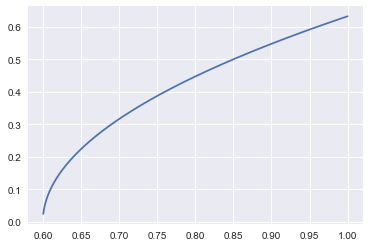

In [38]:
%matplotlib inline
x = np.linspace(0, 1, 1000)
plt.plot(x, np.sqrt(x-0.6))
#plt.plot([0,0.6], [0,1.6], '-')
plt.show()

In [43]:
models_list = []
cv_scores = []
for X_train, y_train, X_val, y_val in fold_sets:
    clf = LGBMClassifier(
        random_state=42, 
        n_jobs=-1, 
        importance_type='gain', 
        is_unbalance=False,
        num_leaves = 4,
        learning_rate = 0.13774085087184385,
        n_estimators = 258
    ).fit(X_train_res, y_train_res)
    cv_scores.append(f1_score(y_val, clf.predict(X_val)))
    models_list.append(clf)

In [44]:
test = pd.read_csv('../data/raw/test.csv')

In [46]:
import sys
sys.path.append("../")
from src.models.utils import score_test
score_test(models_list, test, '../data/processed/submission_rus_v2.csv')